# Jorge Drexler's music and lyrics
## Data exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline
import seaborn as sns
from sklearn import preprocessing
from scipy import stats

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
from PIL import Image
from py_lex import EmoLex

import math
from os import path
import re
from collections import Counter

The data in this db was created using [Genius' API](https://genius.com/developers). Check [this notebook](drexler_dataset_builder.ipynb) for the steps taken.

In [2]:
df = pd.read_csv('data/drexler_complete_lyrics.csv', sep=';')
df.sample(10)

id                                             lyrics  \
86   1250670  El deseo sigue un curso paralelo Y la historia...   
87   1483931  No tengo a quien rezarle Pidiendo luz Ando tan...   
26   1031551  Ven, cura esta pena Quítame estas ganas de ti ...   
3    1737867  Mabel, dejó El bolso con unas amigas Y salió a...   
110  1936242  Todo cambia de bolsillo Sin el mínimo decoro E...   
25   1158242  Nuestra primera intención era hacerlo en color...   
107  2223097  Entrar en este verso como el viento Que mueve ...   
88   1221324  Quien no lo sepa ya Lo aprenderá de prisa: La ...   
96   1717480  Se es lo que se es Lo que siempre se ha sido S...   
81   1762376  Desde ahora mismo y aquí Hacia donde quiera qu...   

                                   title  \
86                     El Otro Engranaje   
87                          Hermana Duda   
26                           Ganas de ti   
3                     La luna de espejos   
110                            Data data   
25          Dos colores (blanco y negro)   
107  Que el soneto nos tome por sorpresa   
88                            Inoportuna   
96      Aquiles, por Su Talón Es Aquiles   
81                            Transporte   

                                                   url  \
86   https://genius.com/Jorge-drexler-el-otro-engra...   
87   https://genius.com/Jorge-drexler-hermana-duda-...   
26   https://genius.com/Jorge-drexler-ganas-de-ti-l...   
3    https://genius.com/Jorge-drexler-la-luna-de-es...   
110  https://genius.com/Jorge-drexler-data-data-lyrics   
25   https://genius.com/Jorge-drexler-dos-colores-b...   
107  https://genius.com/Jorge-drexler-que-el-soneto...   
88   https://genius.com/Jorge-drexler-inoportuna-ly...   
96   https://genius.com/Jorge-drexler-aquiles-por-s...   
81   https://genius.com/Jorge-drexler-transporte-ly...   

                        album  duplicated  year  
86   12 Segundos de Oscuridad       False  2006  
87   12 Segundos de Oscuridad       False  2006  
26                     Vaivén       False  1996  
3       La Luz Que Sabe Robar       False  1992  
110        Bailar en la cueva       False  2014  
25                     Vaivén       False  1996  
107                    Others       False  2010  
88   12 Segundos de Oscuridad       False  2006  
96              Amar la trama       False  2010  
81                        Eco       False  2004

## Wordcount
Let's start with a simple word count analysis of our lyrics to see if we can get quick insights.

In [3]:
df['words'] = df.lyrics.str.strip().str.split('[\W_]+')

In [4]:
rows = list()
for row in df[['words']].iterrows():
    r = row[1]
    for word in r.words:
        rows.append((word))

words = pd.DataFrame(rows, columns=['word'])
words.head()

word
0       El
1  perfume
2       de
3       la
4      sal

Remove empty rows and cases

In [5]:
words = words[words.word.str.len() > 0]
words['word'] = words.word.str.lower()
words.head()

word
0       el
1  perfume
2       de
3       la
4      sal

Word count per song

In [6]:
counts = words\
    .word.value_counts()\
    .to_frame()\
    .rename(columns={'word':'n_w'})
counts

n_w
de           858
que          689
la           686
el           611
y            559
en           513
no           377
a            338
un           271
tu           269
se           252
yo           206
una          206
del          203
me           194
mi           144
las          143
lo           143
es           139
los          136
te           127
na           120
con          115
por          109
mar          108
todo         108
como         100
más           94
su            90
hay           85
...          ...
línea          1
hospitales     1
vilo           1
frases         1
usar           1
vip            1
enseñaron      1
baranda        1
lustros        1
minuto         1
maltratado     1
espectro       1
tregua         1
torpes         1
ganador        1
compraste      1
guetos         1
argentina      1
acompañe       1
tintineando    1
dorada         1
recuerdas      1
frontera       1
seguirá        1
catalán        1
agrícolas      1
oigan          1
montaña        1
focos          1
cargamos       1

[3363 rows x 1 columns]

So, from this we get to know two important _(and completely obvious and unimportant)_ facts:
 - Most used words in Jorge Drexler's songs are 'de', 'que', 'la', 'el' and 'y'......
 - **We need to exclude stopwords**.

In [7]:
stopwords = stopwords.words('spanish')

In [8]:
for a_stopword in stopwords:
    if a_stopword in counts.index:
        counts = counts.drop(a_stopword)

In [9]:
counts.head(20)

n_w
na       120
mar      108
tiempo    82
noche     67
luna      63
corazón   57
bailar    53
va        50
cada      50
si        50
dos       49
amor      48
quiero    45
aquí      44
solo      41
luz       41
vida      40
canción   37
cielo     34
piel      34

**WTF is that 'na' topping the list?**

In [10]:
songs = list()
for row in df[['title','words']].iterrows():
    r = row[1]
    if 'na' in r.words:
        songs.append(r.title)

songs

['Estalactitas']

Now it's pretty obvious, just listen to the song.

_by the way... I love this song_

In [11]:
from IPython.display import HTML
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/YFBe7hLUPKo?start=80&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>')

So, let's get rid of that beautiful sounding "na"

In [12]:
counts = counts.drop('na')

Without any further ado, here are the **top 20 words** used by Jorge Drexler.

In [13]:
counts.head(20)

n_w
mar      108
tiempo    82
noche     67
luna      63
corazón   57
bailar    53
va        50
cada      50
si        50
dos       49
amor      48
quiero    45
aquí      44
solo      41
luz       41
vida      40
canción   37
cielo     34
piel      34
viento    34

Let's take that up a notch. Let's check Jorge's top 5 words, use them as themes and see how he has used those themes through time, using his albums as stepping stones.

In [14]:
top_five_words = counts.head(5).index
top_five_words

Index(['mar', 'tiempo', 'noche', 'luna', 'corazón'], dtype='object')

'mar', 'tiempo', 'noche', 'luna' & 'corazón' mean literally and respectively 'sea', 'time', 'night', 'moon' and 'heart'.
Cool stuff to write about, right?

So let's check its counts for each album

In [15]:
words_by_album = {}
words_by_year = {}
for row in df[['album','words','year']].iterrows():
    r = row[1]
    if r.album == 'Others':
        continue
    if r.album not in words_by_album:
        words_by_album[r.album] = {
            top_five_words[0]: 0,
            top_five_words[1]: 0,
            top_five_words[2]: 0,
            top_five_words[3]: 0,
            top_five_words[4]: 0
        }
    if r.year not in words_by_year:
        words_by_year[r.year] = {
            top_five_words[0]: 0,
            top_five_words[1]: 0,
            top_five_words[2]: 0,
            top_five_words[3]: 0,
            top_five_words[4]: 0
        }
    for a_word in r.words:
        if a_word == top_five_words[0]:
            words_by_album[r.album][top_five_words[0]] += 1
            words_by_year[r.year][top_five_words[0]] += 1
        if a_word == top_five_words[1]:
            words_by_album[r.album][top_five_words[1]] += 1
            words_by_year[r.year][top_five_words[1]] += 1
        if a_word == top_five_words[2]:
            words_by_album[r.album][top_five_words[2]] += 1
            words_by_year[r.year][top_five_words[2]] += 1
        if a_word == top_five_words[3]:
            words_by_album[r.album][top_five_words[3]] += 1
            words_by_year[r.year][top_five_words[3]] += 1
        if a_word == top_five_words[4]:
            words_by_album[r.album][top_five_words[4]] += 1
            words_by_year[r.year][top_five_words[4]] += 1

In [16]:
ROWS = 4
COLS = 3
max_appearance = 0
for album in words_by_album:
    for word in words_by_album[album]:
        a_number = words_by_album[album][word]
        if a_number > max_appearance:
            max_appearance = a_number

albums_ordered_by_year = [
    'La Luz Que Sabe Robar', 'Radar', 'Vaivén', 
    'Llueve', 'Frontera', 'Sea', 
    'Eco', '12 Segundos de Oscuridad','Amar la trama',
    'Bailar en la cueva', 'Salvavidas de hielo'
]
years_for_albums = [
    1992, 1994, 1996, 1997, 1999, 
    2001, 2004, 2006, 2010, 2014, 
    2017
]

colormap = {
    'mar': 'xkcd:royal blue',
    'tiempo': 'xkcd:mustard',
    'luna': 'grey',
    'noche': 'black',
    'corazón': 'xkcd:crimson' 
}

def autolabel(rects, x, y):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        axes[x,y].text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')


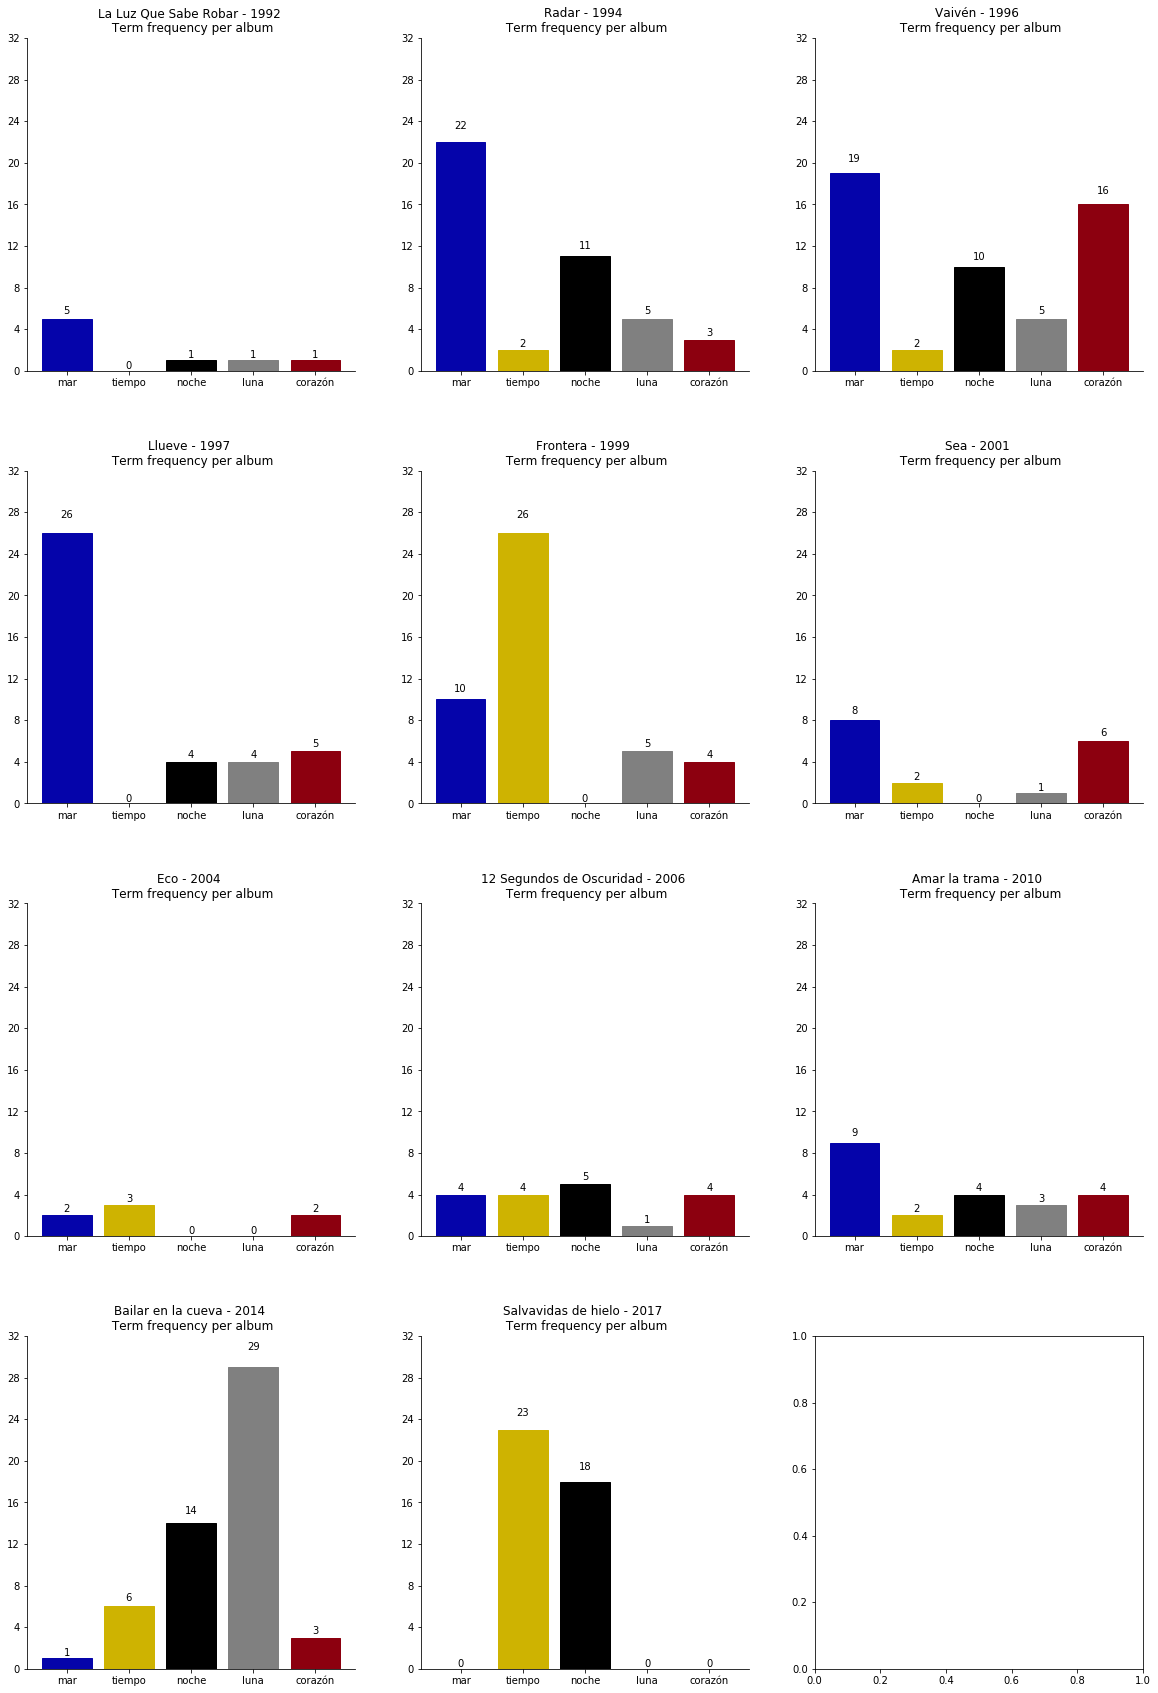

In [17]:
fig, axes = plt.subplots(nrows=ROWS, ncols=COLS, figsize=(20,30))

for row in range(ROWS):
    for col in range(COLS):
        if not albums_ordered_by_year:
            break
            
        an_album_title = albums_ordered_by_year.pop(0)
        an_album_year = years_for_albums.pop(0)
        an_album = words_by_album[an_album_title]
        rects = axes[row, col].bar(range(len(an_album)), list(an_album.values()), align='center')
        axes[row, col].set_xticks(range(len(an_album)))
        axes[row, col].set_xticklabels(list(an_album.keys()))
        axes[row, col].yaxis.set_major_locator(MaxNLocator(integer=True))
        axes[row, col].set_ylim([0,max_appearance + 3])
        axes[row, col].set_title("%s - %d \n Term frequency per album" % (an_album_title, an_album_year))
        axes[row, col].spines['right'].set_visible(False)
        axes[row, col].spines['top'].set_visible(False)
        rects[0].set_color('xkcd:royal blue')
        rects[1].set_color('xkcd:mustard')
        rects[2].set_color('black')
        rects[3].set_color('grey')
        rects[4].set_color('xkcd:crimson')
        autolabel(rects, row, col)

plt.subplots_adjust(hspace = 0.3)
plt.show()

### Come look! Interesting insight!
    - He loved talking about the sea ('mar') in the 90's but grew bored as time passed by.
    - In Vaivén (1996), the heart ('corazón') appears as a practically new theme. It never recovers the lead afterwards. Also the night ('noche') is present. Could this be a heartbreak records?
    - After a time in his albums, practically the first decade of the millenium, where he doesn't revisit his favorite terms a lot, comes back to monothematic stuff.
    - Bailar en la cueva (2014) is super focused on the moon ('luna') and the night ('noche').
    - Salvavidas de hielo (2017) is about the pass of time ('tiempo'), a trend which he recovered from Frontera (1999), and again, the night ('noche').

Let's change the visualization technique to contemplate also the pass of time in each theme.

In [18]:
words_by_year = pd.DataFrame(words_by_year).transpose()

In [19]:
values_for_y_ticks = []
for a_word in words_by_year.columns:
    values_for_y_ticks.extend(words_by_year[a_word].unique())
values_for_y_ticks = list(set(values_for_y_ticks))

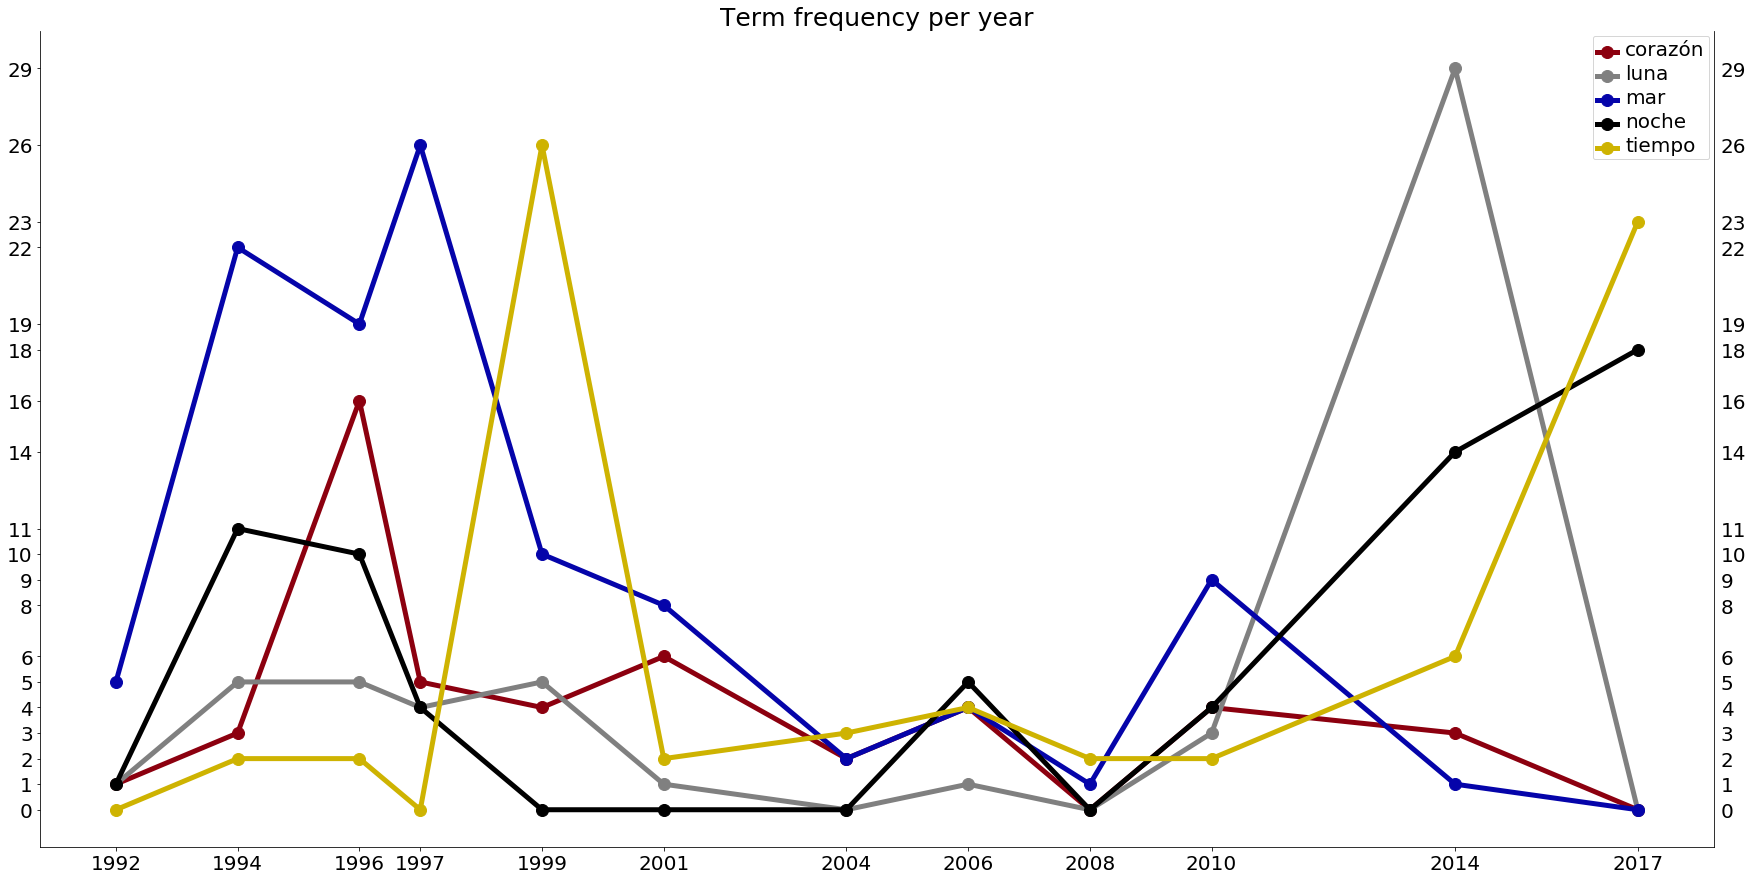

In [20]:
fig, ax = plt.subplots(figsize=(30,15))
for top_word in list(words_by_year.columns):
    ax.plot(
        words_by_year.index, 
        words_by_year[top_word], 
        '-', 
        color=colormap[top_word], 
        linewidth=5, 
        marker='o',
        markersize=12
    )
leg = plt.legend()
# get the individual lines inside legend and set line width
for line in leg.get_lines():
    line.set_linewidth(5)
# get label texts inside legend and set font size
for text in leg.get_texts():
    text.set_fontsize(20)
plt.xticks(words_by_year.index)
plt.yticks(values_for_y_ticks)
ax.spines["top"].set_visible(False)
plt.tick_params(axis='both', labelright=True, labelsize=20)
ax.set_title("Term frequency per year", fontdict={'fontsize': 25})
plt.show()

- In this graph we can actually see the valley in which his most popular themes fall during the 00's.
- The moon ('luna') achieves an all time high in "Bailar en la cueva" (2014).
- Time ('tiempo') peaks in Frontera (1999), sea ('mar') in Llueve (1997) and the night ('noche') in his last album "Salvavidas de Hielo" (2017).

Let's bring the dataframe I got from combining the [Spotify API](https://developer.spotify.com/documentation/web-api/) and the previous one we had. Check [this notebook](drexler_dataset_builder.ipynb) for the steps taken.

In [21]:
df = pd.read_csv("data/drexler_final.csv", sep=';',index_col=0)

In [22]:
df.head()

track_number                            name                album  \
index                                                                      
0                 1                      Movimiento  Salvavidas de hielo   
1                 2                       Telefonía  Salvavidas de hielo   
2                 3                        Silencio  Salvavidas de hielo   
3                 4  Pongamos que hablo de Martínez  Salvavidas de hielo   
4                 5                    Estalactitas  Salvavidas de hielo   

       year  duplicated  duration_ms  duration_s  acousticness  danceability  \
index                                                                          
0      2017       False       231653  23.165.333         0.900         0.784   
1      2017       False       184963  18.496.354         0.829         0.915   
2      2017       False       207986  20.798.667         0.263         0.887   
3      2017       False       182453  18.245.333         0.893         0.849   
4      2017       False       261066  26.106.667         0.797         0.772   

       energy  key    tempo  time_signature  valence  mode  \
index                                                        
0       0.457  2.0  125.021             4.0    0.546   1.0   
1       0.592  6.0  126.060             4.0    0.841   0.0   
2       0.568  4.0  127.923             4.0    0.127   0.0   
3       0.458  9.0  119.950             4.0    0.461   1.0   
4       0.630  0.0  136.019             4.0    0.909   1.0   

                                                  lyrics  
index                                                     
0      Apenas nos pusimos en dos pies Comenzamos a mi...  
1      Que viva la telefonía En todas sus variantes P...  
2      Todo el mundo intentando venderte algo Intenta...  
3      Fuimos cerrando, uno a uno cuatro bares Montev...  
4      El tiempo era entonces dinamita Vivíamos colga...

In [23]:
df['duration_s'] = df['duration_ms'] * 0.001
df['name'] = df['name'].str.replace(" \(feat.*$", "")

Let's bring back the word count angle for a moment. Let's see how many words his songs have and how this variable is distributed in his albums

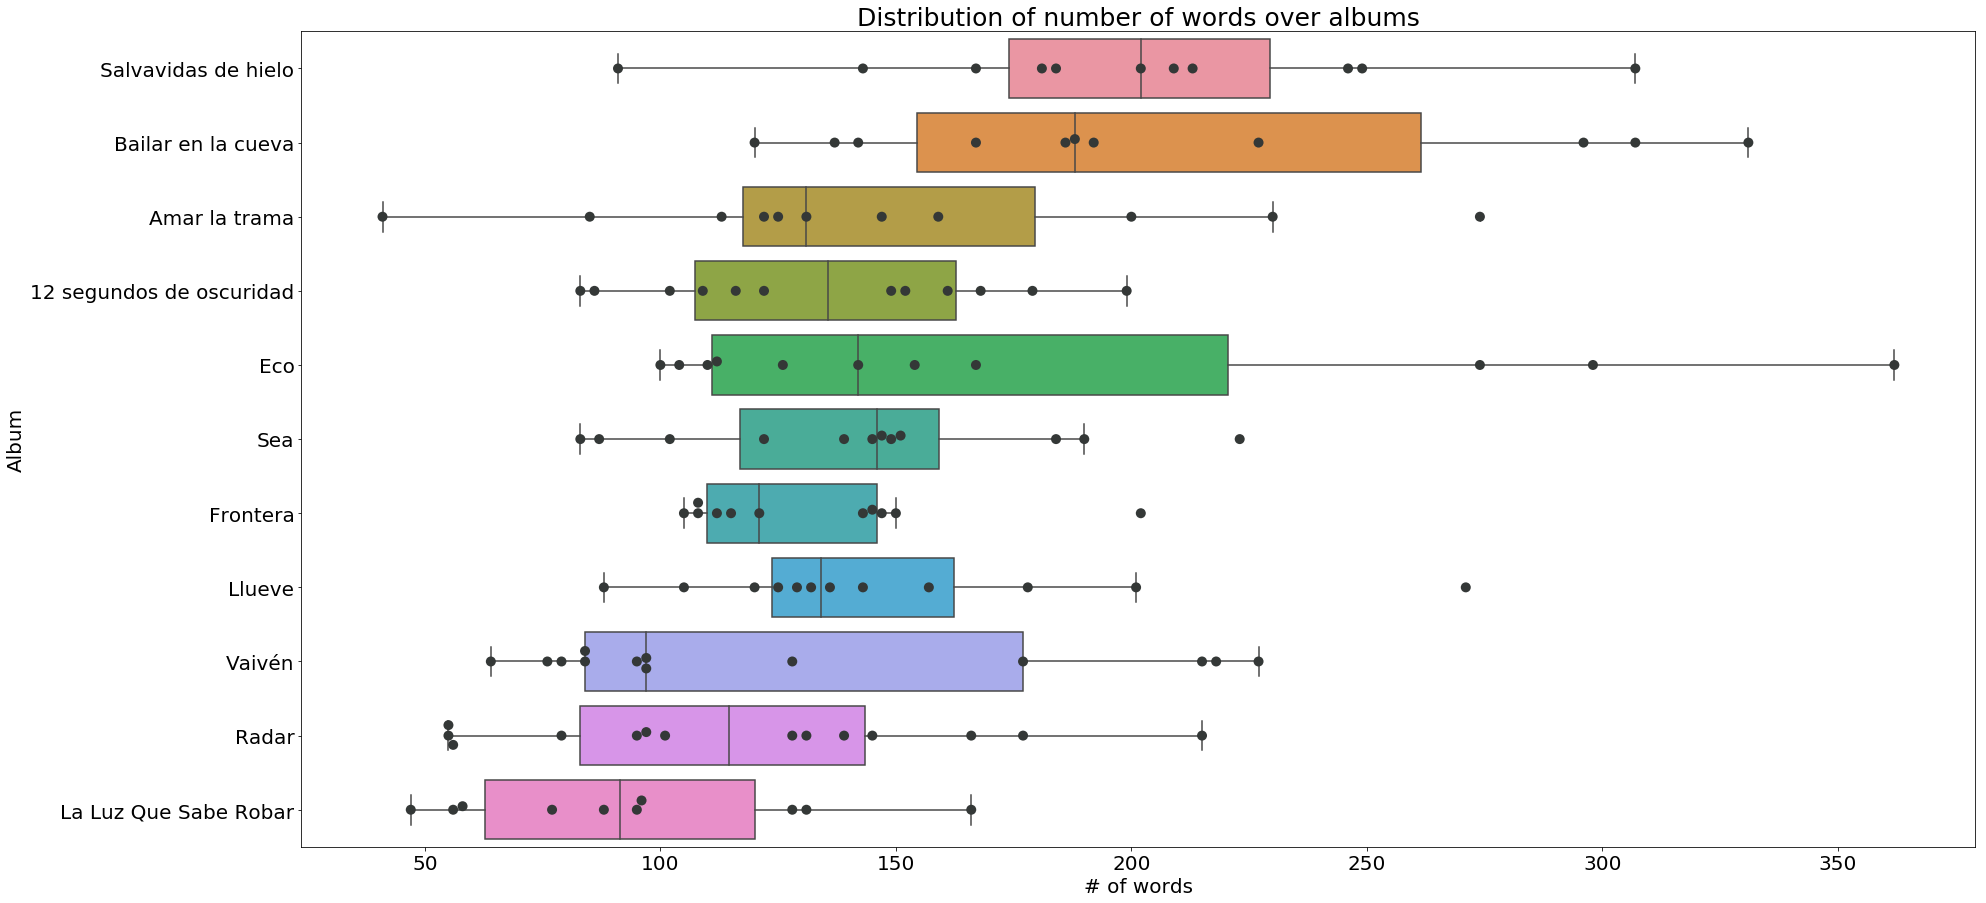

In [24]:
amount_of_words = df.lyrics.str.split().str.len()

fig, ax = plt.subplots(figsize=(30,15))
ax = sns.boxplot(x=amount_of_words, y="album", data=df, orient='h')
ax = sns.swarmplot(x=amount_of_words, y="album", data=df, orient='h', size=10, color="xkcd:charcoal")
plt.xlabel('# of words', fontsize=20)
plt.ylabel('Album', fontsize=20)
plt.title('Distribution of number of words over albums', fontsize=25)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
plt.plot();

Some pretty interesting insight can we seen here.
- There's a more than clear trend of growth over time. __The mean number of words increases with the years__.
- Eco is by far the album with more variance, and it also poseses the Drexler song with more words: "Guitarra y vos"

Let's calculate some more stats to check just from the lyrics. We'll get to explanations later.

In [25]:
stopset = set(stopwords)
df['tokens'] = pd.Series(dtype=object)
for index, row in df.iterrows():
    try:
        tokens = word_tokenize(row['lyrics'])
        tokens_wo_stopwords = [word for word in tokens if not word in stopset]
        df.at[index, 'tokens'] = tokens_wo_stopwords
        df.at[index, 'le_d'] = ( len(tokens_wo_stopwords) / len(tokens) ) * 100
        df.at[index, 'ly_d'] = len(tokens) / row['duration_s']
        df.at[index, 'n_words'] = len(tokens)
        df.at[index, 'n_words_no_rep'] = len(list(set(tokens)))
    except: # songs without lyrics throw exceptions, i'm lazy
        continue

df['le_d'] = df['le_d'].fillna(0)
df['ly_d'] = df['ly_d'].fillna(0)

So, let's change the view on amount of words through time just to recheck our theory.

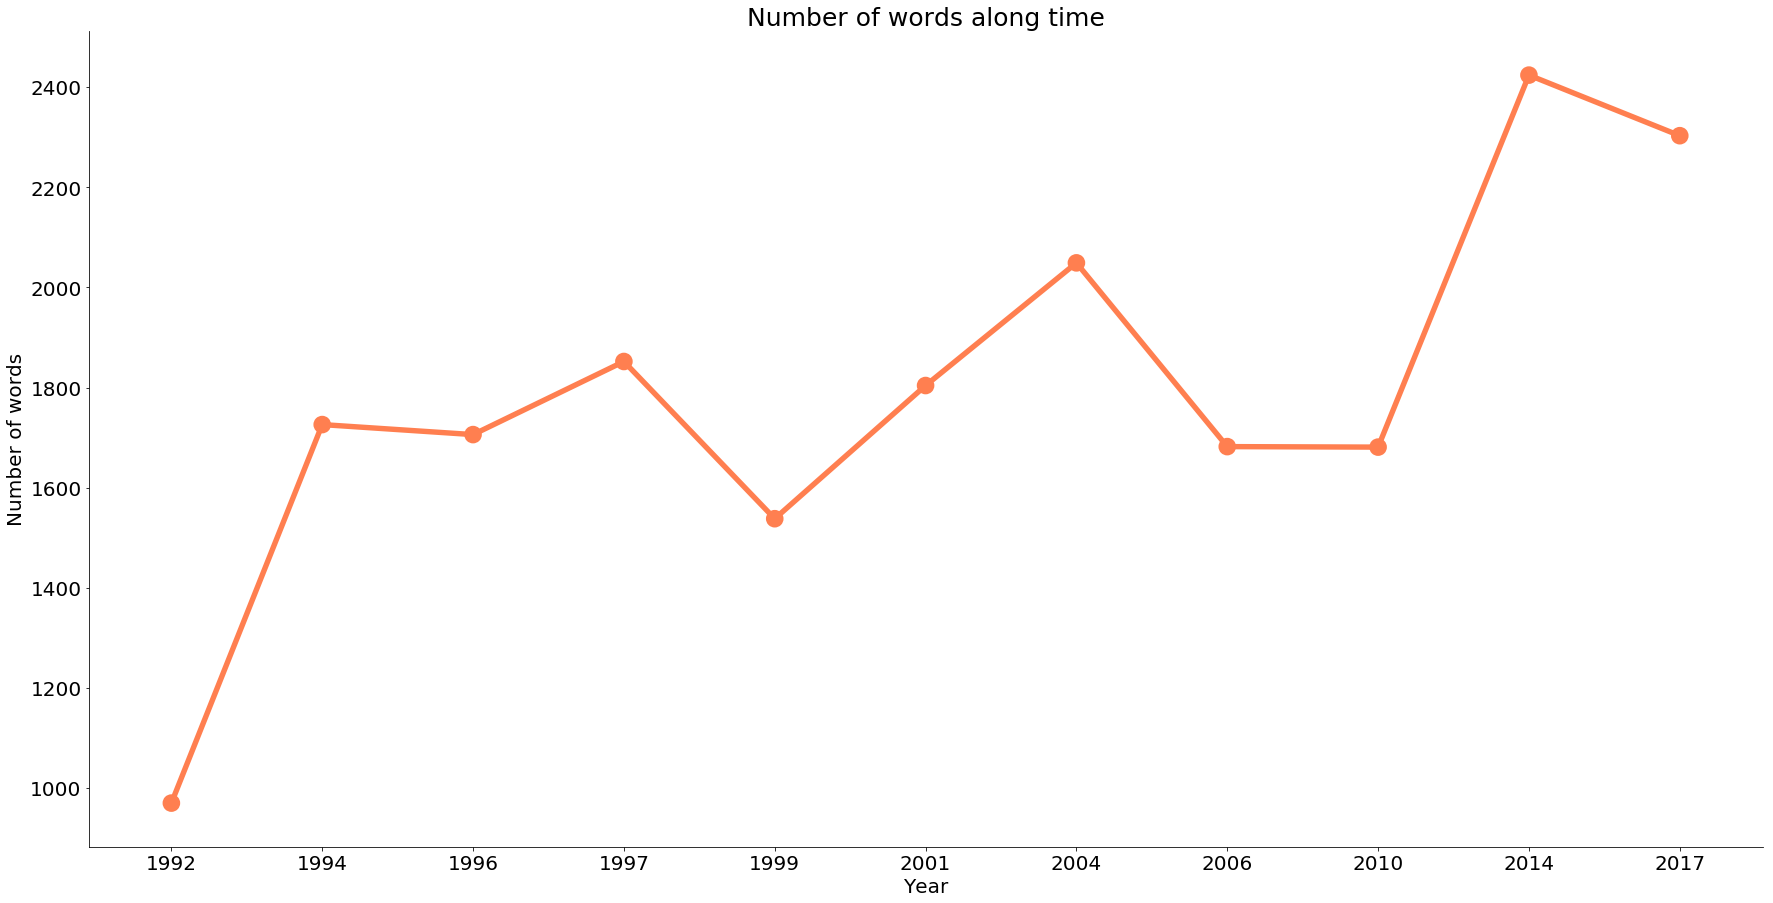

In [26]:
fig, ax = plt.subplots(figsize=(30,15))
n_words_by_album = df.groupby(["year"])['n_words'].sum()
ax = sns.pointplot(x=n_words_by_album.index, y=n_words_by_album, color="coral", scale=2)
plt.xlabel('Year', fontsize=20)
plt.ylabel('Number of words', fontsize=20)
plt.title('Number of words along time', fontsize=25)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
sns.despine()
plt.plot();

Indeed there's a clear trend of including more and more words on his lyrics with time.

How about the amount of words per song? Let's look at top songs with more words and top songs with less words.

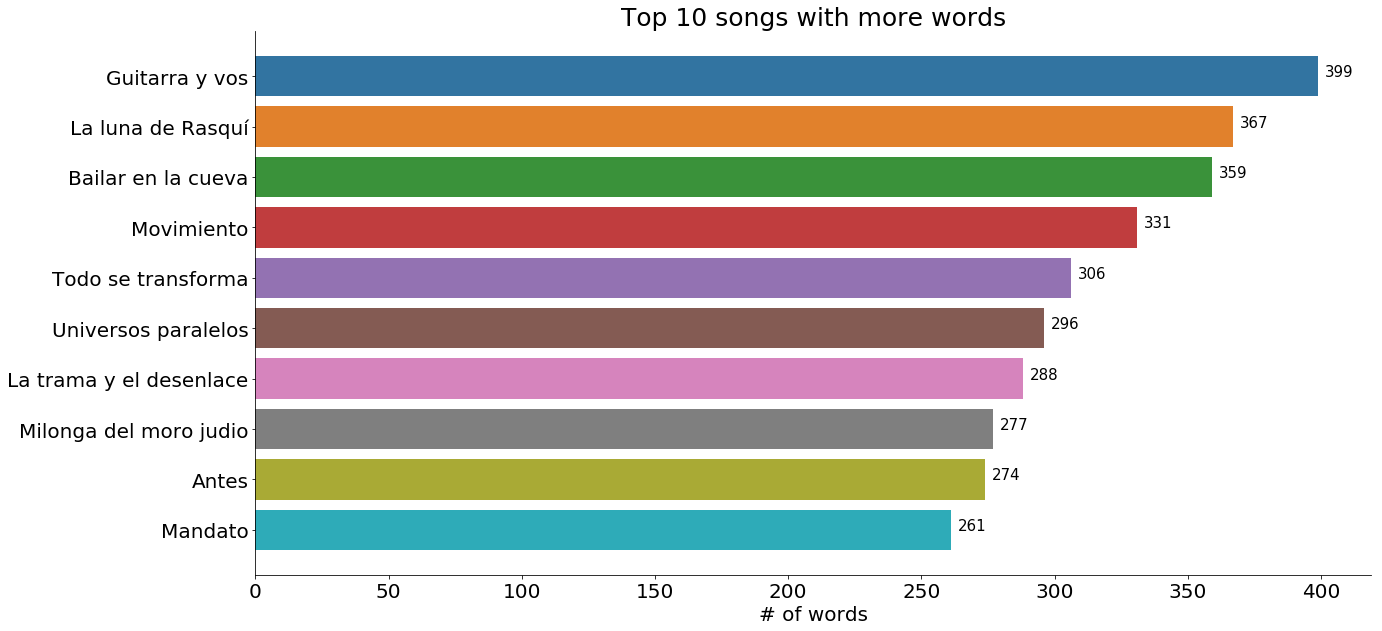

In [27]:
songs_with_more_words = df.sort_values("n_words", ascending=False)[:10]

fig, ax = plt.subplots(figsize=(20,10))
ax = sns.barplot(x="n_words", y="name", data=songs_with_more_words)
plt.ylabel("")
plt.xlabel('# of words', fontsize=20)
plt.title('Top 10 songs with more words', fontsize=25)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for p in ax.patches:
    width = p.get_width()
    ax.text(width + 8  ,
            p.get_y() + p.get_height()/2.,
            "%d" % width,
            ha="center", fontsize=15)
sns.despine()
plt.plot();

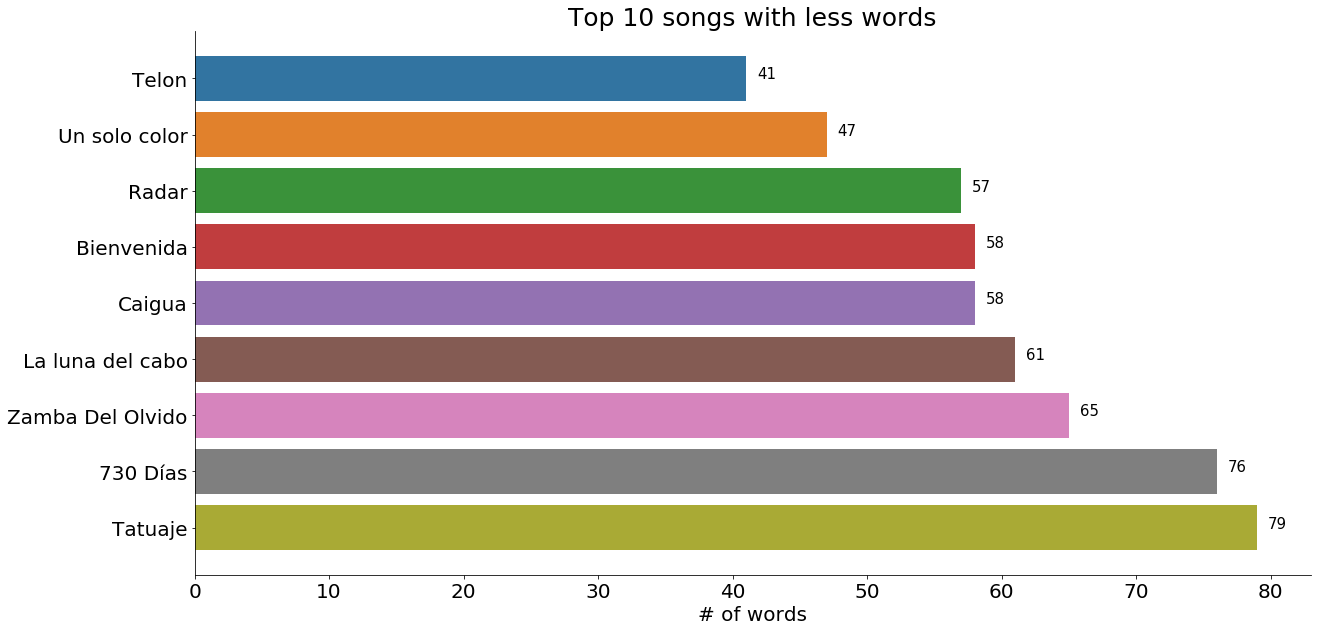

In [28]:
songs_with_less_words = df.sort_values("n_words")[:10]

fig, ax = plt.subplots(figsize=(20,10))
ax = sns.barplot(x="n_words", y="name", data=songs_with_less_words)
plt.ylabel("")
plt.xlabel('# of words', fontsize=20)
plt.title('Top 10 songs with less words', fontsize=25)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for p in ax.patches:
    width = p.get_width()
    ax.text(width + 1.5  ,
            p.get_y() + p.get_height()/2.,
            "%d" % width,
            ha="center", fontsize=15)
sns.despine()
plt.plot();

So, 
- **Guitarra y vos**, **La luna de Rasquí** & **Bailar en la cueva** are his songs with more number of lyrics.
- **Telón**, **Un solo color** & **Radar** are his songs with less.

Let's make a pretty wordcloud before leaving the word count subject and move to something more juicy.

In [29]:
stopset.add('na')
def make_corpora(a_series):
    corpora = []
    for a_sentence in a_series:
        try:
            new_lower_sentence = []
            for a_word in a_sentence:
                new_lower_sentence.append(a_word.lower())
            corpora.extend(new_lower_sentence)
        except:
            continue
    nonPunct = re.compile('.*[A-Za-z0-9].*')  # must contain a letter or digit
    filtered = [w for w in corpora if nonPunct.match(w) and w not in stopset]
    counts = Counter(filtered)
    return counts
drexler_counts = make_corpora(df.tokens)

In [30]:
def plot_wordcloud_from_list(a_list):
    freqs_by_words = {}
    for a_topic_term in a_list:
        an_actual_word = a_topic_term[0]
        freqs_by_words[an_actual_word] = a_topic_term[1]
    # read the mask image
    trump_mask = np.array(Image.open("data/heart.jpg"))

    wc = WordCloud(background_color="white", max_words=2000, mask=trump_mask, max_font_size=100,)
    # generate word cloud
    wc.generate_from_frequencies(freqs_by_words)

    #show
    plt.figure(figsize=(15,15))
    plt.imshow(wc, cmap=plt.cm.gray, interpolation='bilinear')
    plt.axis("off")
    plt.show()

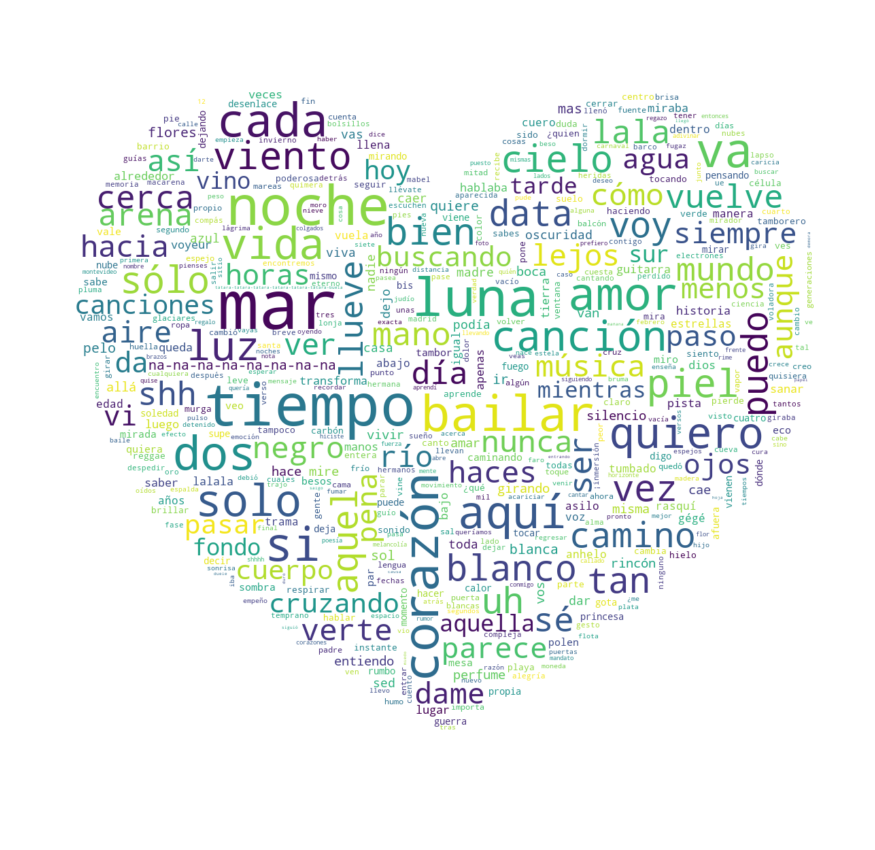

In [31]:
plot_wordcloud_from_list(drexler_counts.most_common(500))

## Lexical Density

In the realm of content analysis there is a measure known as lexical density which is a measure of the number of content words as a proportion of the total number of words - a value which ranges from 0 to 100. In general, the greater the lexical density of a text, the more content heavy it is and more 'unpacking' it takes to understand - texts with low lexical density are easier to understand.

According to Wikipedia the formula is as follows:

$$ Ld = \frac{Nlex}{N} * 100$$

where Ld is the analysed text's lexical density, Nlex is the number of lexical word tokens (nouns, adjectives, verbs, adverbs) in the analysed text, and N is the number of all tokens (total number of words) in the analysed text.

I don't know how ortodox this is, but basing myself on [Myles Harrison's amazing data analysis on Radiohead](http://www.everydayanalytics.ca/2013/06/radiohead-lyrics-data-visualization-and-content-analysis.html), it sounds like this is just the ratio of words which are not stopwords to the total number - or could at least be approximated by it. This calculations steps are fairly simple to follow in pandas.

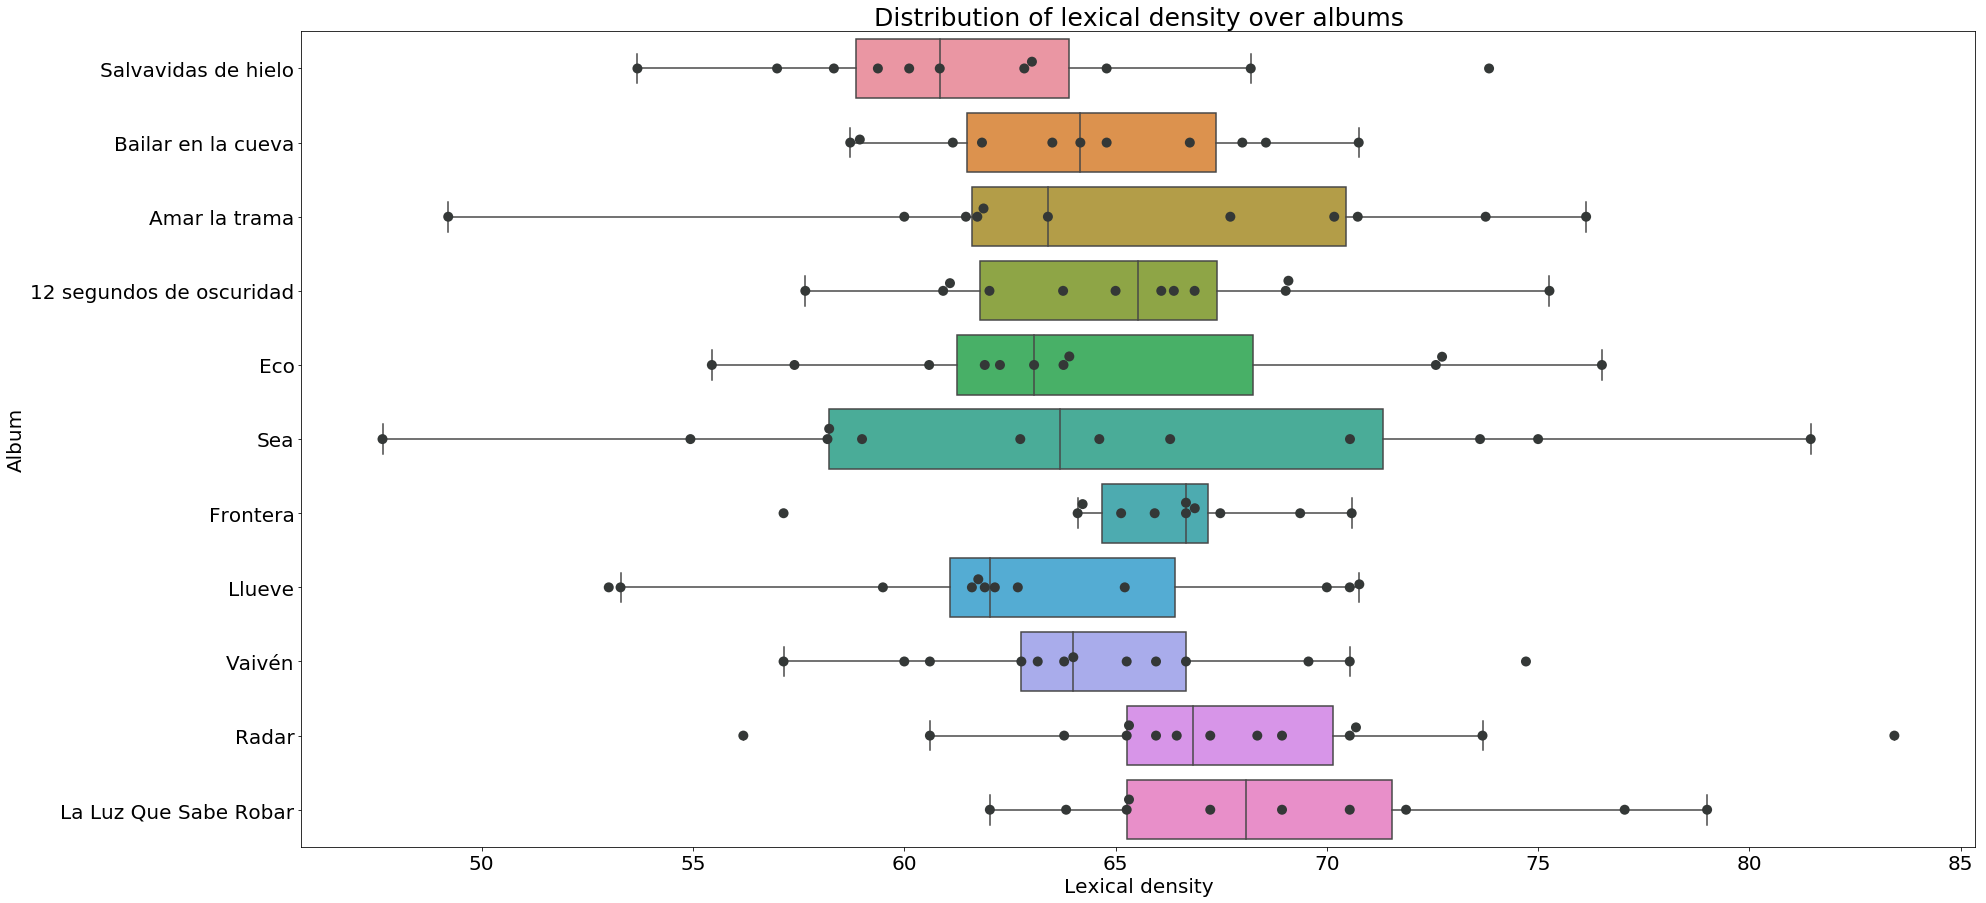

In [32]:
fig, ax = plt.subplots(figsize=(30,15))
ax = sns.boxplot(x="le_d", y="album", data=df[df['le_d'] > 0], orient='h')
ax = sns.swarmplot(x="le_d", y="album", data=df[df['le_d'] > 0], orient='h', size=10, color="xkcd:charcoal")
plt.xlabel('Lexical density', fontsize=20)
plt.ylabel('Album', fontsize=20)
plt.title('Distribution of lexical density over albums', fontsize=25)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
plt.plot();

So, check this out! Big tendency to decrease with time. Lexical density actually goes down from La luz que sabe robar to Salvavidas de hielo.
Frontera seems to be a pretty consistent album in terms of lexical density, while Sea is all over the place.

We can also check how lexical density is distributed along all songs and not just clustered by album.

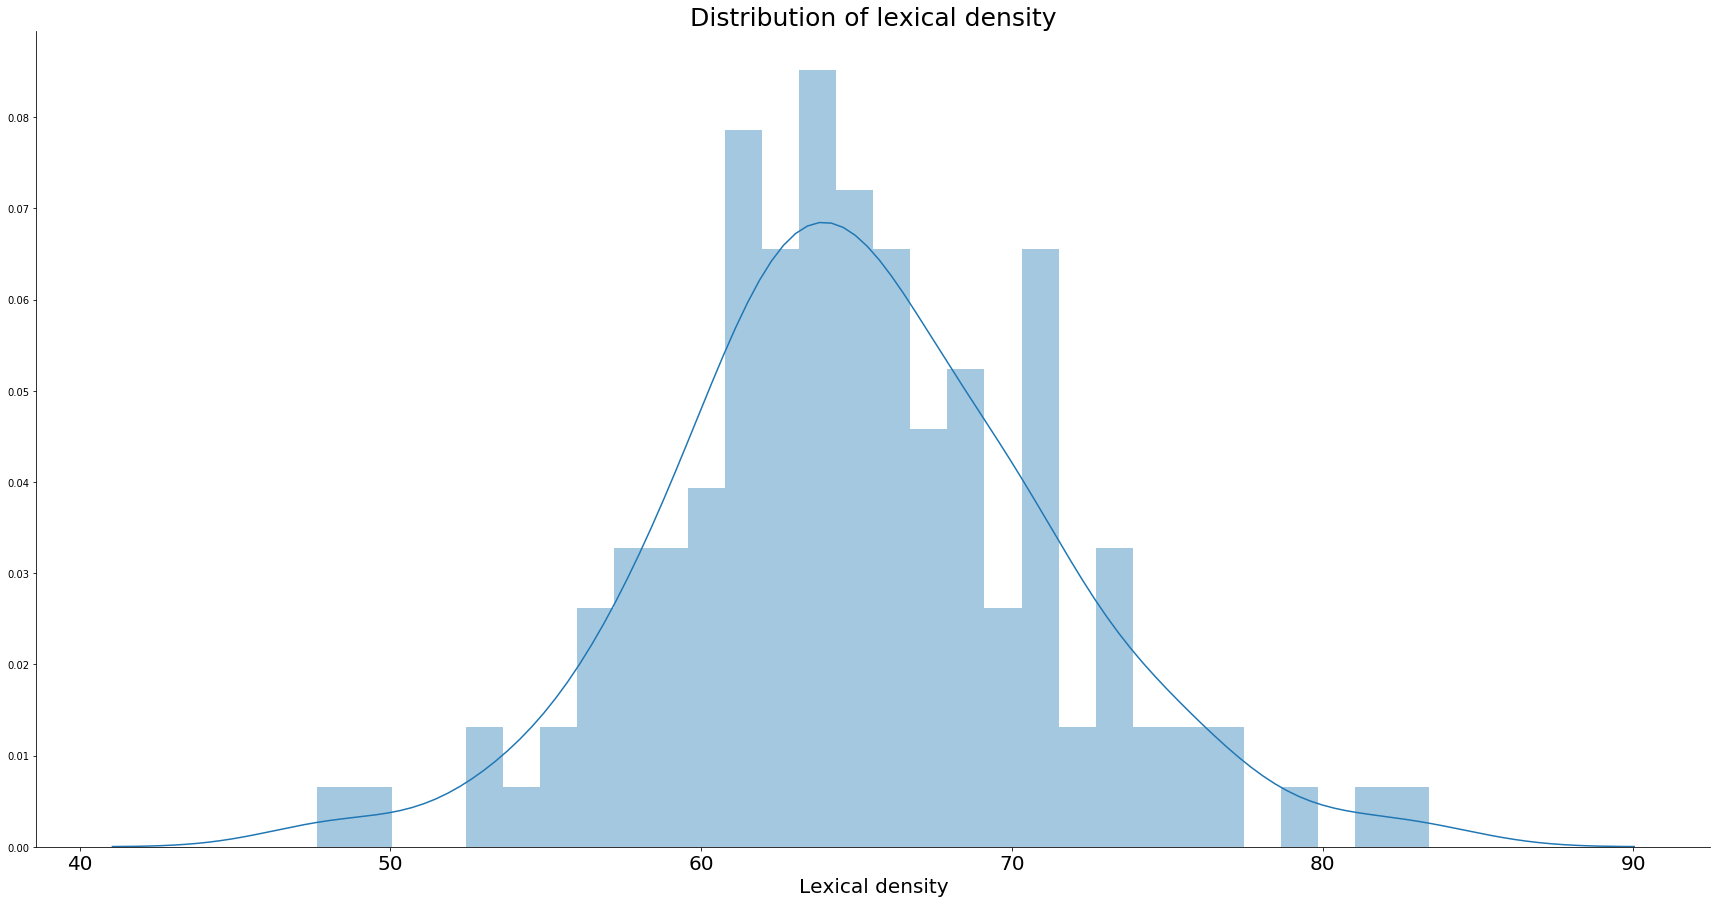

In [33]:
df['le_d'] = df['le_d'].fillna(0)

fig, ax = plt.subplots(figsize=(30,15))
ax = sns.distplot(df[df['le_d'] > 0]['le_d'], bins=30)
plt.xlabel('Lexical density', fontsize=20)
plt.title('Distribution of lexical density', fontsize=25)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
sns.despine()
plt.plot();


## Lyrical density
Now, [Myles](http://www.everydayanalytics.ca/2013/06/radiohead-lyrics-data-visualization-and-content-analysis.html) also invented another metric. Basically "Lyrical density" is the amount of words per unit of time. How fast information travels, how many units of language can you put in a second?

In [34]:
df.sort_values(by='ly_d', ascending=False).head(5)[['name', 'album', 'year', 'ly_d']]

name                album  year      ly_d
index                                                         
50         Guitarra y vos                  Eco  2004  1.697396
14      La luna de Rasquí   Bailar en la cueva  2014  1.660829
11     Bailar en la cueva   Bailar en la cueva  2014  1.480205
0              Movimiento  Salvavidas de hielo  2017  1.428861
49     Todo se transforma                  Eco  2004  1.409190

Almost coinciding with most words per song, those 5 have the "fastest spilled lyrics"

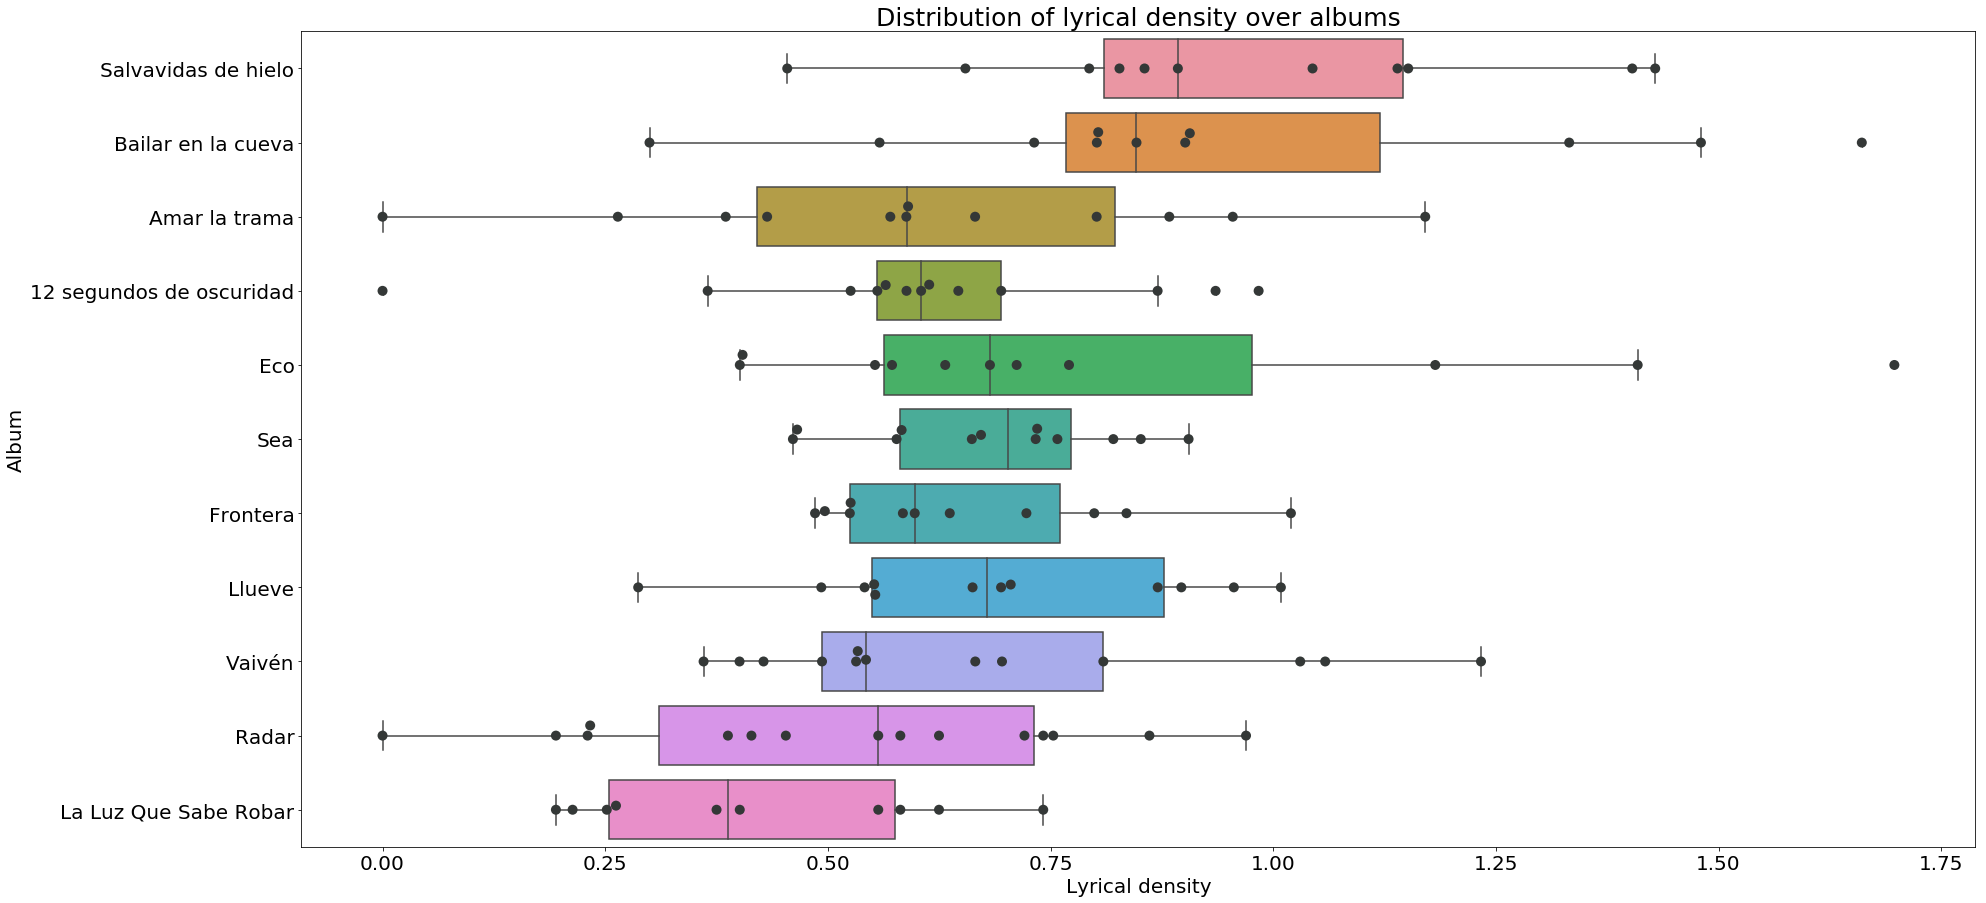

In [35]:
fig, ax = plt.subplots(figsize=(30,15))
ax = sns.boxplot(x="ly_d", y="album", data=df, orient='h')
ax = sns.swarmplot(x="ly_d", y="album", data=df, orient='h', size=10, color="xkcd:charcoal")
plt.xlabel('Lyrical density', fontsize=20)
plt.ylabel('Album', fontsize=20)
plt.title('Distribution of lyrical density over albums', fontsize=25)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
plt.plot();

This is amazing. Let's bring back some past insights into the mix to analyse this one.
- The tendency in lyrical density goes up through time and albums.
- Remember that number of words showed the same trend? Well, they are linearly codependent.. so correlation must be over the roof. Though, the interesting thing is that lexical density has the inverted effect: __as with time Jorge wrote less dense-with-content lyrics, he sang faster__. May this be the case?

Let's check distribution also along the whole corpus of songs.

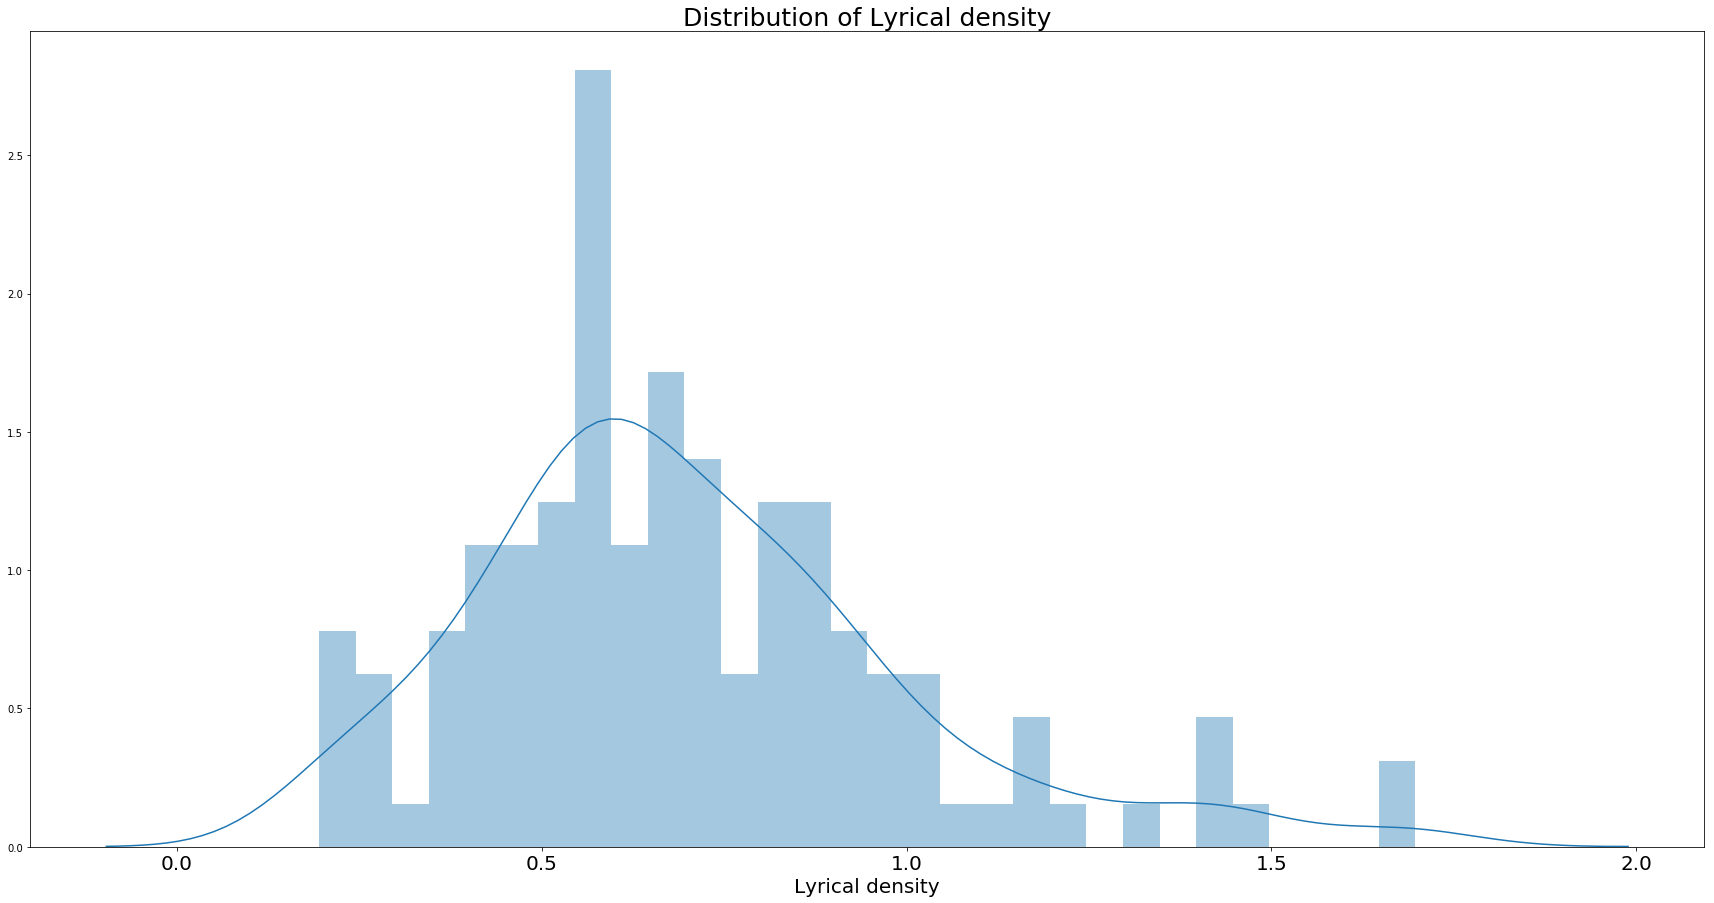

In [36]:
df['ly_d'] = df['ly_d'].fillna(0)

fig, ax = plt.subplots(figsize=(30,15))
ax = sns.distplot(df[df['ly_d'] > 0]['ly_d'], bins=30)
plt.xlabel('Lyrical density', fontsize=20)
plt.title('Distribution of Lyrical density', fontsize=25)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
plt.plot();


Let's see if we can get some insight with confronting both densities in the same visualization

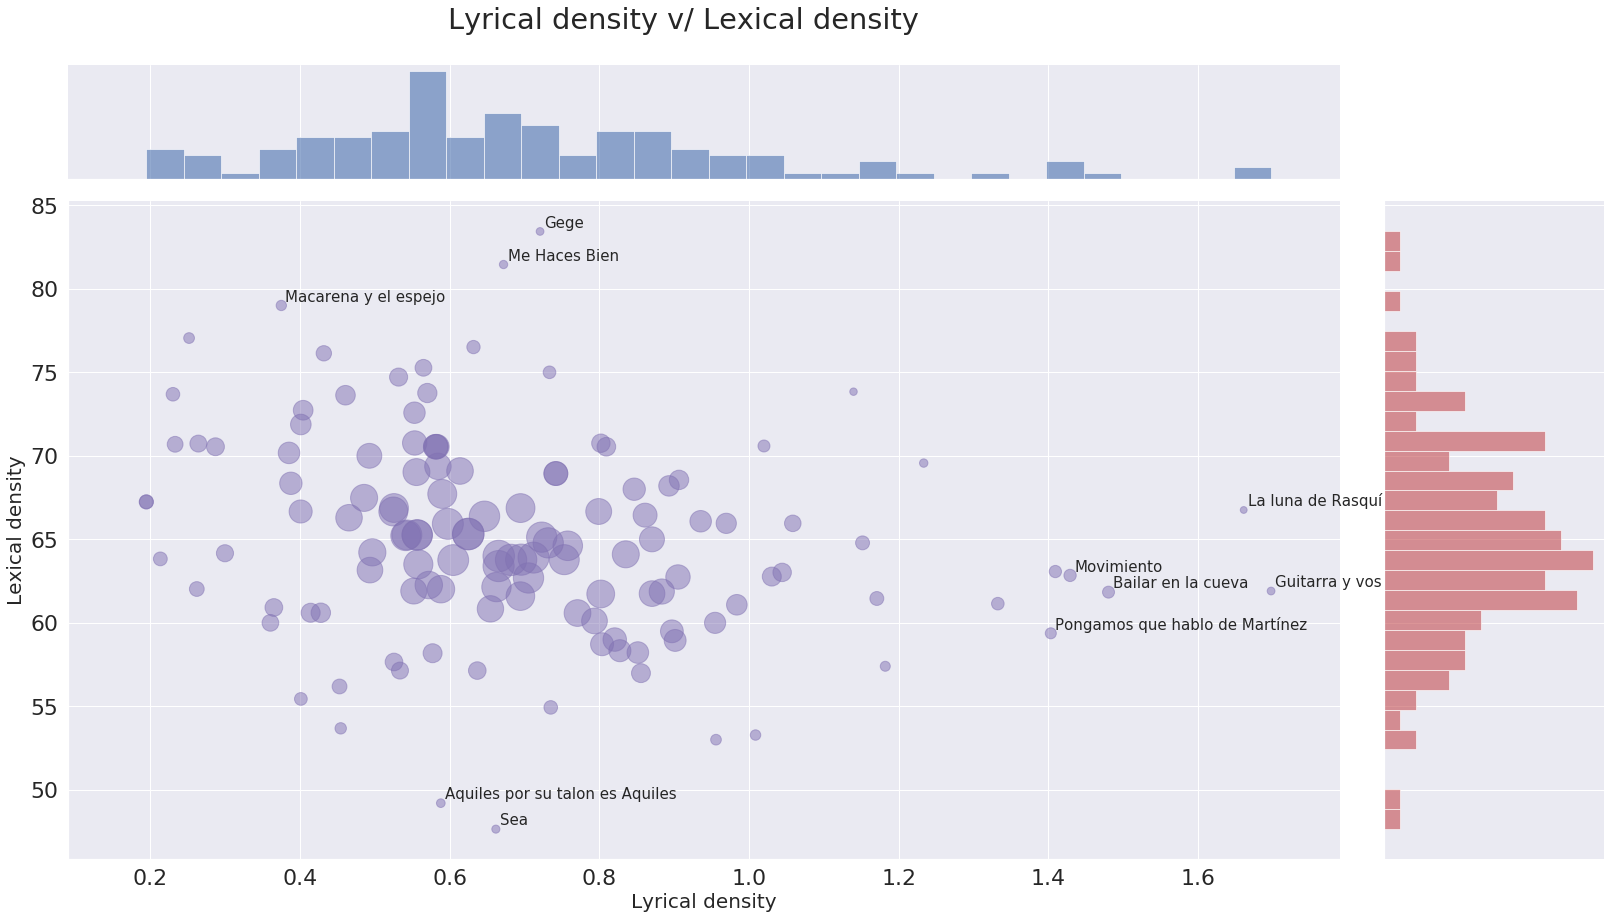

In [37]:
sns.set(font_scale = 2) #Horrendous hack to increase the size on jointgrid. Seaborn, step up.
df_to_plot = df[(df['ly_d'] > 0) & (df['le_d'] > 0)].reset_index(drop=True)
g = sns.JointGrid(x="ly_d", y="le_d", data=df_to_plot)

x = df_to_plot['ly_d']
y = df_to_plot['le_d']
xy = np.vstack([x,y])
z = stats.gaussian_kde(xy)(xy) * 10000 # The 10K is for scale

g = g.plot_joint(plt.scatter, s=z, c='m', alpha=0.5)
_ = g.ax_marg_x.hist(df_to_plot['ly_d'], color="b", alpha=.6, bins=30)
_ = g.ax_marg_y.hist(df_to_plot['le_d'], color="r", alpha=.6, orientation="horizontal", bins=30)
plt.xlabel('Lyrical density', fontsize=20)
plt.ylabel('Lexical density', fontsize=20)
g.fig.suptitle('Lyrical density v/ Lexical density') # can also get the figure from plt.gcf()
g.fig.set_figwidth(30)
g.fig.set_figheight(15)

# Calculate outliers
z_score = np.abs(stats.zscore(df_to_plot[['ly_d', 'le_d']]))
threshold = 2
out_x, _ = np.where(z_score > threshold) 

# Indices to annotate
out_x = np.delete(out_x, [4,6]) # Deleting two outliers just for visualization purposes
out = df_to_plot.loc[out_x]
def ann(row):
    ind = row[0]
    r = row[1]
    plt.gca().annotate(r['name'], xy=(r["ly_d"], r["le_d"]), 
            xytext=(4,4), textcoords ="offset points", fontsize=15 )
for row in out.iterrows():
    ann(row)


plt.plot();
sns.reset_defaults()

By checking the outliers of this little graph, we can see that:
    - Like we said before, songs like "Movimiento", "La luna de Rasquí", "Guitarra y vos" y "Pongamos que hablo de Martínez" carry a big lyrical density while a relative mean lexical one. This means they spit lots of words out per second (more than 1.4 word a second!) while not having an uncommon amount of content in those words.
    - "Gege", "Me haces bien" and "Macarena y el espejo" are songs that carry lots of meaning in their words but are sang rather slowly.
    - "Aquiles por su talón es Aquiles" and "Sea" are sang rather slowly and their content rate is not that big.

# Sentiment analysis
Well, here we are with something a little bit more juicy than just counting words.

Sentiment analysis, according to [Wikipedia](https://en.wikipedia.org/wiki/Sentiment_analysis), is the use of natural language processing, text analysis, computational linguistics, and biometrics to systematically identify, extract, quantify, and study affective states and subjective information.

In this case, I used a couple of really good resources to do this. First and foremost, [NRC Word-Emotion Association Lexicon (aka EmoLex)](http://saifmohammad.com/WebPages/NRC-Emotion-Lexicon.htm).
	
The NRC Emotion Lexicon is a list of English words and their associations with eight basic emotions (anger, fear, anticipation, trust, surprise, sadness, joy, and disgust) and two sentiments (negative and positive). The annotations were manually done by crowdsourcing. 
The obvious problem with this, for me at least, is that Jorge's lyrics are not in English. EmoLex has also published its lexicon translated into more than 100 languages automatically with Google Translate. 
This is **definitely not 100% accurate** and will make my results a little bit off, but ended up being good enough to get some more interesting insight. Ideally, I'd have a team of people willing to crowdsource the annotations in spanish... maybe next time :).

The task of generating the spanish lexicon was done in [this notebook](constructing_lexicon.ipynb)

[py-lex](https://github.com/dropofwill/py-lex) is a great python library to parse through this lexicon.

In [38]:
lexicon = EmoLex('data/lexicon_spanish.txt')

Let's check the song "Transporte"

In [39]:
summary = lexicon.summarize_doc(df.loc[51].tokens)
summary

{'anger': 0.01818181818181818,
 'anticipation': 0.05454545454545454,
 'disgust': 0.0,
 'fear': 0.0,
 'joy': 0.07272727272727272,
 'negative': 0.0,
 'positive': 0.09090909090909091,
 'sadness': 0.0,
 'surprise': 0.05454545454545454,
 'trust': 0.03636363636363636}

Let's add all this juicy information to our DataFrame

In [40]:
df['anger'] = 0.0
df['anticipation'] = 0.0
df['disgust'] = 0.0
df['fear'] = 0.0
df['joy'] = 0.0
df['negative'] = 0.0
df['positive'] = 0.0
df['sadness'] = 0.0
df['surprise'] = 0.0
df['trust'] = 0.0

In [41]:
for index, _ in df.iterrows():
    try:
        to_lower = list(map(lambda x:x.lower(),df.loc[index].tokens))
        summary = lexicon.summarize_doc(to_lower)
        for key in summary.keys():
            df.at[index, key] = summary[key]
    except:
        continue

Four our first visualization on the subject, let's check emotions in all the corpus of songs.

### What's your general mood, Jorge?

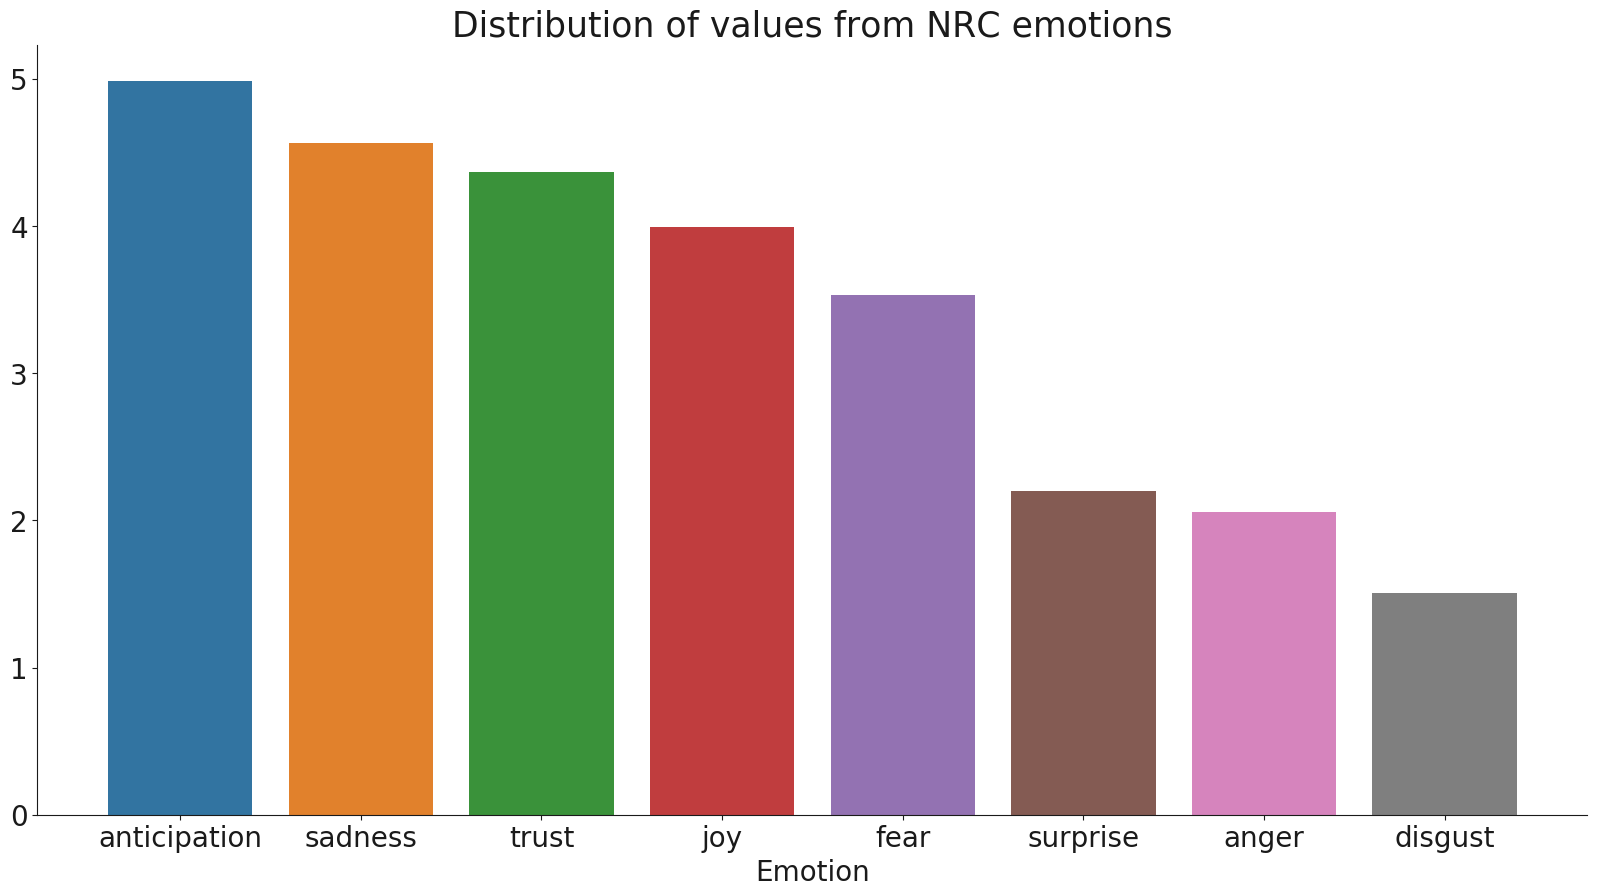

In [42]:
total_sentiments = pd.DataFrame(df.sum()[['fear', 'sadness', 'surprise', 'trust', 'joy', 'anticipation', 'anger', 'disgust']].sort_values(ascending=False))
total_sentiments.columns = ['value']

fig, ax = plt.subplots(figsize=(20,10))
ax = sns.barplot(x=total_sentiments.index, y='value', data=total_sentiments)
plt.ylabel("")
plt.xlabel('Emotion', fontsize=20)
plt.title('Distribution of values from NRC emotions', fontsize=25)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
sns.despine()
plt.plot();


Jorge's songs show a lot of anticipation and sadness. This could be seen as eagerness, excitement, melancholy, feeling blue or just sad.
To no surprise for anyone who has ever listened to his music, the songs show very little anger or disgust.

What about the sentiments presented in all the songs?

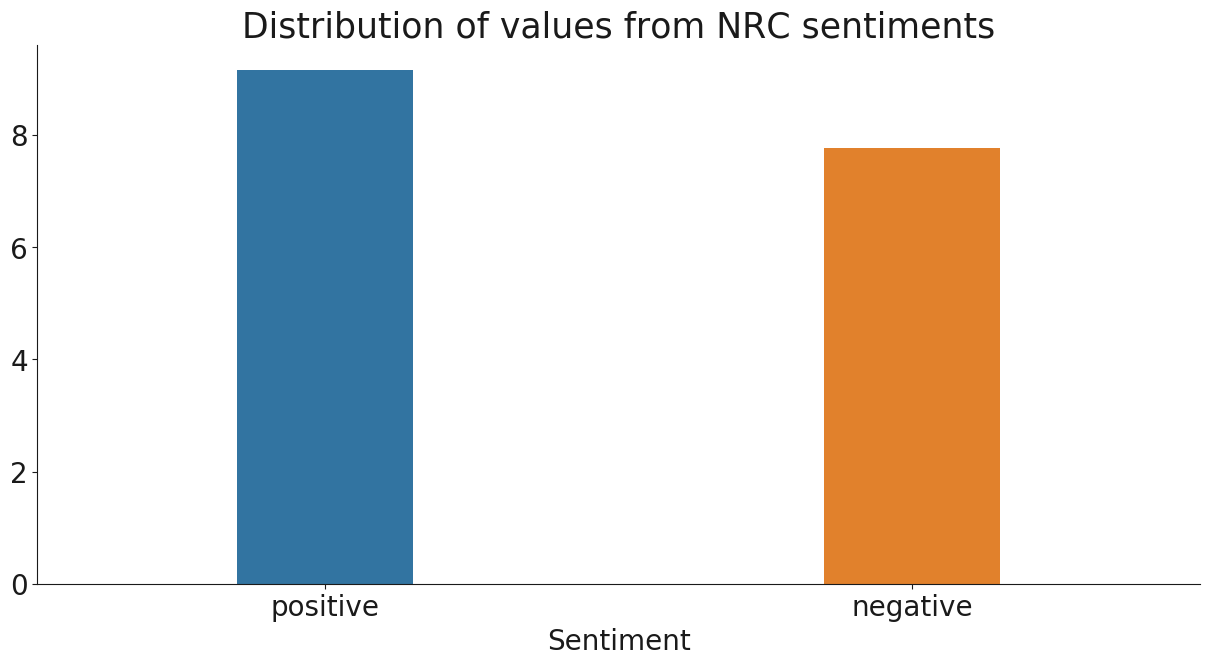

In [43]:
total_sentiment = pd.DataFrame(df.sum()[['positive', 'negative']])
total_sentiment.columns = ['value']

fig, ax = plt.subplots(figsize=(15,7))
ax = sns.barplot(x=total_sentiment.index, y='value', data=total_sentiment)
plt.ylabel("")
plt.xlabel('Sentiment', fontsize=20)
plt.title('Distribution of values from NRC sentiments', fontsize=25)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for patch in ax.patches :
    current_width = patch.get_width()
    diff = current_width - .3

    # we change the bar width
    patch.set_width(.3)

    # we recenter the bar
    patch.set_x(patch.get_x() + diff * .5)
sns.despine()
plt.plot();


Not much to read into this.... his songs are more positive than negative.

Let's check how this analysis was carried through and see which are the top words for each sentiment or emotion

In [44]:
columns = ['word','fear', 'sadness', 'surprise', 'trust', 'joy', 'anticipation', 'anger', 'disgust', 'positive', 'negative']

In [45]:
word_appearances_by_sentiment = pd.DataFrame(columns=columns)
for index, _ in df.iterrows():
    try:
        to_lower = list(map(lambda x:x.lower(),df.loc[index].tokens))
        annotation = lexicon.annotate_doc(to_lower)
        for token, a_set in zip(to_lower, annotation):
            row = [token] + [x in a_set for x in columns[1:]]
            appending_df = pd.DataFrame([row], columns=columns)
            word_appearances_by_sentiment = word_appearances_by_sentiment.append(appending_df)
    except:
        continue
word_appearances_by_sentiment = word_appearances_by_sentiment.groupby("word").agg(
    {'anger': np.sum,
     'anticipation': np.sum,
     'disgust': np.sum,
     'fear': np.sum,
     'joy': np.sum,
     'negative': np.sum,
     'positive': np.sum,
     'sadness': np.sum,
     'surprise': np.sum,
     'trust': np.sum}
)

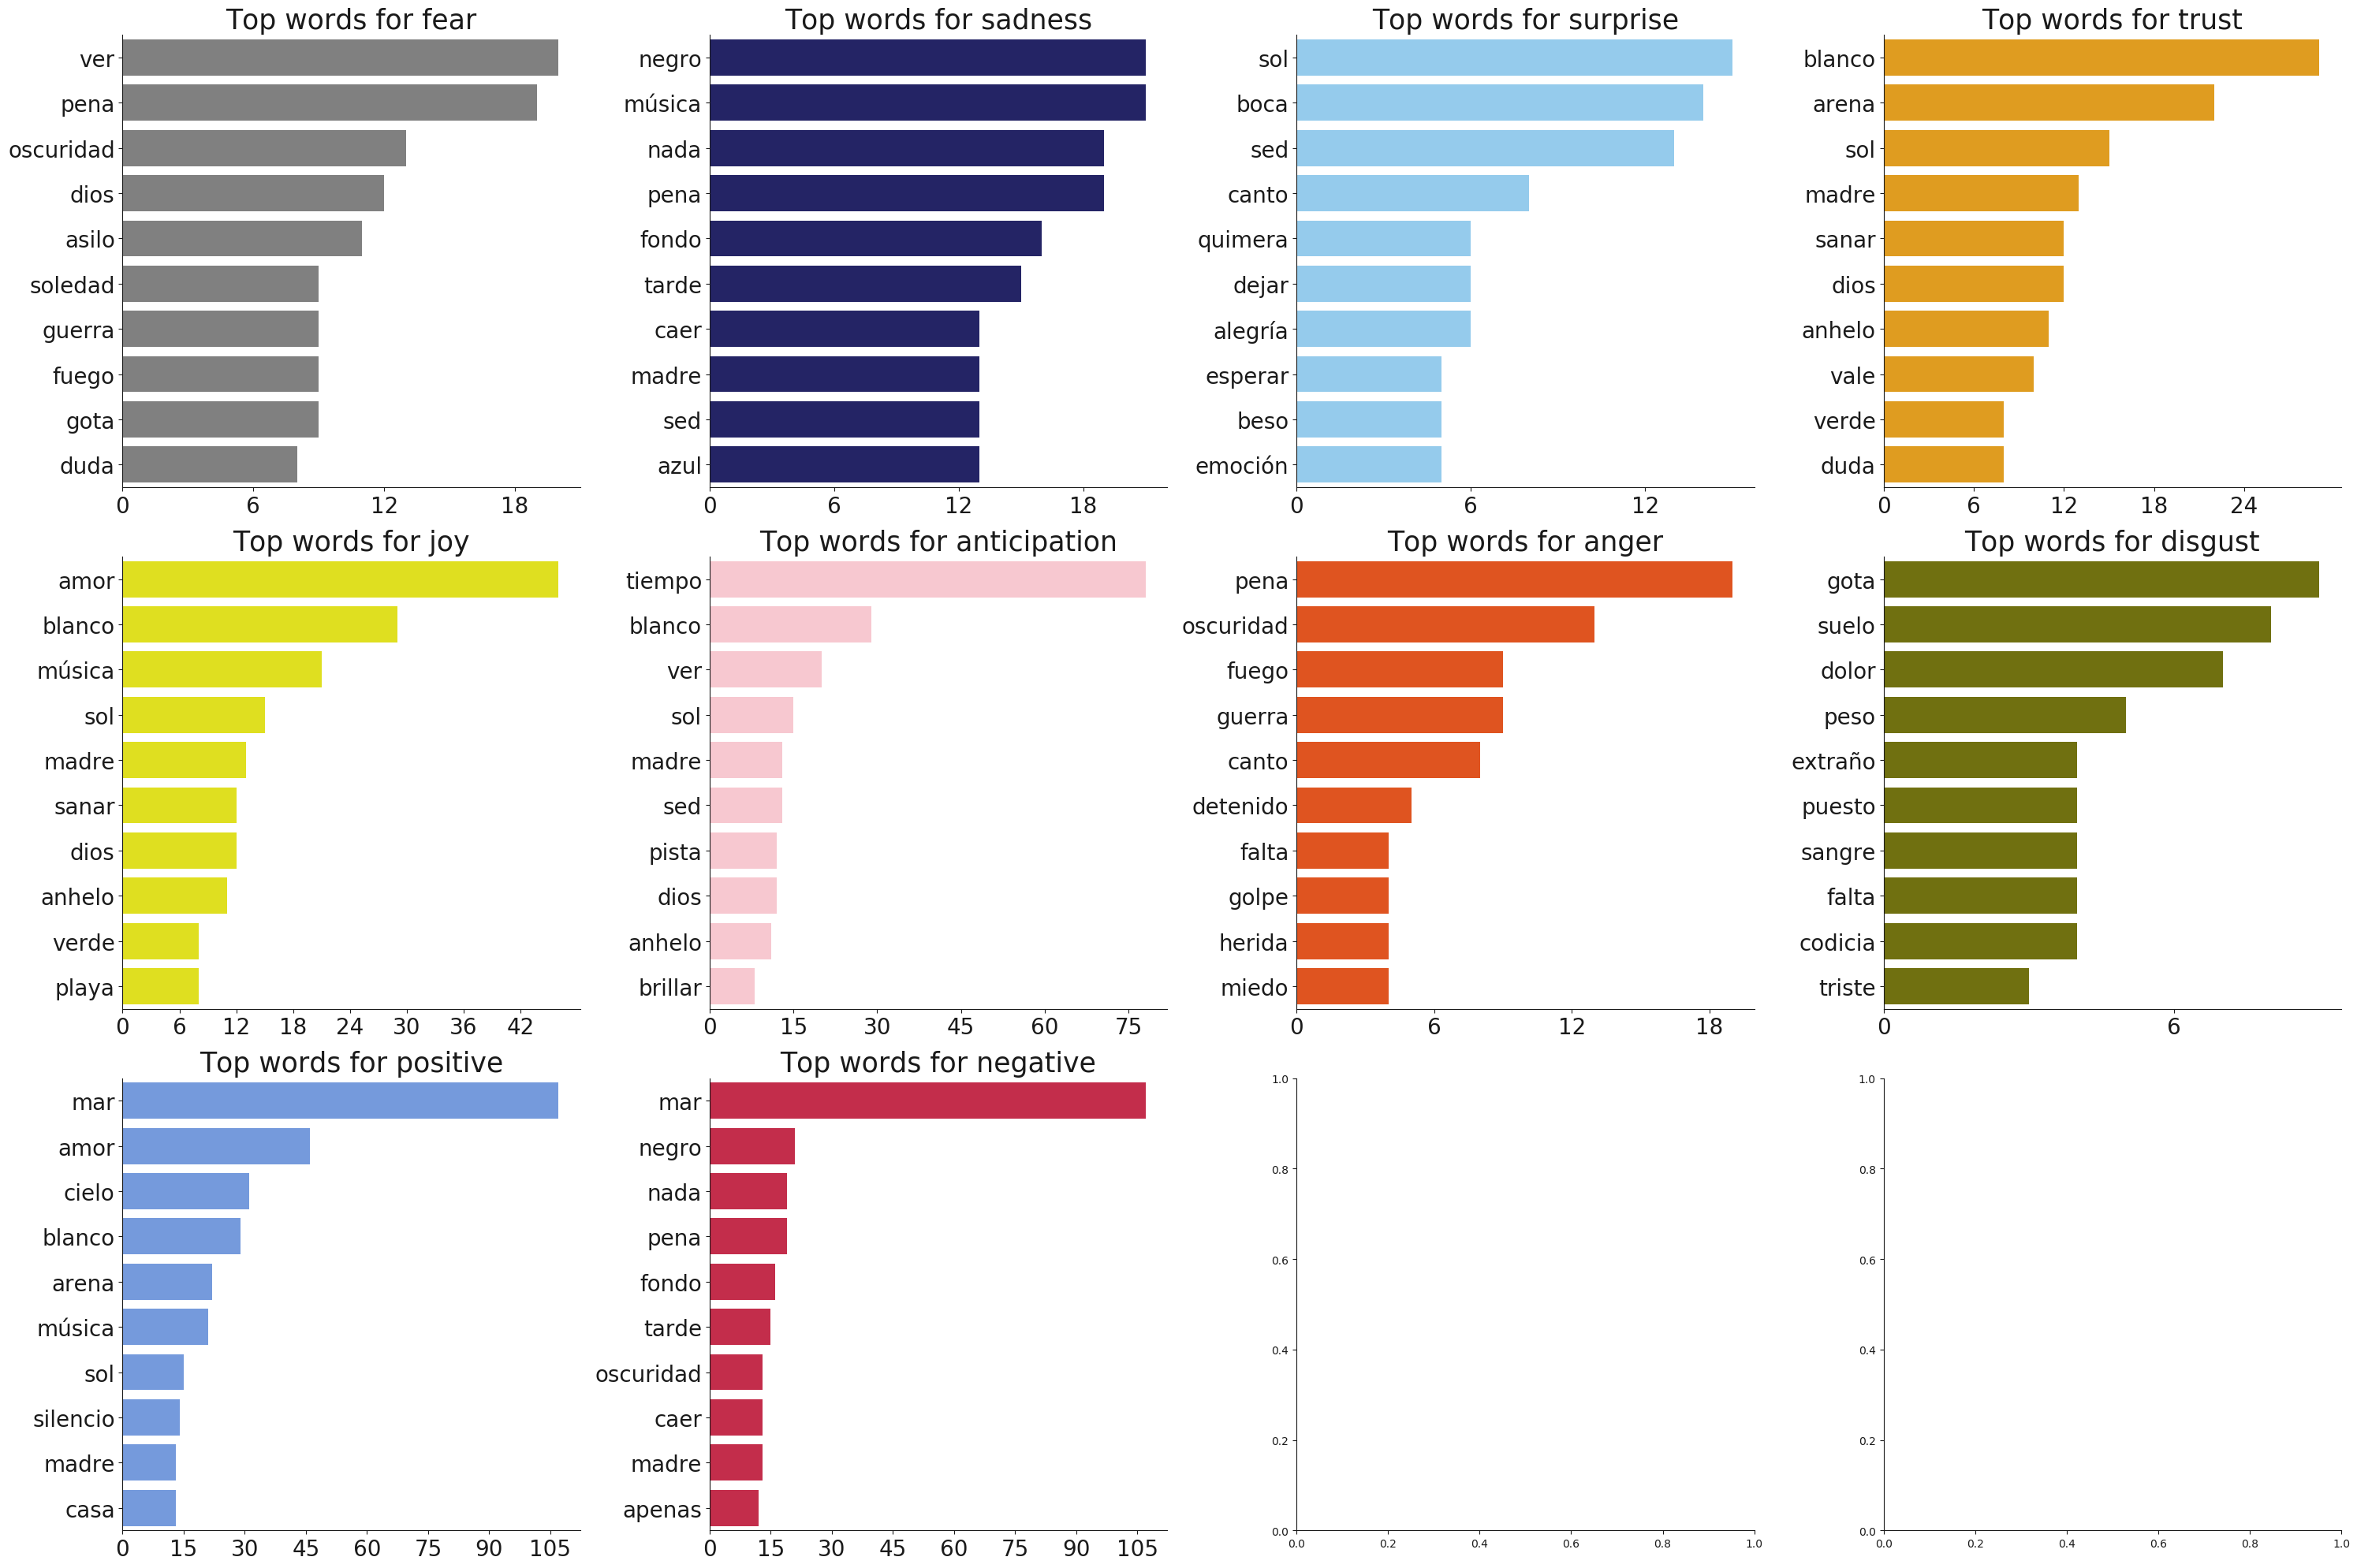

In [46]:
ROWS = 3
COLS = 4
cols_to_iterate = columns[1:]
colors = ['grey', 'midnightblue', 'lightskyblue', 'orange', 'yellow', 'pink', 'orangered', 'olive', 'cornflowerblue', 'crimson']
fig, axes = plt.subplots(nrows=ROWS, ncols=COLS, figsize=(30,20))
words_which_appear = []
for row in range(ROWS):
    for col in range(COLS):
        if not cols_to_iterate:
            break
        a_column = cols_to_iterate.pop(0)
        a_color = colors.pop(0)
        a_df = pd.DataFrame(word_appearances_by_sentiment.sort_values(by=[a_column], ascending=False)[a_column][:10])
        words_which_appear.extend(a_df.index)
        a_df.columns = ['count']
        sns.barplot(a_df['count'], a_df.index,orient='h', color=a_color, ax=axes[row, col])
        axes[row, col].set_title('Top words for %s' % a_column, fontsize=25)
        if max(a_df['count']) > 50:
            axes[row, col].set_xticks(range(0,max(a_df['count']), 15))
        else:
            axes[row, col].set_xticks(range(0,max(a_df['count']), 6))
        for tick in axes[row, col].xaxis.get_major_ticks():
            tick.label.set_fontsize(20) 
        for tick in axes[row, col].yaxis.get_major_ticks():
            tick.label.set_fontsize(20)
        axes[row, col].set_ylabel("")
        axes[row, col].set_xlabel("")

words_which_appear = Counter(words_which_appear)        
sns.despine()
plt.tight_layout()
plt.show()

In [47]:
words_which_appear.most_common(3)

[('madre', 6), ('sol', 5), ('pena', 4)]

 - 'Madre' (mother) appears in trust, joy and anticipation. Marked both positive and negative.
 - 'Sol' (sun) appears related to positive emotions: surprise, trust, joy, anticipation and is only marked as positive sentiment.
 - 'Pena' (pity, shame) appear in negative emotions: fear, sadness, anger and is marked as a negative sentiment only.


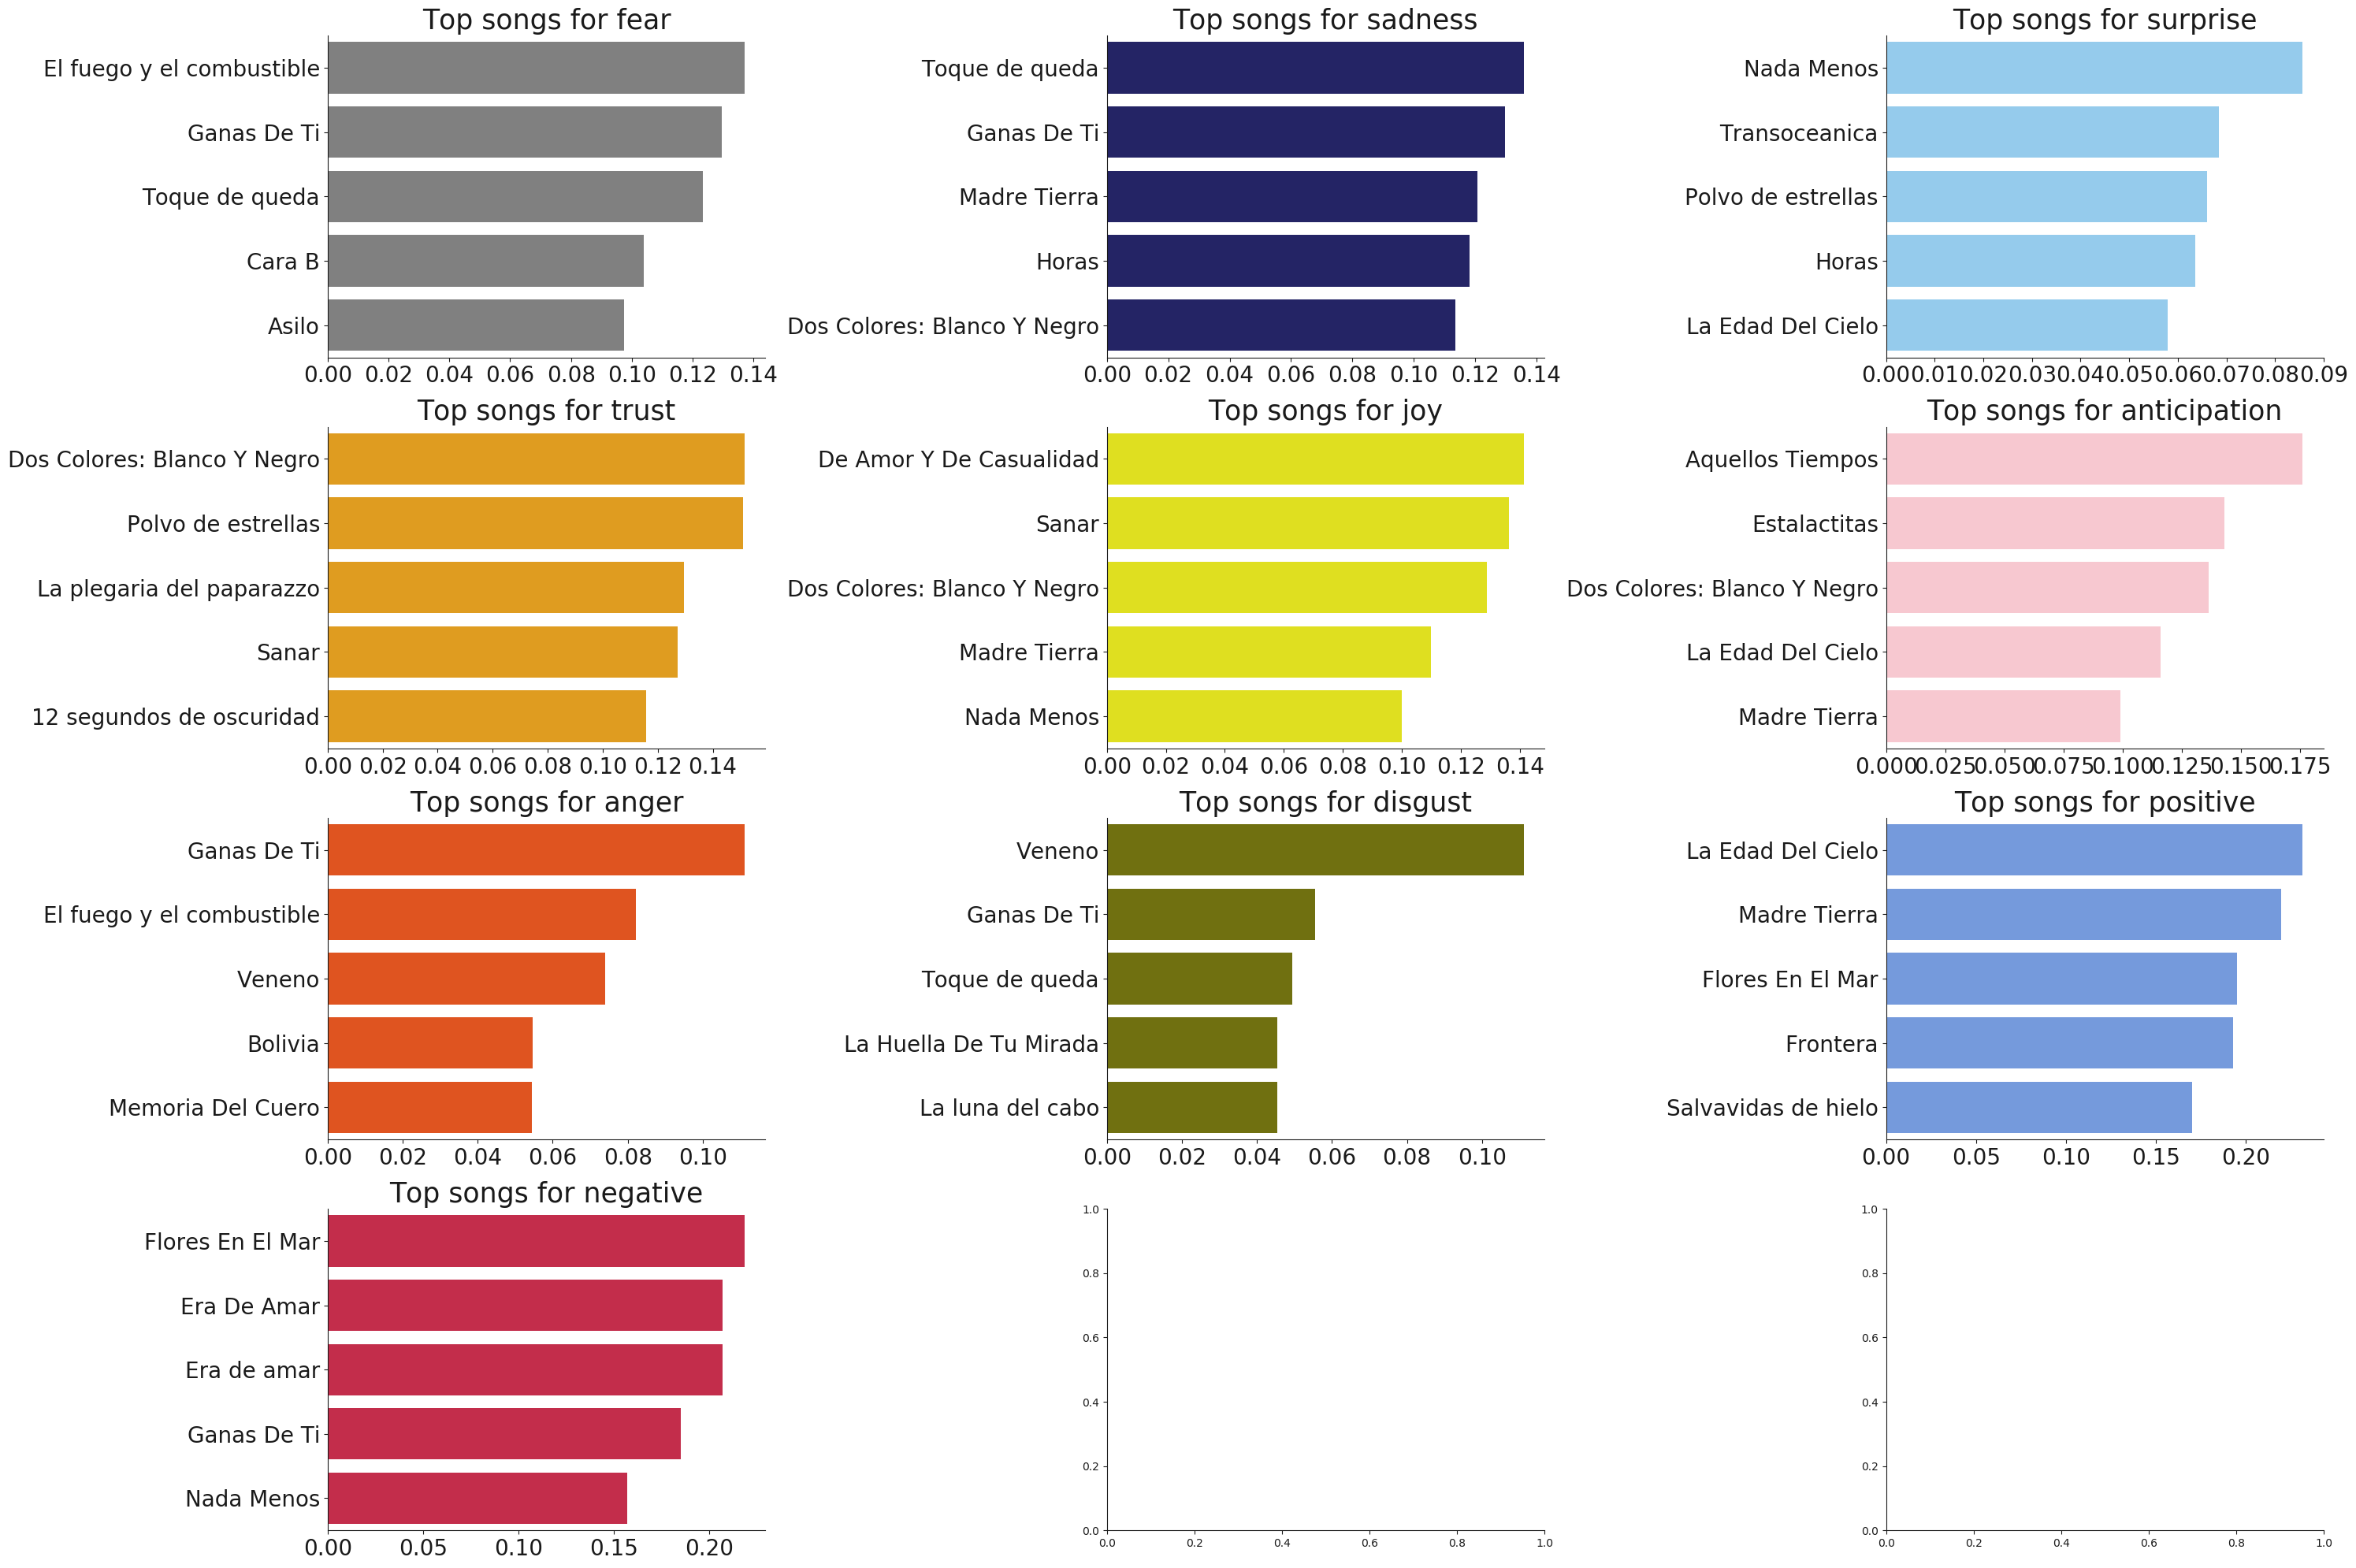

In [48]:
ROWS = 4
COLS = 3
cols_to_iterate = columns[1:]
colors = ['grey', 'midnightblue', 'lightskyblue', 'orange', 'yellow', 'pink', 'orangered', 'olive', 'cornflowerblue', 'crimson']
fig, axes = plt.subplots(nrows=ROWS, ncols=COLS, figsize=(30,20))
songs_which_appear = []
for row in range(ROWS):
    for col in range(COLS):
        if not cols_to_iterate:
            break
        a_column = cols_to_iterate.pop(0)
        a_color = colors.pop(0)
        a_df = pd.DataFrame(df.sort_values(by=[a_column], ascending=False)[['name',a_column]][:5])
        songs_which_appear.extend(a_df.name)
        sns.barplot(a_df[a_column], a_df.name, orient='h', color=a_color, ax=axes[row, col])
        axes[row, col].set_title('Top songs for %s' % a_column, fontsize=25)
        axes[row, col].set_xticks(range(0, int(max(a_df[a_column]))), max(a_df[a_column]) / 8)
        for tick in axes[row, col].xaxis.get_major_ticks():
            tick.label.set_fontsize(20) 
        for tick in axes[row, col].yaxis.get_major_ticks():
            tick.label.set_fontsize(20)
        axes[row, col].set_ylabel("")
        axes[row, col].set_xlabel("")

songs_which_appear = Counter(songs_which_appear)        
sns.despine()
fig.tight_layout()
plt.show()

In [49]:
songs_which_appear.most_common(5)

[('Ganas De Ti', 5),
 ('Madre Tierra', 4),
 ('Dos Colores: Blanco Y Negro', 4),
 ('Toque de queda', 3),
 ('Nada Menos', 3)]

The song "Ganas de ti" (could be roughly translated to "desire of you") talks about somebody a guy yearning for a girl which, i dare saying, is apparently not in the same page. It's related to a negative sentiment and fear, anger, disgust and sadness emotions. While listening to the song its really hard for me to feel all of that, but the analysis is solely done on the lyrics.

In [86]:
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/YqUHUg74Cq4?showinfo=0" frameborder="0" allowfullscreen></iframe>')

Now, let's do the album analysis. We can create a special DataFrame just for that.

In [51]:
albums_ordered_by_year = [
    'La Luz Que Sabe Robar', 'Radar', 'Vaivén', 
    'Llueve', 'Frontera', 'Sea', 
    'Eco', '12 segundos de oscuridad','Amar la trama',
    'Bailar en la cueva', 'Salvavidas de hielo'
]
years_for_albums = [
    1992, 1994, 1996, 1997, 1999, 
    2001, 2004, 2006, 2010, 2014, 
    2017
]

colormap = {
    'fear': 'grey', 
    'sadness': 'midnightblue', 
    'surprise': 'lightskyblue', 
    'trust': 'orange', 
    'joy': 'yellow', 
    'anticipation': 'pink', 
    'anger': 'orangered', 
    'disgust': 'olive', 
    'positive': 'cornflowerblue', 
    'negative': 'crimson'
}


emotions=['fear', 'sadness', 'surprise', 'trust', 'joy', 'anticipation', 'anger', 'disgust']
sentiments=['positive', 'negative']
albums_by_emotion = pd.DataFrame(columns=['album', 'year'] + emotions + sentiments)

for an_album, a_year in zip(albums_ordered_by_year, years_for_albums):
    some_albums_emotions = pd.DataFrame(df[df['album'] == an_album].sum()[emotions])
    some_albums_sentiments = pd.DataFrame(df[df['album'] == an_album].sum()[sentiments])
    row = [an_album, a_year] + list(some_albums_emotions[0].values) + list(some_albums_sentiments[0].values)
    appending_df = pd.DataFrame([row], columns=['album', 'year'] + emotions + sentiments)
    albums_by_emotion = albums_by_emotion.append(appending_df)
albums_by_emotion = albums_by_emotion.reset_index(drop=True)
albums_by_emotion

album  year      fear   sadness  surprise     trust  \
0      La Luz Que Sabe Robar  1992  0.203686  0.385296  0.155135  0.284536   
1                      Radar  1994  0.276221  0.539762  0.248387  0.342851   
2                     Vaivén  1996  0.374724  0.719195  0.143359  0.381474   
3                     Llueve  1997  0.320040  0.340336  0.090775  0.304329   
4                   Frontera  1999  0.362460  0.403787  0.211708  0.432888   
5                        Sea  2001  0.276593  0.386082  0.303028  0.481634   
6                        Eco  2004  0.278267  0.300399  0.328133  0.528648   
7   12 segundos de oscuridad  2006  0.441877  0.487261  0.138745  0.526699   
8              Amar la trama  2010  0.377031  0.430701  0.179193  0.290156   
9         Bailar en la cueva  2014  0.290060  0.309666  0.171506  0.455471   
10       Salvavidas de hielo  2017  0.328806  0.263476  0.231366  0.338228   

         joy  anticipation     anger   disgust  positive  negative  
0   0.358232      0.357719  0.178083  0.156379  0.603337  0.436929  
1   0.393322      0.522680  0.209822  0.181305  1.055875  0.946799  
2   0.361346      0.534869  0.251901  0.135175  0.979585  1.029696  
3   0.382169      0.357141  0.185393  0.143208  0.941885  0.860252  
4   0.424484      0.705346  0.217928  0.125652  1.195333  0.697377  
5   0.435938      0.309596  0.132745  0.090931  0.876404  0.704091  
6   0.468932      0.442141  0.202439  0.142790  0.787769  0.548452  
7   0.306674      0.377294  0.252825  0.141355  0.654582  0.744588  
8   0.213433      0.387376  0.130580  0.110726  0.528819  0.735744  
9   0.330000      0.410849  0.187282  0.197405  0.746761  0.624168  
10  0.318006      0.577648  0.106819  0.081028  0.779145  0.444571

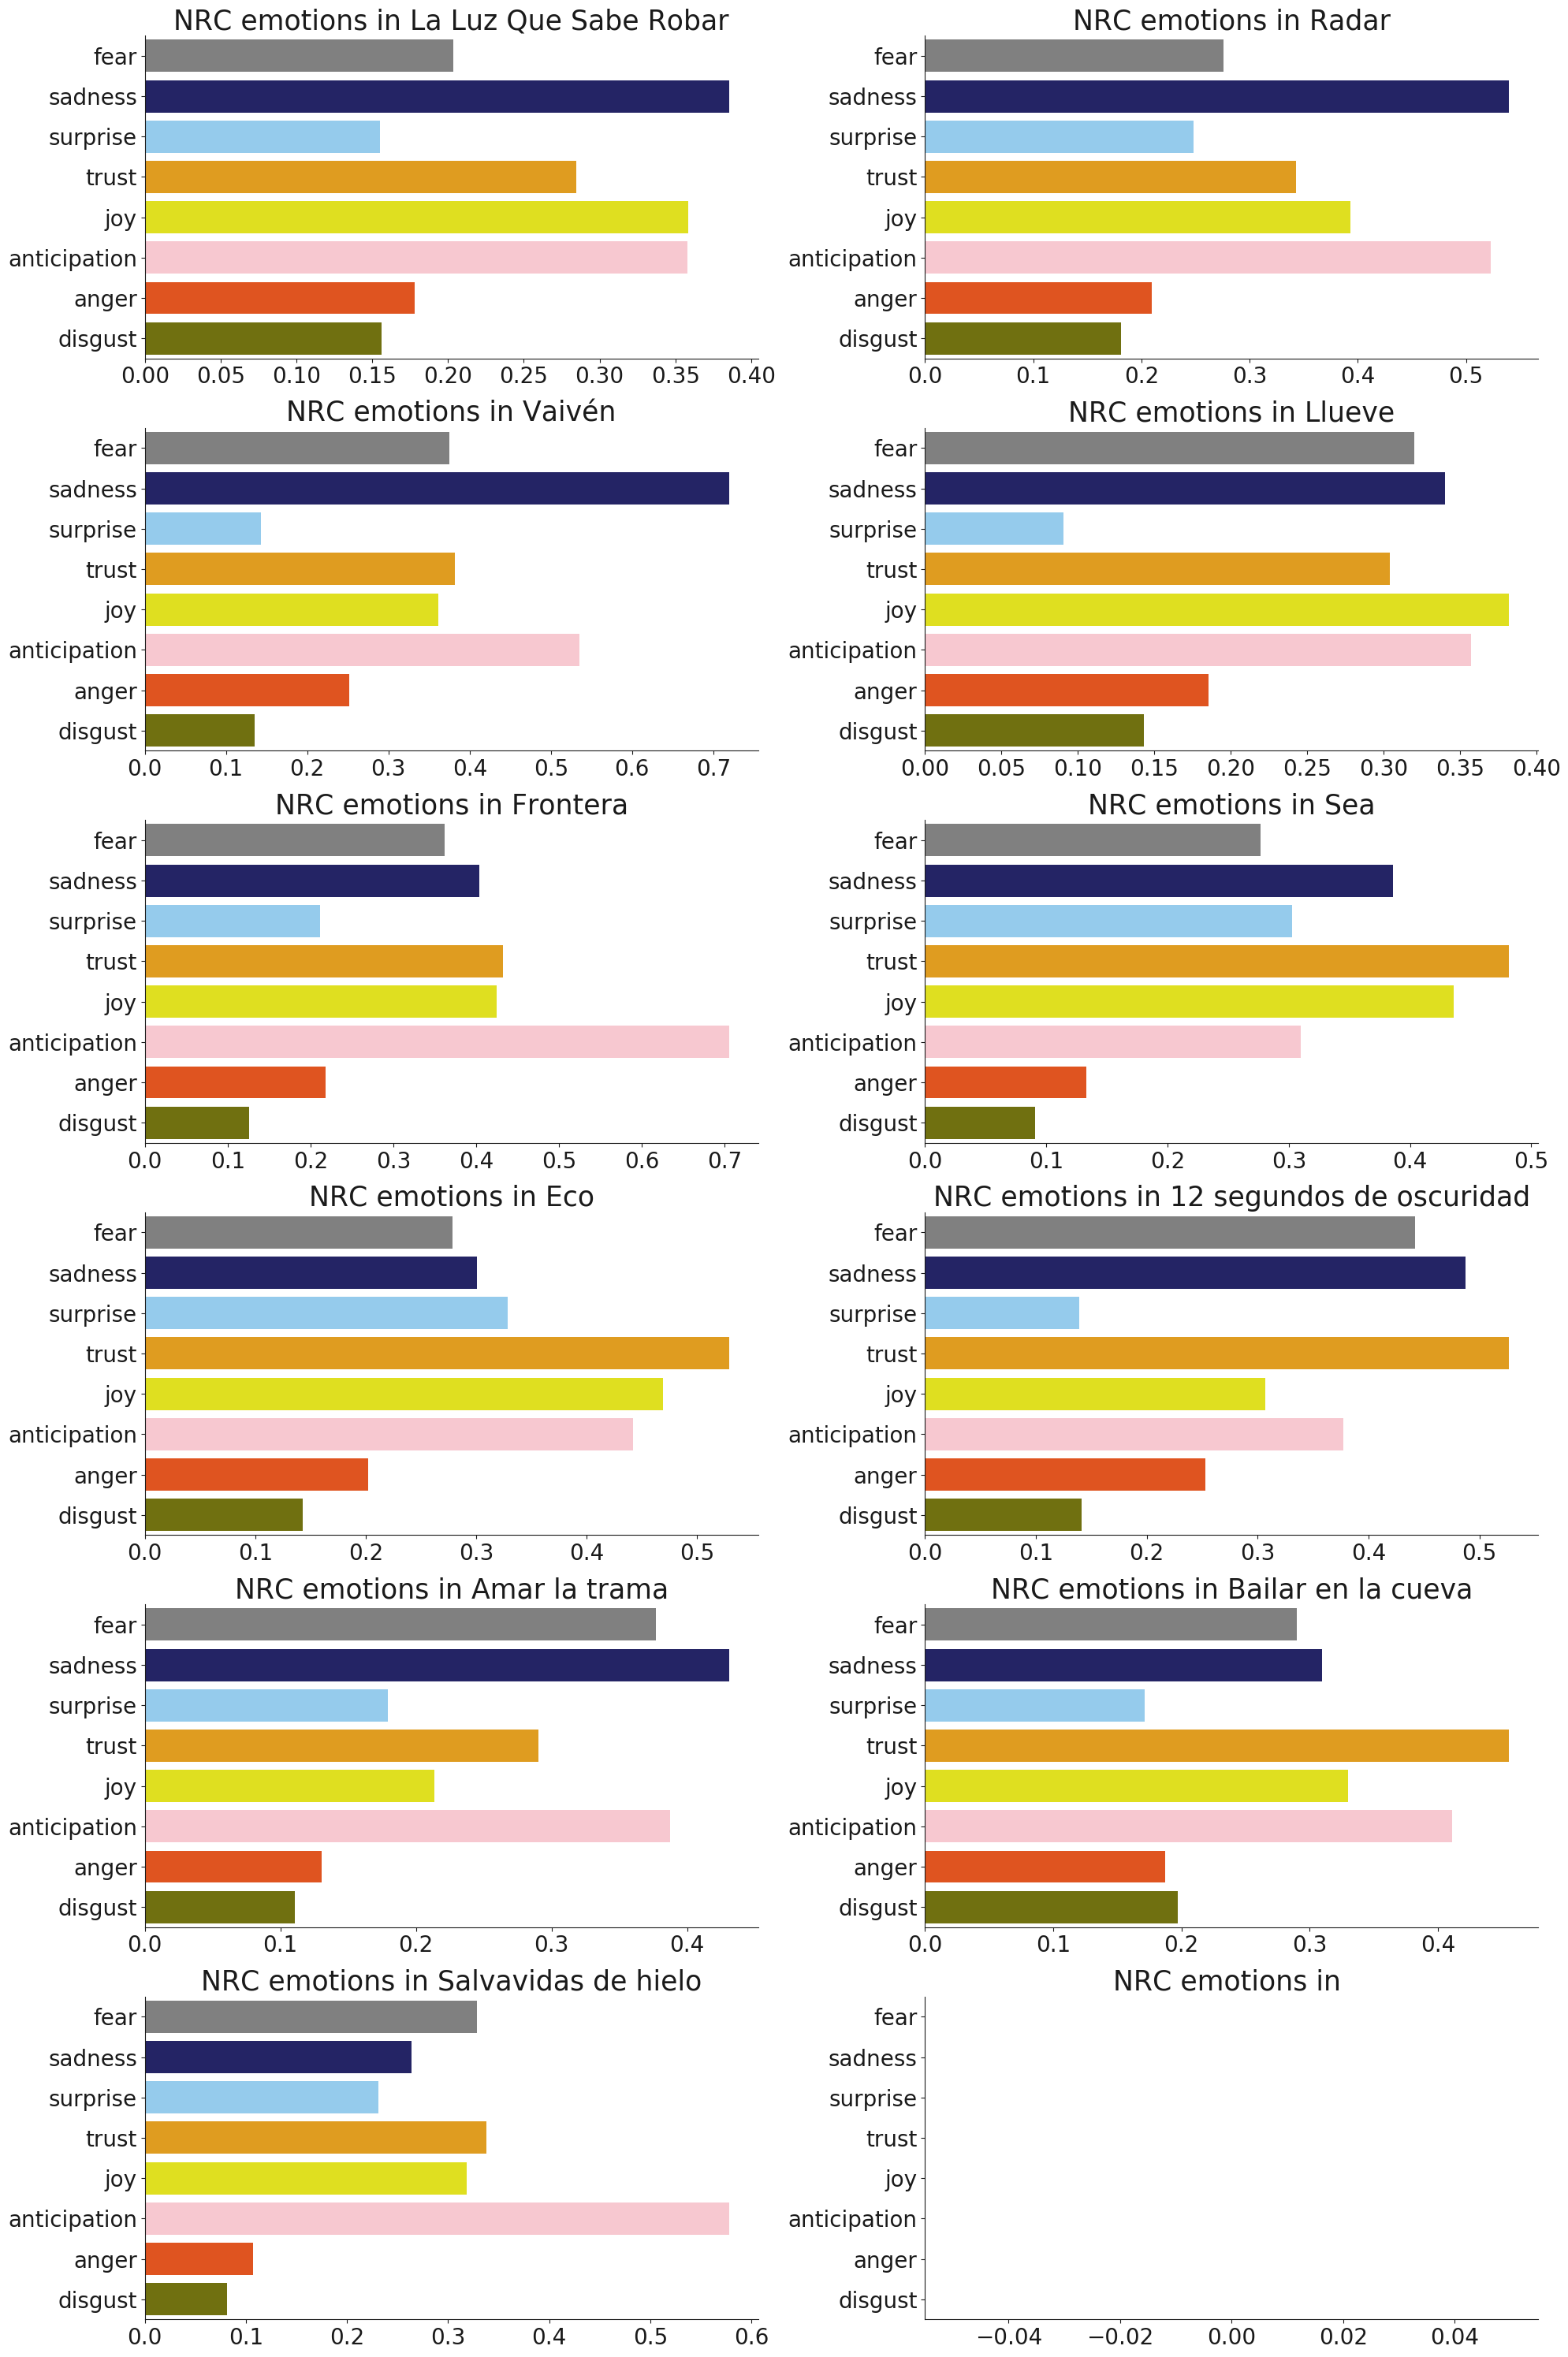

In [52]:
ROWS = 6
COLS = 2
albums_ordered_by_year = [
    'La Luz Que Sabe Robar', 'Radar', 'Vaivén', 
    'Llueve', 'Frontera', 'Sea', 
    'Eco', '12 segundos de oscuridad','Amar la trama',
    'Bailar en la cueva', 'Salvavidas de hielo', ""
]
cols_to_iterate = albums_ordered_by_year
fig, axes = plt.subplots(nrows=ROWS, ncols=COLS, figsize=(20,30))
for row in range(ROWS):
    for col in range(COLS):

        an_album = cols_to_iterate.pop(0)
        
        total_sentiments = pd.DataFrame(df[df['album'] == an_album].sum()[['fear', 'sadness', 'surprise', 'trust', 'joy', 'anticipation', 'anger', 'disgust']])
        total_sentiments.columns = ['value']
        sns.barplot(
            y=total_sentiments.index, 
            x='value', 
            orient='h', 
            data=total_sentiments, 
            ax=axes[row, col], 
            #hue=total_sentiments.index,
            palette=colormap
        )

        axes[row, col].set_title('NRC emotions in %s' % an_album, fontsize=25)
        for tick in axes[row, col].xaxis.get_major_ticks():
            tick.label.set_fontsize(20) 
        for tick in axes[row, col].yaxis.get_major_ticks():
            tick.label.set_fontsize(20)
        axes[row, col].set_ylabel("")
        axes[row, col].set_xlabel("")
        
sns.despine()
plt.tight_layout()
plt.show()


- His saddest album is Vaivén, from 1996. I was pretty sure it was 12 segundos de oscuridad, actually... at least that's the one I like to listen while sad :)
- Anticipation in Frontera, from 1997, and his latest Salvavidas de Hielo are the highest (2017).

Let's check in a different graph how all this evolve through the years.

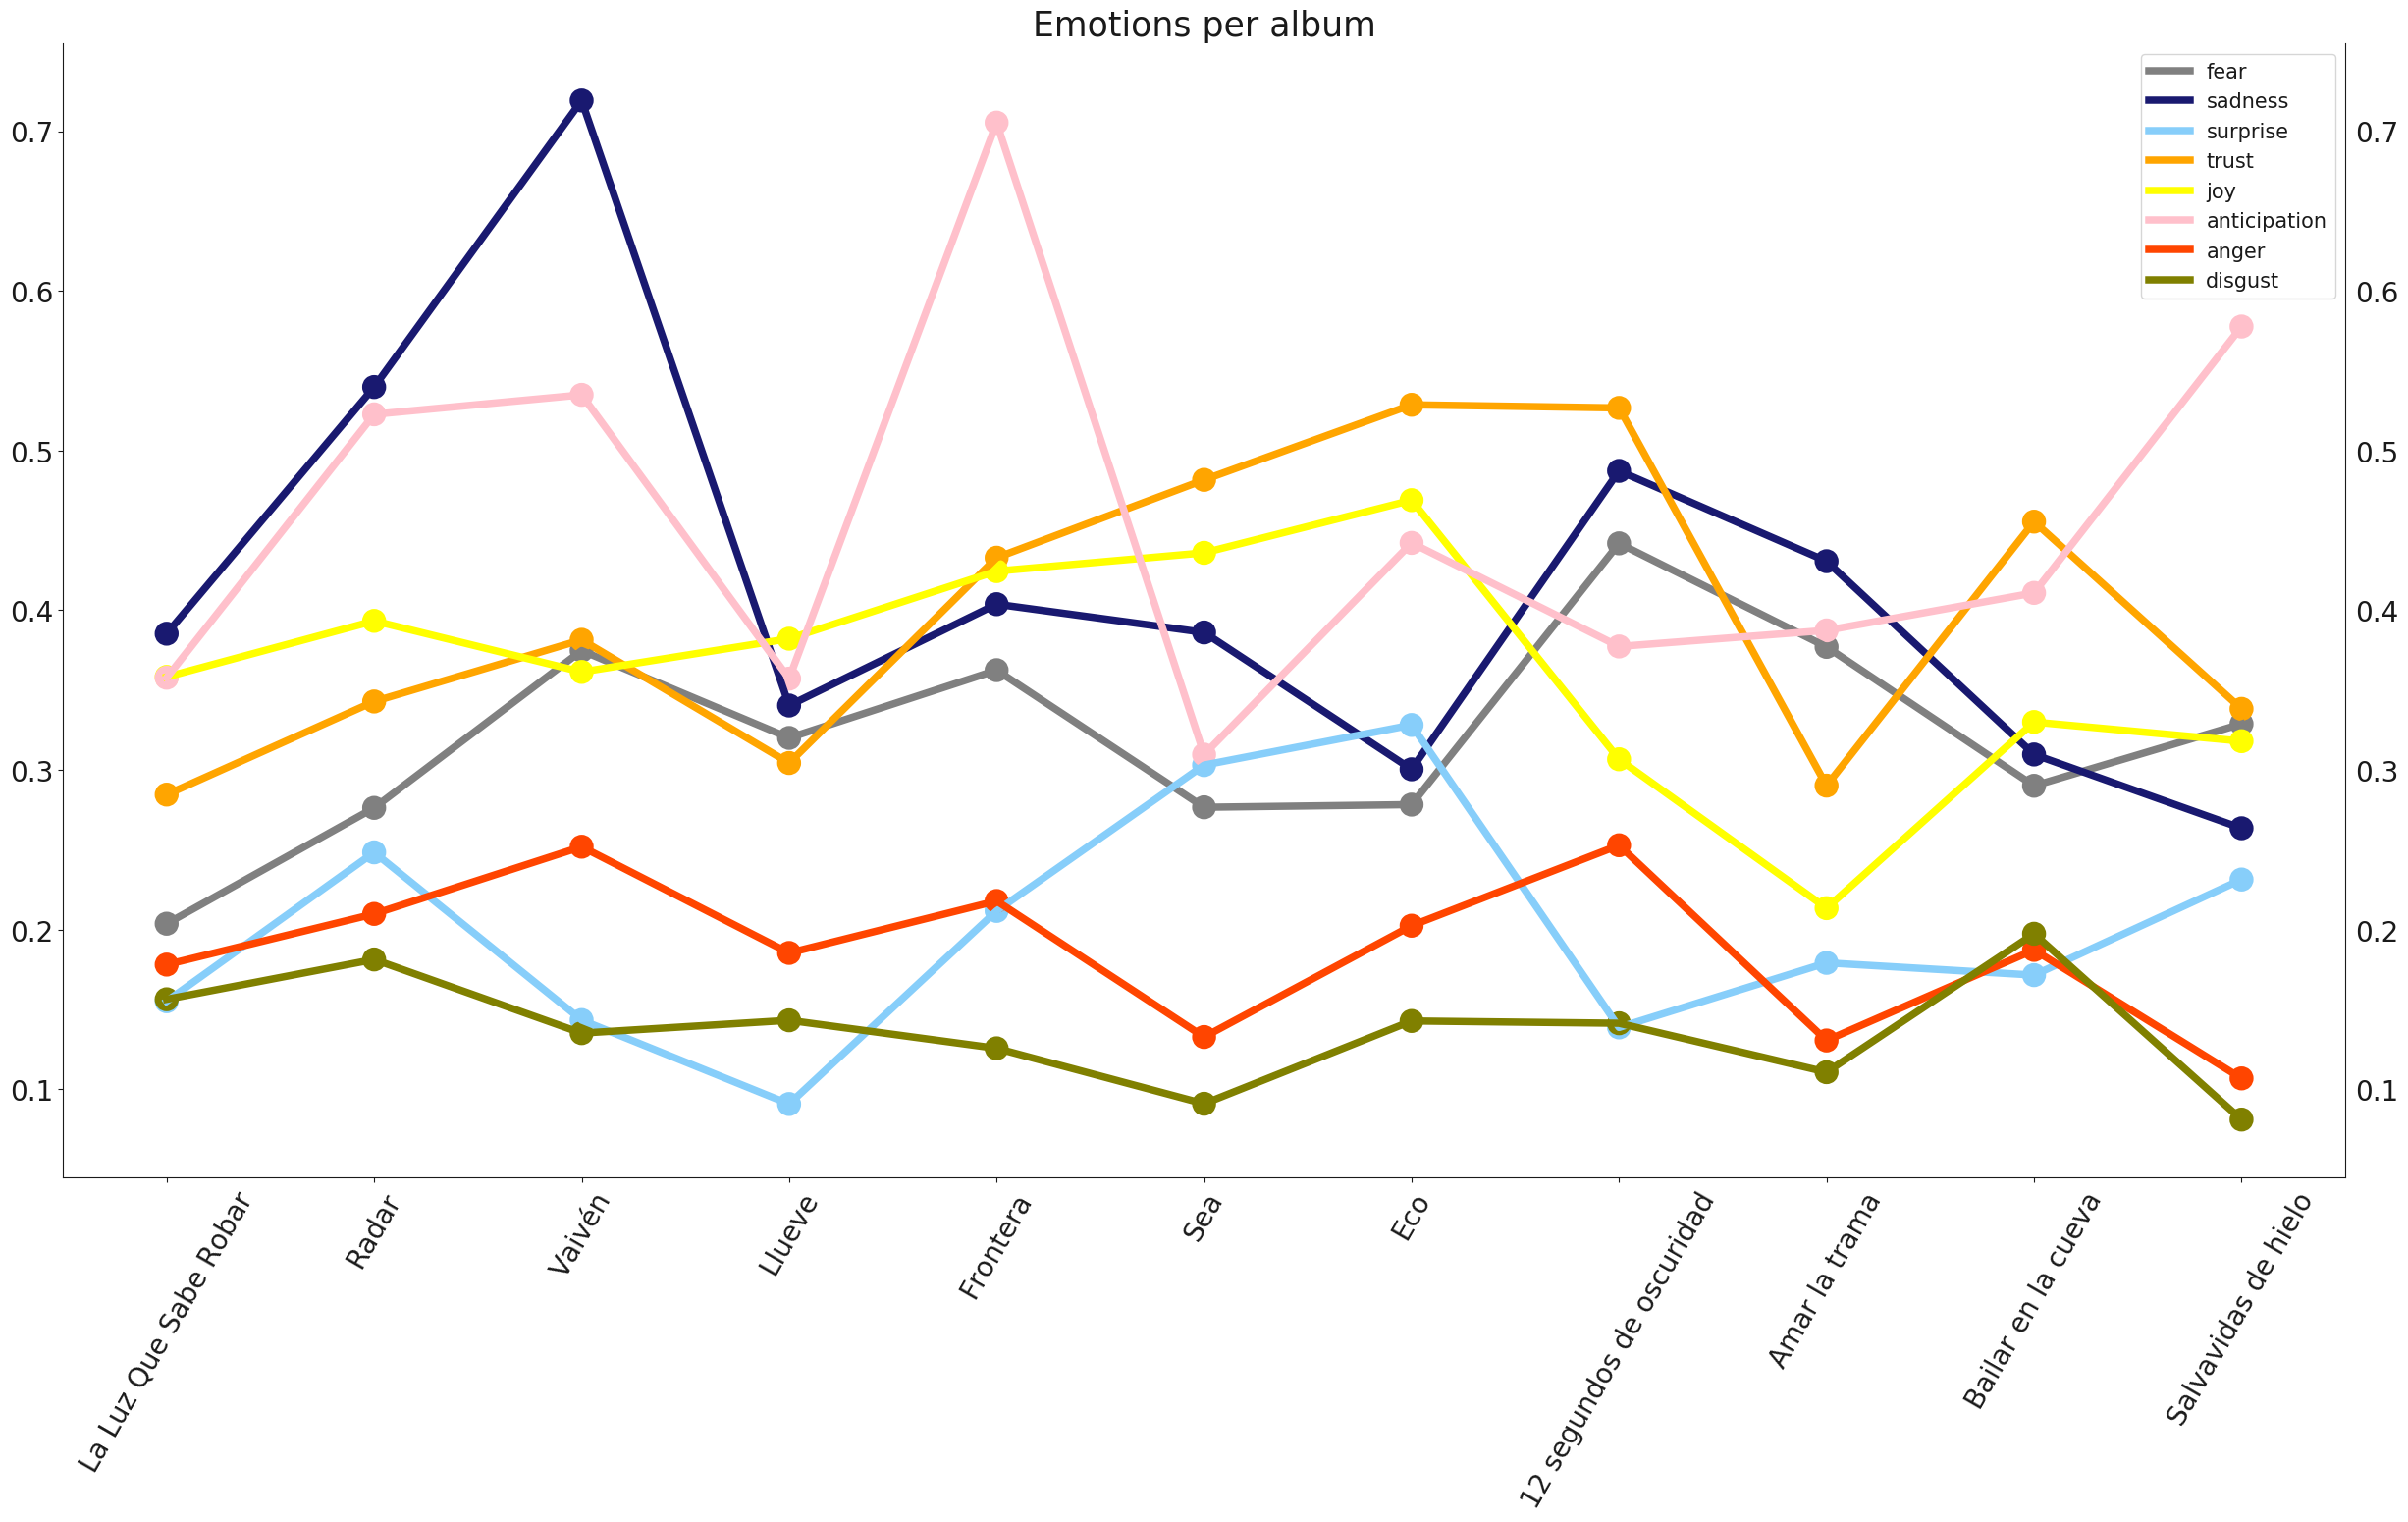

In [53]:
fig, ax = plt.subplots(figsize=(30,15))
for an_emotion in emotions:
    sns.pointplot(x="album", y=an_emotion, data=albums_by_emotion, color=colormap[an_emotion], scale=2,)
ax.spines["top"].set_visible(False)
plt.tick_params(axis='both', labelright=True, labelsize=20)
ax.set_title("Emotions per album", fontdict={'fontsize': 25})
plt.ylabel("")
plt.xlabel('')
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
    tick.label.set_rotation(60)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
    
ax.legend(handles=ax.lines[::len(albums_by_emotion)+1], labels=emotions, prop={'size': 15})
plt.show();

- Well, it's safe to say that, except for the bump in 12 segundos de oscuridad, Jorge has gotten less sad.
- His joy, though, peaked in Eco and never quite recovered from that bump.
- Peakes of anger in Vaivén and 12 segundos de oscuridad. His saddest albums.
- Negative emotions (anger, sadness, disgust, fear) seem to have some kind of correlation. Let's dig deeper.

To check correlation I'm going to use both the pairplot tool in Seaborn and calculate each pair of variable's pearson coefficient.

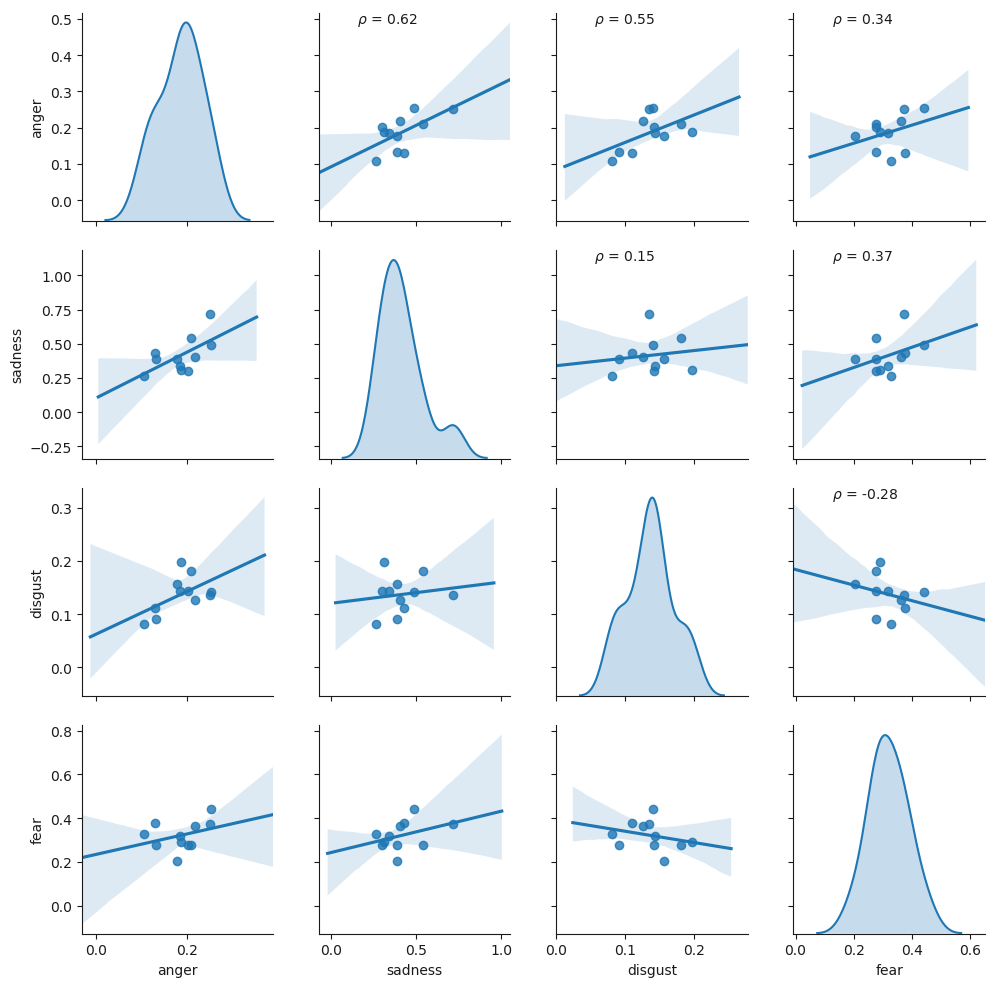

In [54]:
# Function to calculate correlation coefficient between two arrays
def corr(x, y, **kwargs):
    
    # Calculate the value
    coef = np.corrcoef(x, y)[0][1]
    # Make the label
    label = r'$\rho$ = ' + str(round(coef, 2))
    
    # Add the label to the plot
    ax = plt.gca()
    ax.annotate(label, xy = (0.2, 0.95), size = 10, xycoords = ax.transAxes)

g = sns.pairplot(albums_by_emotion, kind="reg", vars=["anger", "sadness", 'disgust', 'fear'], diag_kind="kde")
g = g.map_upper(corr)
plt.show();

Like my first suspicion, sadness and anger are heavily correlated. Also anger and disgust.
Let's graph quick to appreciate the shape of their curves alone.

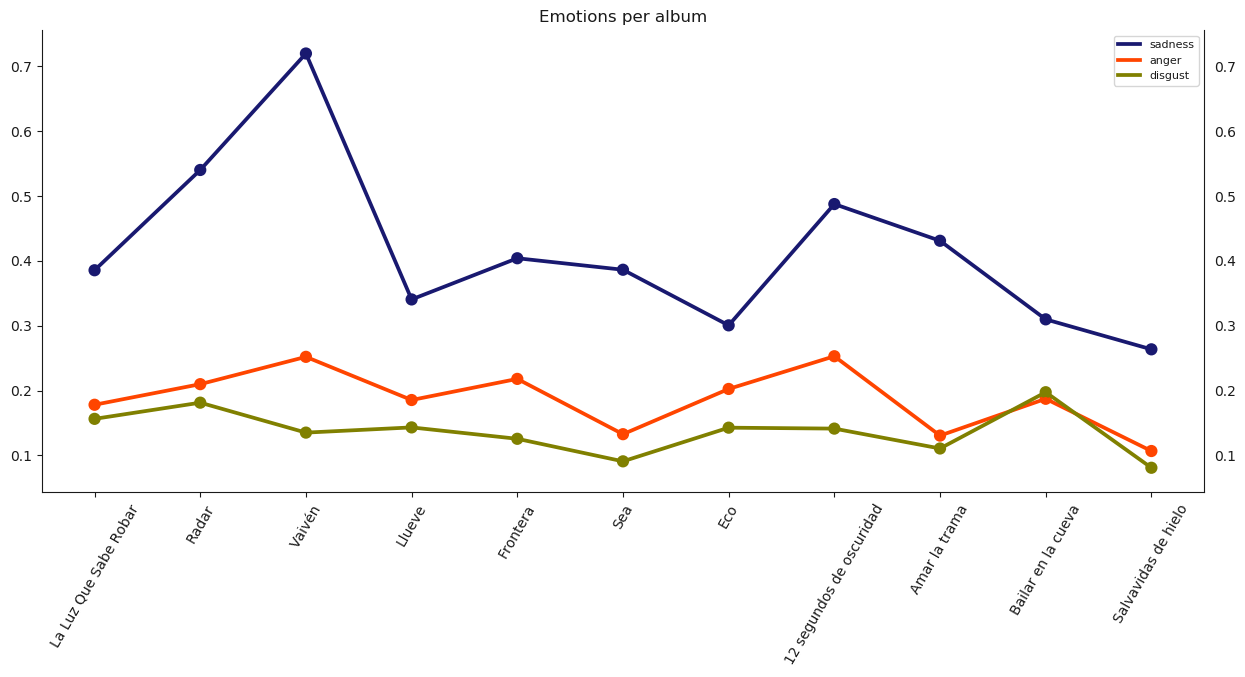

In [55]:
fig, ax = plt.subplots(figsize=(15,6))
for an_emotion in ['sadness', 'anger', 'disgust']:
    sns.pointplot(x="album", y=an_emotion, data=albums_by_emotion, color=colormap[an_emotion], scale=1)
ax.spines["top"].set_visible(False)
plt.tick_params(axis='both', labelright=True, labelsize=10)
ax.set_title("Emotions per album", fontdict={'fontsize': 12})
plt.ylabel("")
plt.xlabel('')
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(10) 
    tick.label.set_rotation(60)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(10)
    
ax.legend(handles=ax.lines[::len(albums_by_emotion)+1], labels=['sadness', 'anger', 'disgust'], prop={'size': 8})
plt.show();

## Indeed, with Jorge's songs, it's fairly accurate to say that sadness comes hand in hand with their share of anger and disgust.

Now, let's go into straight positive vs negative sentiments.

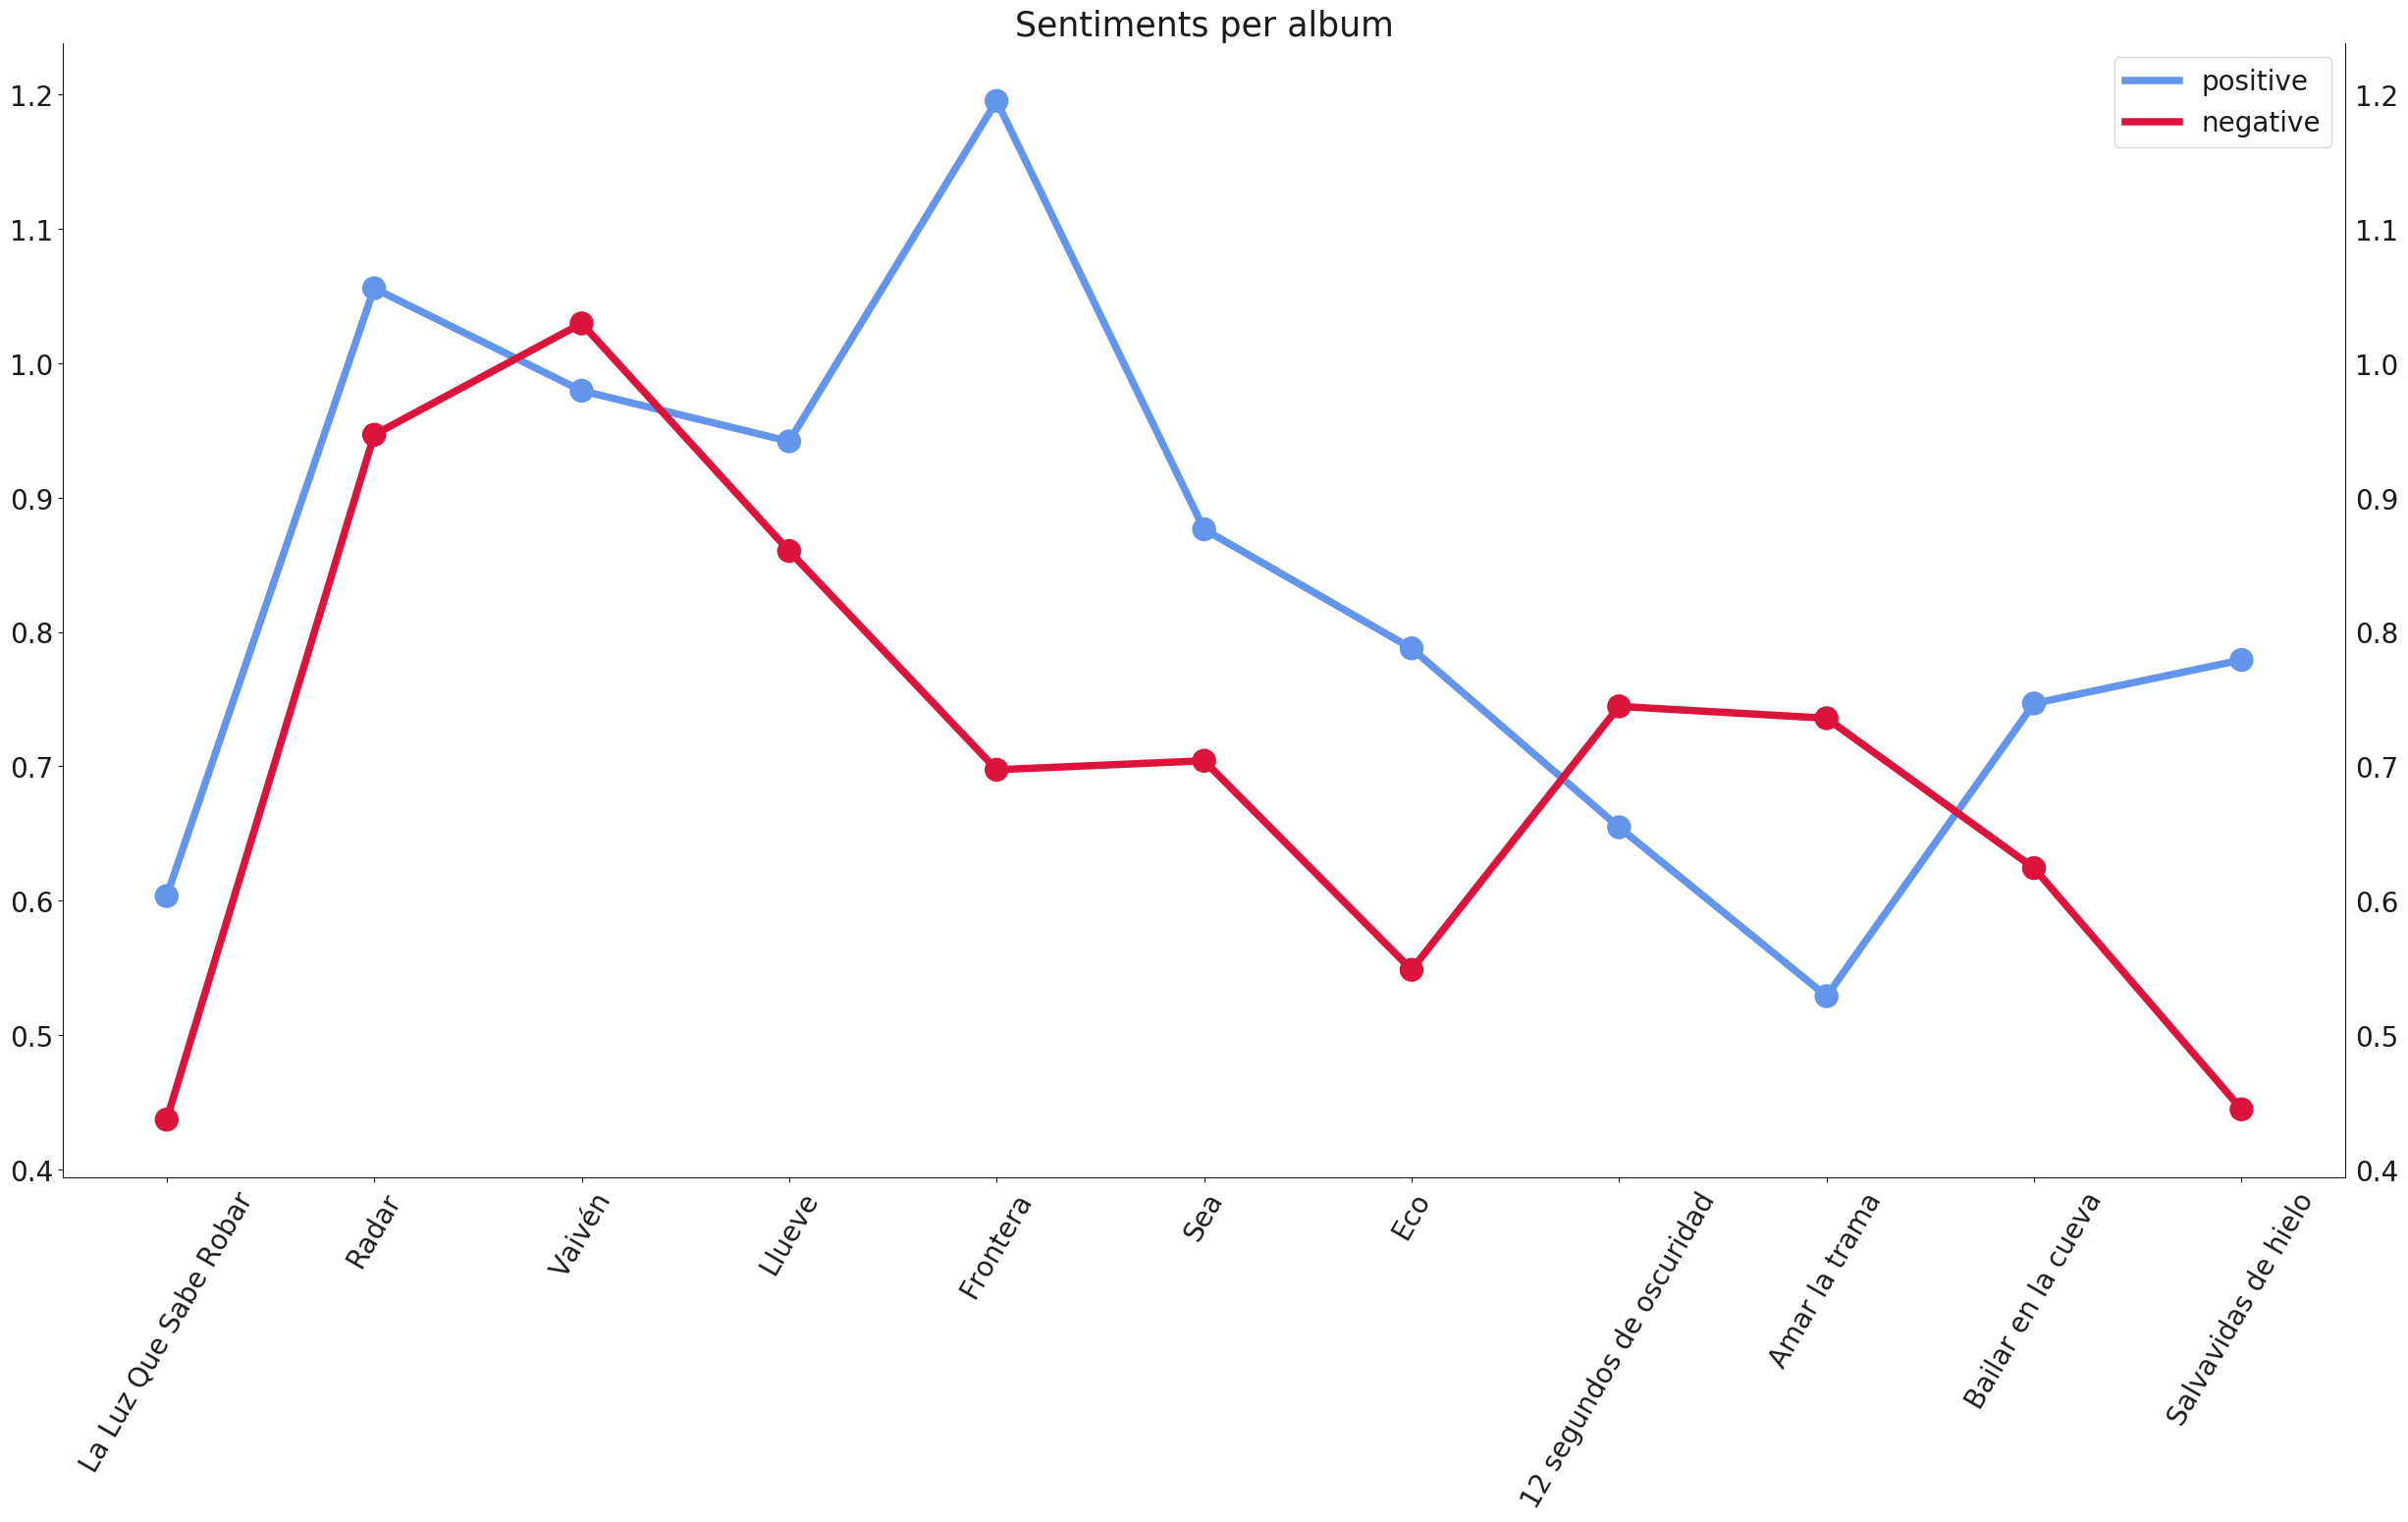

In [56]:
fig, ax = plt.subplots(figsize=(30,15))
for a_sentiment in sentiments:
    sns.pointplot(x="album", y=a_sentiment, data=albums_by_emotion, color=colormap[a_sentiment], scale=2,)
ax.spines["top"].set_visible(False)
plt.tick_params(axis='both', labelright=True, labelsize=20)
ax.set_title("Sentiments per album", fontdict={'fontsize': 25})
plt.ylabel("")
plt.xlabel('')
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
    tick.label.set_rotation(60)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
    
ax.legend(handles=ax.lines[::len(albums_by_emotion)+1], labels=sentiments, prop={'size': 20})
plt.show();

### I think it's pretty safe, at this point, to affirm again that Jorge is more of a positive than negative kind of guy.
- His peak of positiveness is in Frontera (1999) and his peak of negativeness happens three years before in Vaivén (1996).
- All time low for positiveness is in Amar la trama (2010).
- His lowest for negativeness happens both at the start and end of his career. (Ok, not end... let's hope he keeps making beautiful music)
- **Sadder than happier albums: Vaivén (1996), 12 segundos de oscuridad (2006) and Amar la trama (2010).**

## Spotify data and musical analysis

Using Spotify's API I was able to extract musical features for each of the songs. 
To check a detailed description of each of the features, visit [this](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/)

All of those are calculated using machine learning and signal processing techniques, so are not 100% accurate.

In [57]:
spoti_df = df[['name', 'album', 'acousticness', 'danceability', 'energy', 'key', 'tempo',
       'time_signature', 'valence', 'mode']]

In [58]:
spoti_df.head()

name                album  acousticness  \
index                                                                      
0                          Movimiento  Salvavidas de hielo         0.900   
1                           Telefonía  Salvavidas de hielo         0.829   
2                            Silencio  Salvavidas de hielo         0.263   
3      Pongamos que hablo de Martínez  Salvavidas de hielo         0.893   
4                        Estalactitas  Salvavidas de hielo         0.797   

       danceability  energy  key    tempo  time_signature  valence  mode  
index                                                                     
0             0.784   0.457  2.0  125.021             4.0    0.546   1.0  
1             0.915   0.592  6.0  126.060             4.0    0.841   0.0  
2             0.887   0.568  4.0  127.923             4.0    0.127   0.0  
3             0.849   0.458  9.0  119.950             4.0    0.461   1.0  
4             0.772   0.630  0.0  136.019             4.0    0.909   1.0

### Time signature

See, if I look for the time signatures available, 5.0 and 1.0 are going to appear. I'm pretty sure Jorge Drexler doesn't have a song which contains 5 beats in each bar (like 5/4 for example).
Wtf would 1 mean?

In [59]:
spoti_df.time_signature.unique()

array([ 4.,  5.,  3.,  1.])

In [60]:
spoti_df[df['time_signature']==5]

name                album  acousticness  danceability  energy  key  \
index                                                                        
5      Asilo  Salvavidas de hielo         0.808         0.502   0.239  0.0   

         tempo  time_signature  valence  mode  
index                                          
5      127.484             5.0    0.367   1.0

See, Asilo is in a 3/4 time signature. Let's correct.

In [61]:
spoti_df.at[5, 'time_signature'] = 3.0

In [62]:
spoti_df[df['time_signature'] == 1]

name     album  acousticness  danceability  energy  key  \
index                                                                     
77     Alto El Fuego  Frontera         0.898         0.655   0.162  2.0   

        tempo  time_signature  valence  mode  
index                                         
77     82.264             1.0    0.649   1.0

Alto el fuego also definitely has 3 beats in a bar.

In [63]:
spoti_df.at[77, 'time_signature'] = 3.0

How is time signature distributed in his albums?

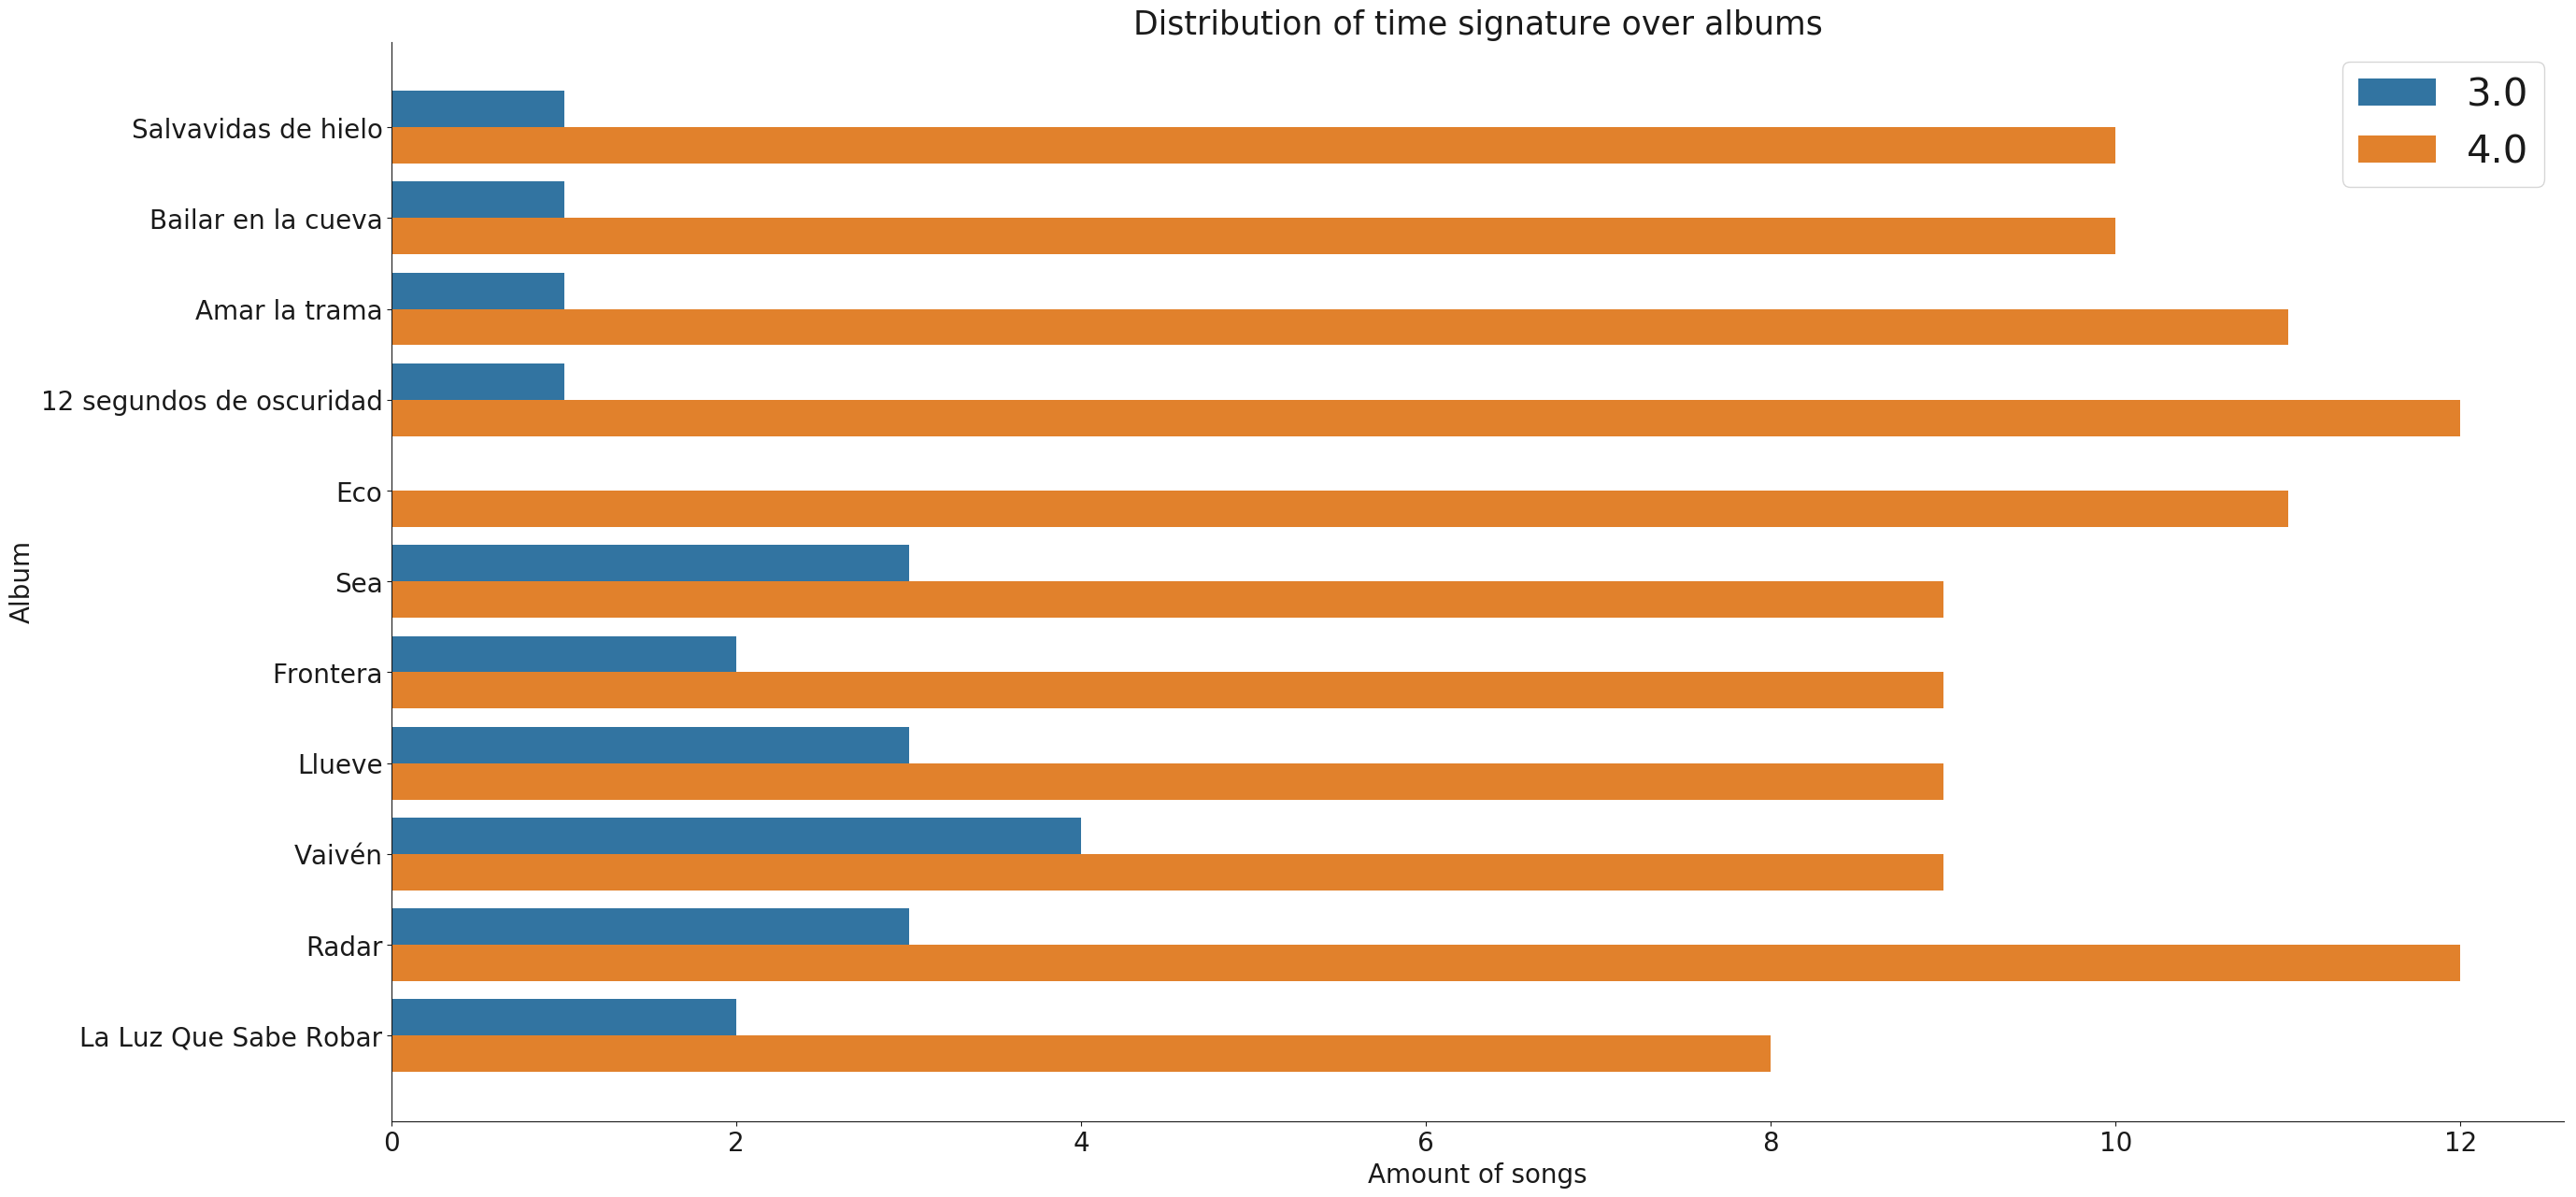

In [64]:
fig, ax = plt.subplots(figsize=(30,15))
ax = sns.countplot(y="album", orient='h', hue="time_signature", data=spoti_df)
plt.xlabel('Amount of songs', fontsize=20)
plt.ylabel('Album', fontsize=20)
plt.title('Distribution of time signature over albums', fontsize=25)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
sns.despine()
ax.legend(prop={'size': 30})
plt.plot();

- You'll find a ternary song in each of his albums except for Eco.
- Before Eco all of his albums contained at least 2 songs in 3/4 or some time signature of the style.
- After Eco all his albums include only one.

### Tempo

In [65]:
spoti_df.tempo.describe()

count    131.000000
mean     121.672885
std       27.364699
min       63.705000
25%      101.973000
50%      124.974000
75%      139.971500
max      192.012000
Name: tempo, dtype: float64

Mean for tempo is 122. Max tempo is 192 and min tempo is 64.

In [66]:
spoti_df[spoti_df['tempo'] == 192.012000]

name               album  acousticness  \
index                                                                
18     La plegaria del paparazzo  Bailar en la cueva        0.0492   

       danceability  energy  key    tempo  time_signature  valence  mode  
index                                                                     
18            0.665   0.731  6.0  192.012             4.0    0.732   1.0

192 is pretty much a lot for Jorge's music. What happened here is that the percussion starts the songs in double time and that must have confused the algorithm (my honest guess). The actual tempo is half that.


In [67]:
spoti_df.at[18, 'tempo'] = 91
df.at[18, 'tempo'] = 91

Let's check again

In [68]:
spoti_df.tempo.max()

177.91400000000002

In [69]:
spoti_df[spoti_df['tempo'] == spoti_df.tempo.max()]

name album  acousticness  danceability  energy  key    tempo  \
index                                                                    
66     Durante   Sea       0.00226         0.608   0.706  1.0  177.914   

       time_signature  valence  mode  
index                                 
66                4.0    0.504   1.0

This song is definitely the correct one. **Durante from Sea is Jorge's fastest song.**

In [70]:
spoti_df[spoti_df['tempo'] == 63.705000]

name                     album  acousticness  danceability  \
index                                                                       
41     Hermana duda  12 segundos de oscuridad         0.126         0.305   

       energy  key   tempo  time_signature  valence  mode  
index                                                      
41      0.627  7.0  63.705             4.0    0.411   1.0

**Hermana duda from 12 segundos de oscuridad is Jorge's slowest song with a tempo of 64.**

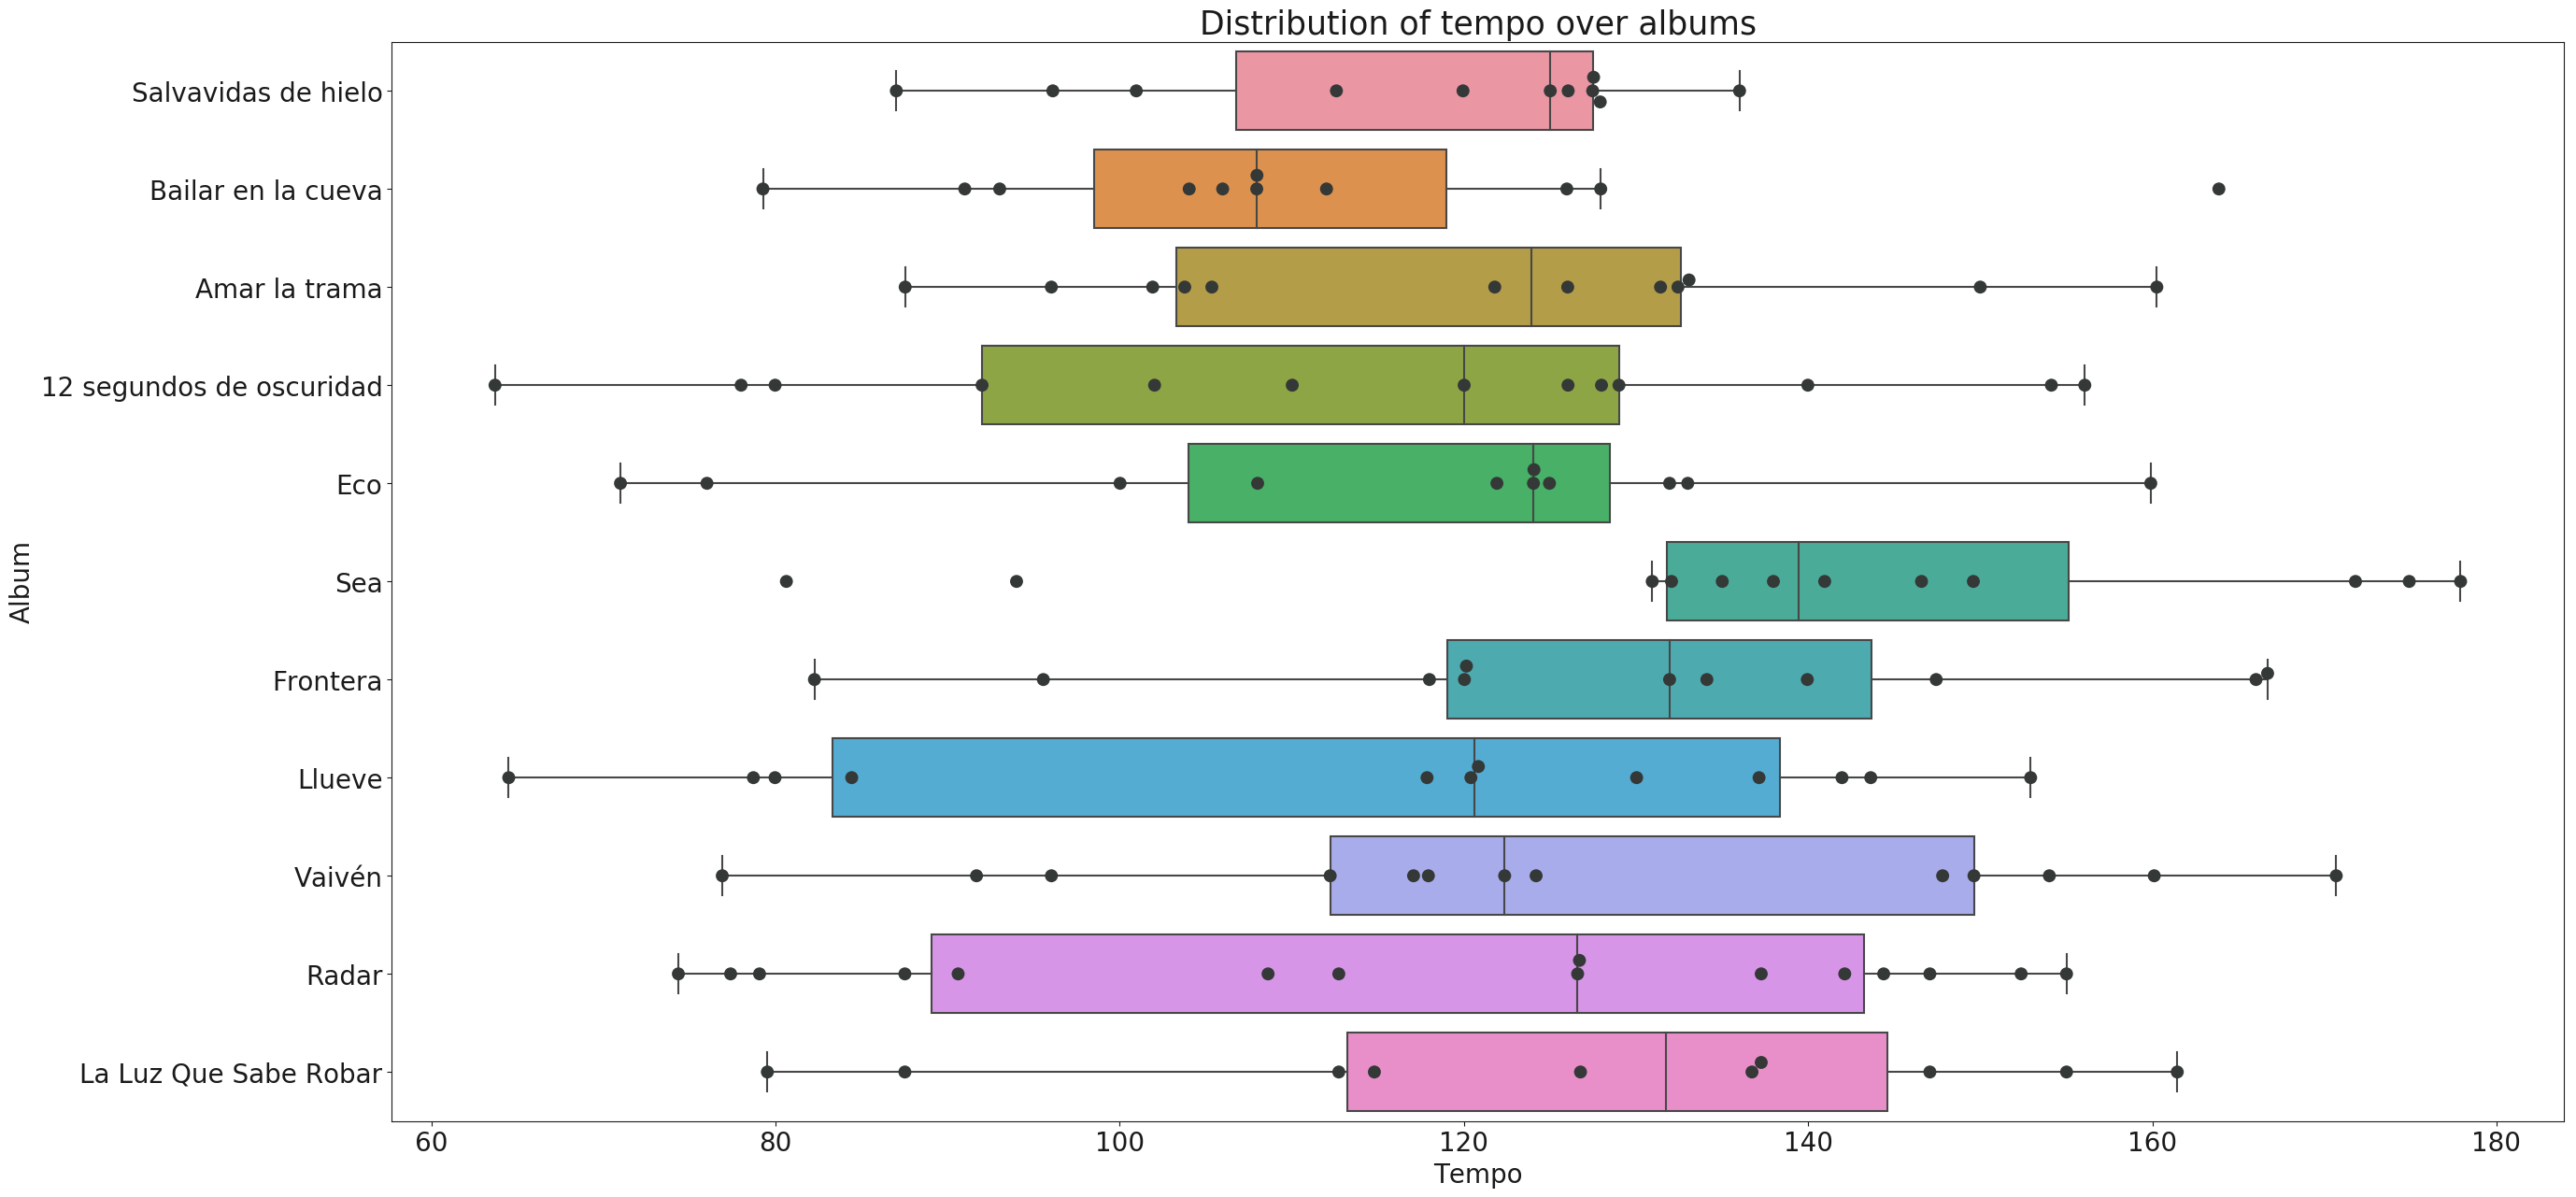

In [71]:
fig, ax = plt.subplots(figsize=(30,15))
ax = sns.boxplot(x="tempo", y="album", data=spoti_df, orient='h')
ax = sns.swarmplot(x="tempo", y="album", data=spoti_df, orient='h', size=10, color="xkcd:charcoal")
plt.xlabel('Tempo', fontsize=20)
plt.ylabel('Album', fontsize=20)
plt.title('Distribution of tempo over albums', fontsize=25)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
plt.plot();

- Fastest album by far: Sea from 2001. This album contains the most upbeat songs.
- Everything else feels pretty much the same. All are distributed around the 120 bpm.

### Song length


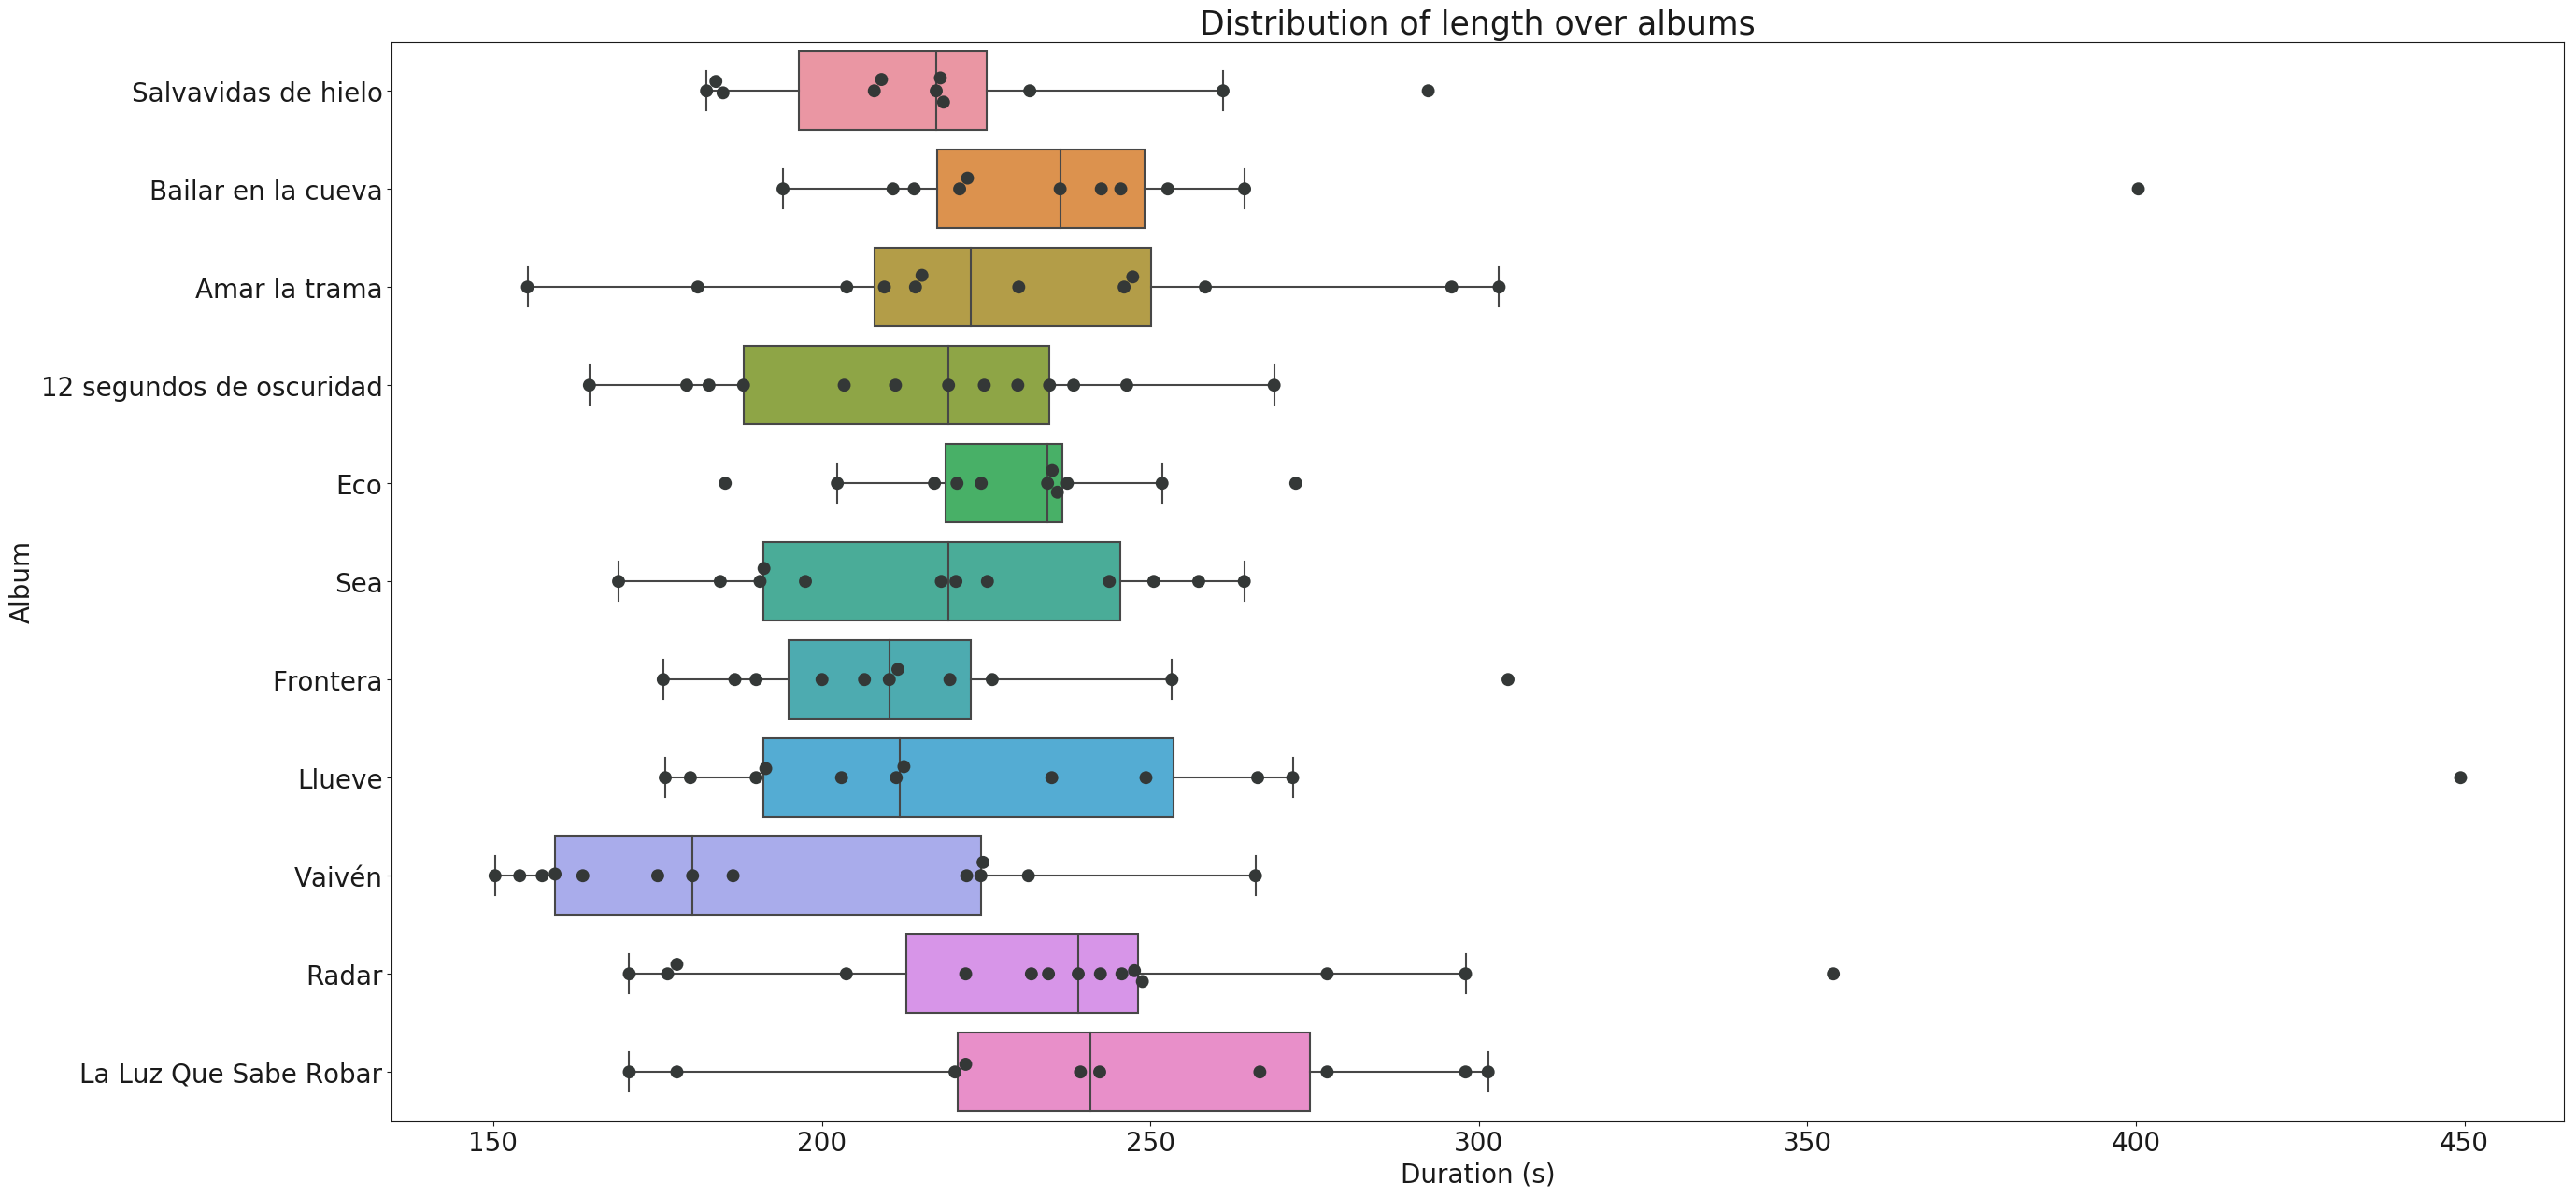

In [72]:
fig, ax = plt.subplots(figsize=(30,15))
ax = sns.boxplot(x="duration_s", y="album", data=df, orient='h')
ax = sns.swarmplot(x="duration_s", y="album", data=df, orient='h', size=10, color="xkcd:charcoal")
plt.xlabel('Duration (s)', fontsize=20)
plt.ylabel('Album', fontsize=20)
plt.title('Distribution of length over albums', fontsize=25)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
plt.plot();

Let's bring again back some past insights into the mix to analyse this one.
- The tendency in lyrical density went up through time and albums.
- Number of words too, as it was correlated to lyrical density.
- Lexical density had the inverted effect: with time Jorge wrote less dense-with-content lyrics

Now we have **track length**
- Track length has decreased slowly through the years.

** With the years, songs got shorter but the lyrics got longer!**



### Key and mode
Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.
The key the track is in. Integers map to pitches using standard Pitch Class notation . E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on.

Let's make a real_key feature

In [73]:
keymap = {0: 'C', 1: 'Db', 2: 'D', 3: 'Eb',
          4:'E', 5:'F', 6:'F#', 7:'G', 8:'Ab',
          9:'A', 10:'Bb', 11:'B'}

In [74]:
df['real_key'] = df.key.map(keymap)
for index, row in df.iterrows():
    if not row['mode']:
        df.at[index, 'real_key'] = row['real_key'] + 'm'        
        #Major is represented by 1 and minor is 0.

In [75]:
spoti_df['real_key'] = df['real_key']

/Users/alex/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Quickly! Let's check which is Jorge's favorite key!

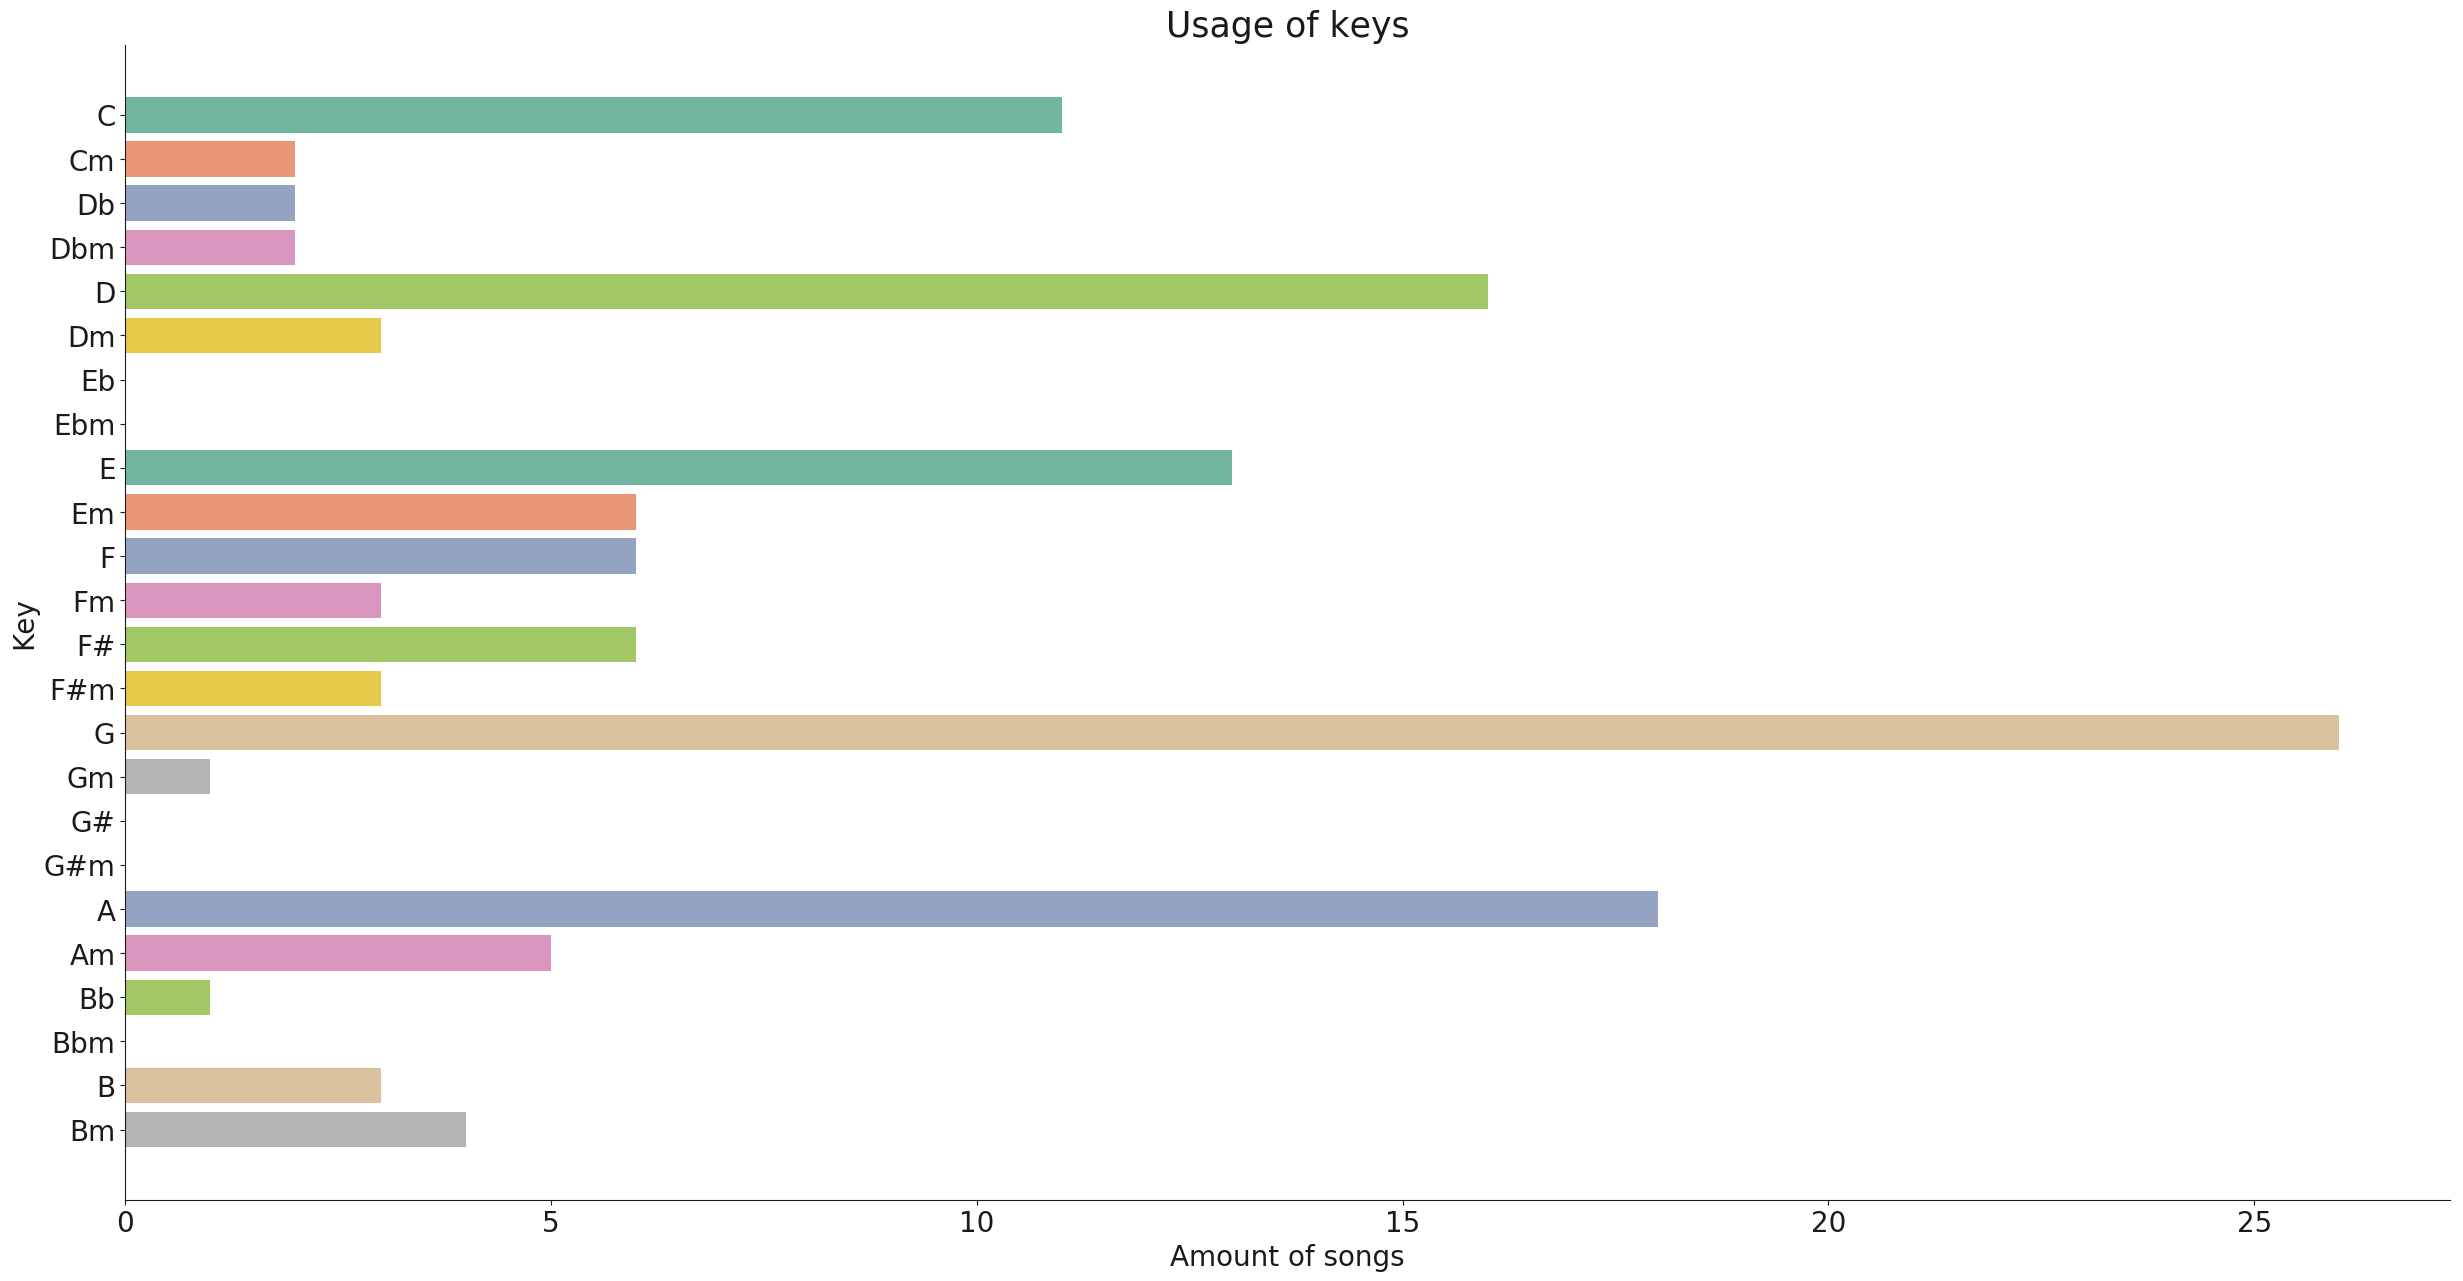

In [76]:
fig, ax = plt.subplots(figsize=(30,15))
# order = sorted(spoti_df.real_key.unique())
order = ['C', 'Cm', 'Db', 'Dbm', 'D', 'Dm', 'Eb', 
         'Ebm', 'E', 'Em', 'F', 'Fm', 'F#', 'F#m', 
         'G', 'Gm', 'G#', 'G#m', 'A', 'Am', 'Bb',
        'Bbm', 'B', 'Bm']
ax = sns.countplot(y="real_key", orient='h', data=spoti_df, order=order, palette="Set2")
plt.xlabel('Amount of songs', fontsize=20)
plt.ylabel('Key', fontsize=20)
plt.title('Usage of keys', fontsize=25)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
sns.despine()
plt.plot();


- Some keys have never been touched by him. Eb and Ebm, G# and G#m, Bbm are all keys that are not particularly easy to deal with in guitar playing.
- On the other side **G and A are the most popular**. Also E, D and C. The 5 of them are super friendly with guitar players.

Yeah, you guessed it. Time to check key by album!

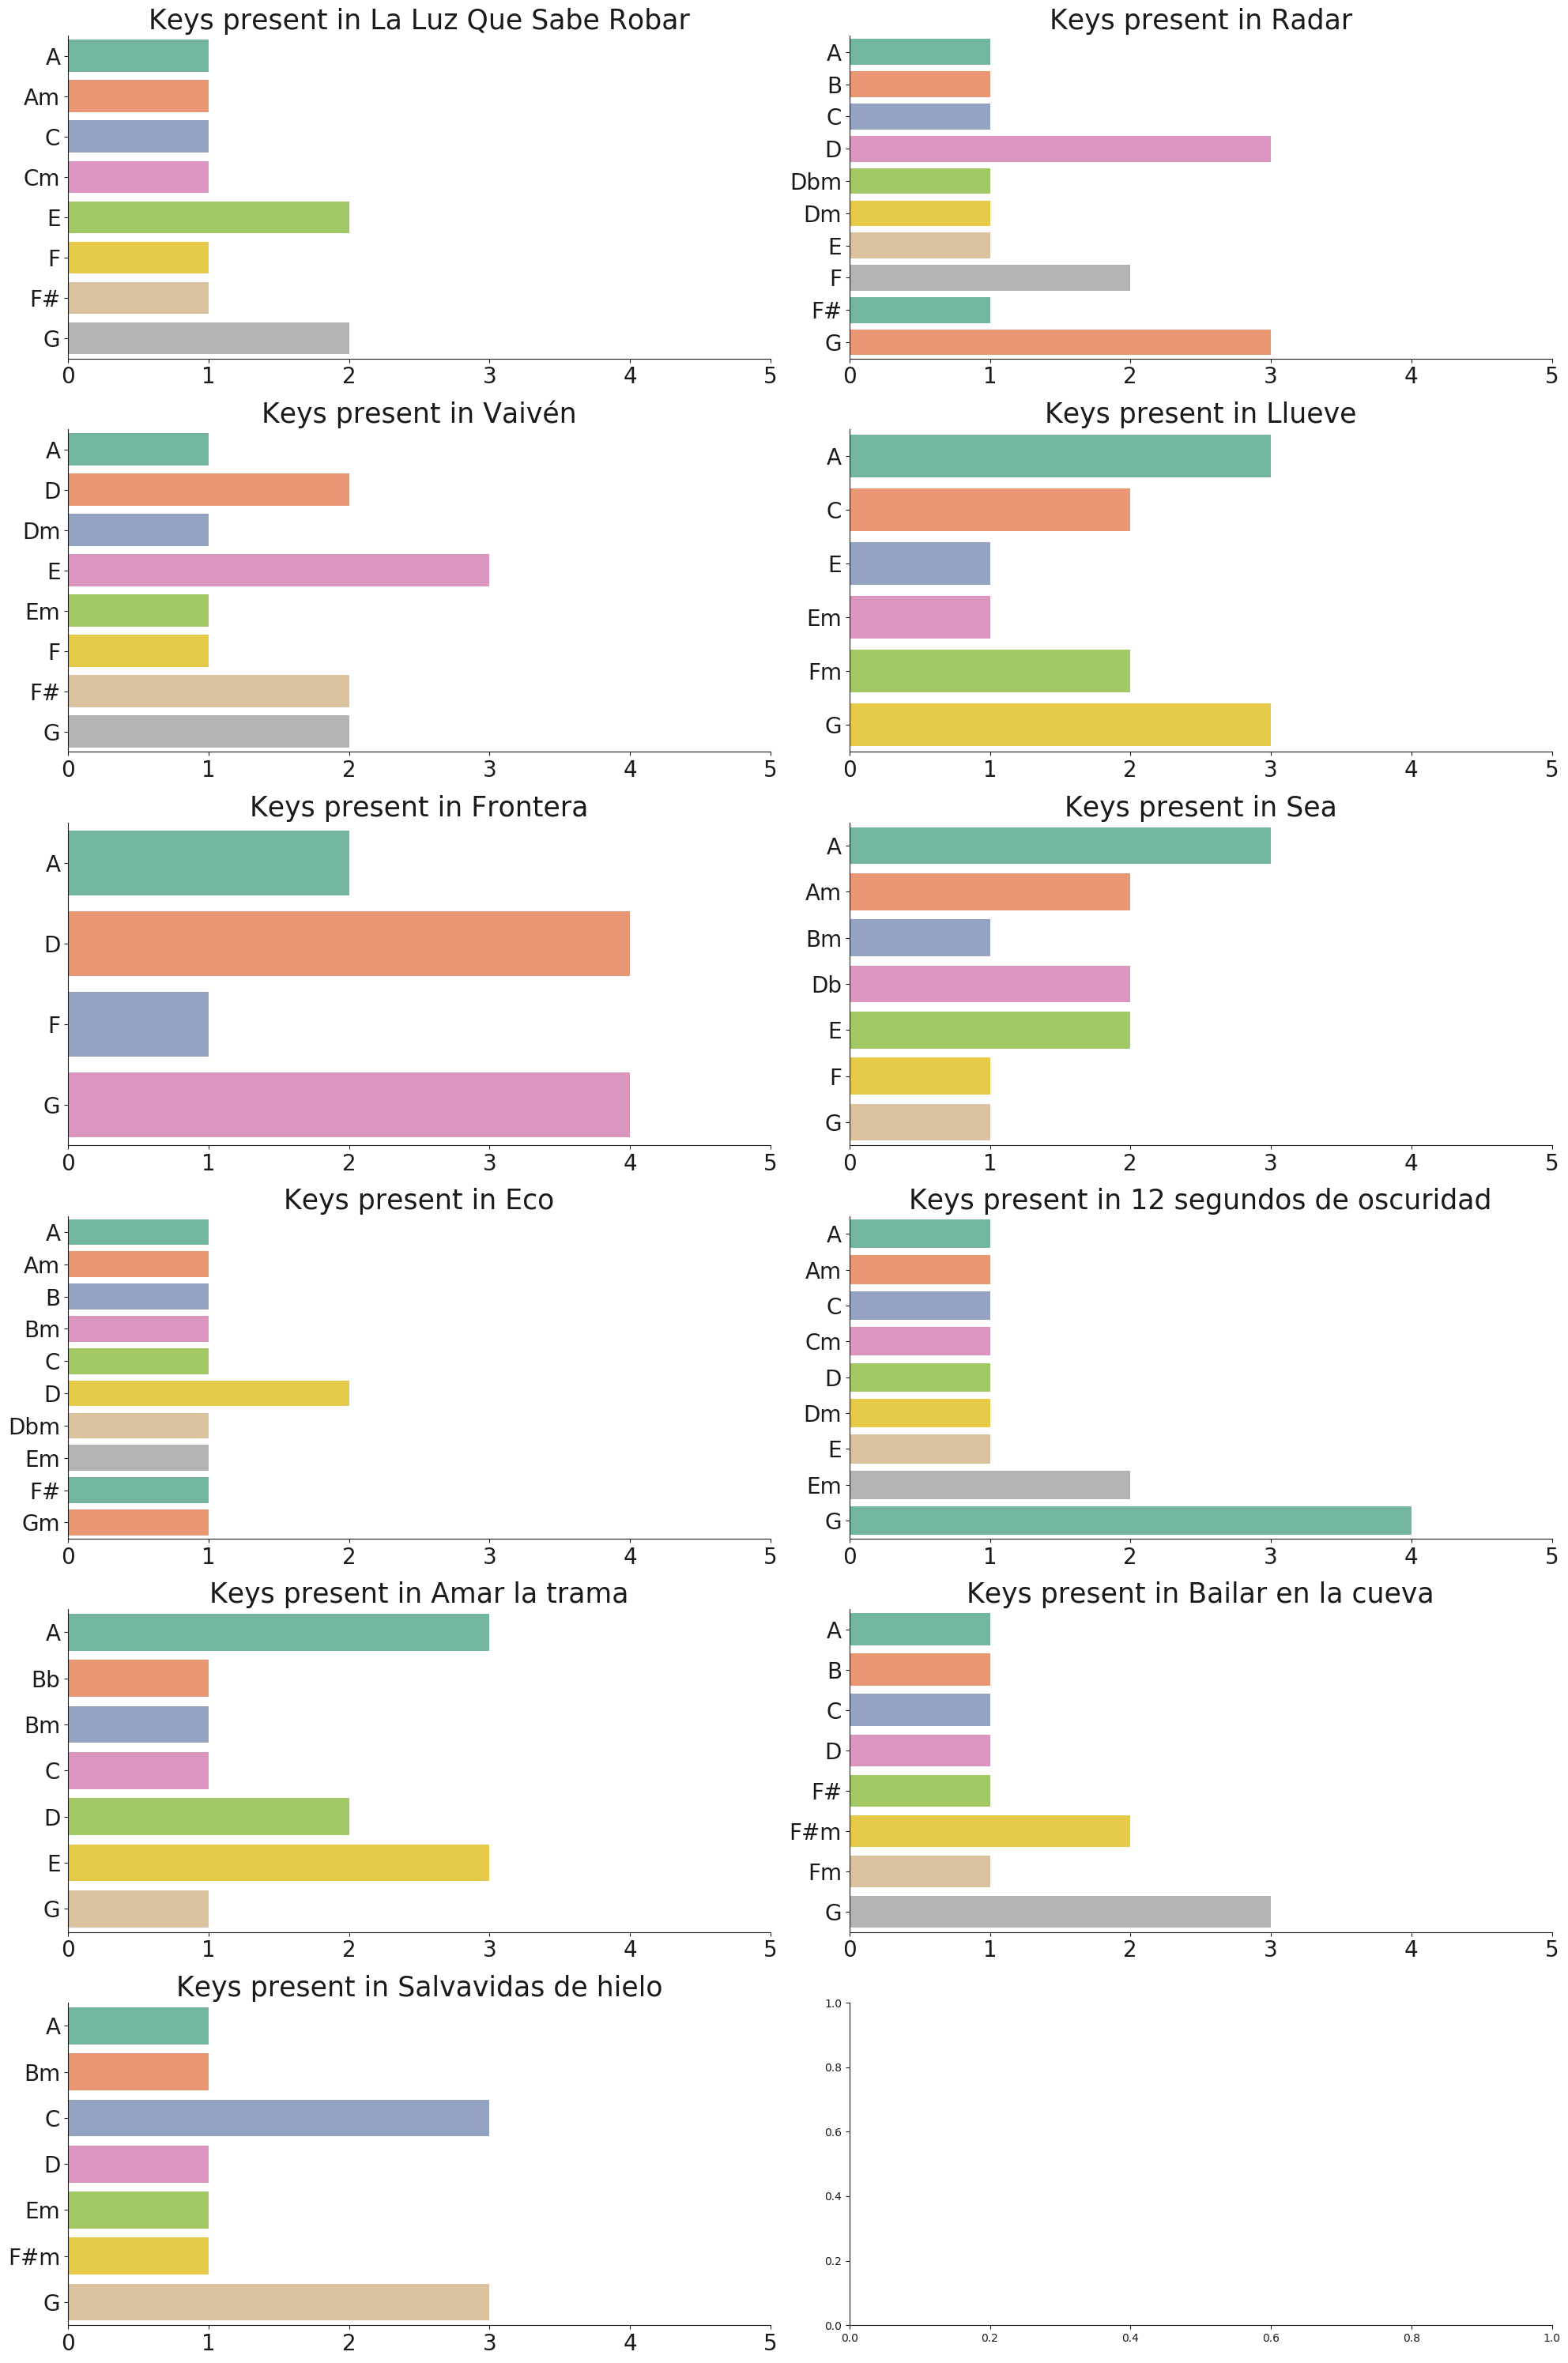

In [77]:
albums_ordered_by_year = [
    'La Luz Que Sabe Robar', 'Radar', 'Vaivén', 
    'Llueve', 'Frontera', 'Sea', 
    'Eco', '12 segundos de oscuridad','Amar la trama',
    'Bailar en la cueva', 'Salvavidas de hielo', ""
]

ROWS = 6
COLS = 2
cols_to_iterate = albums_ordered_by_year
fig, axes = plt.subplots(nrows=ROWS, ncols=COLS, figsize=(20,30))
for row in range(ROWS):
    for col in range(COLS):
        an_album = cols_to_iterate.pop(0)
        if an_album == "":
            break
        key_by_album = pd.DataFrame(spoti_df[spoti_df['album'] == an_album])
        order = sorted(key_by_album.real_key.unique())
        ax = sns.countplot(y="real_key", orient='h', data=key_by_album, ax=axes[row, col], order=order, palette="Set2")
        
        axes[row, col].set_xticks([0,1,2,3,4,5])
        axes[row, col].set_title('Keys present in %s' % an_album, fontsize=25)
        for tick in axes[row, col].xaxis.get_major_ticks():
            tick.label.set_fontsize(20) 
        for tick in axes[row, col].yaxis.get_major_ticks():
            tick.label.set_fontsize(20)

        axes[row, col].set_ylabel("")
        axes[row, col].set_xlabel("")
        
sns.despine()
plt.tight_layout()
plt.show()


 - Frontera is the most monotone album keywise. Only 4 keys. 4 songs in G, 4 songs in D, 2 in A and 1 in F. This is easily the most guitar approachable album.
 - Eco almost never repeated keys, except for two songs in D (Guitarra y vos & Transporte). Weirdly enough, non of those songs is in G: Jorge's favorite key.
 - The rest of the albums are pretty much balanced.

### Valence

According to our guys in Spotify, valence is a measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

So, first let's try to analize happiness and sadness purely from the musical side now.

In [78]:
df.sort_values(by='valence', ascending=False).head()[['name', 'valence']]

name  valence
index                                  
100    Un Lugar En Tu Almohada    0.950
7                      Mandato    0.937
61                       Horas    0.924
60              Causa Y Efecto    0.920
4                 Estalactitas    0.909

There you have it. Those are the 5 happier songs musically.
**Un lugar en tu almohada, Mandato and Horas are the 3 songs that sound happier.**

In [79]:
df.sort_values(by='valence').head()[['name', 'valence']]

name  valence
index                                   
34     12 segundos de oscuridad   0.0396
83                       Llueve   0.0765
21                      Organdí   0.1060
2                      Silencio   0.1270
8      Despedir a los glaciares   0.1430

On the other side of the ring, these are the 5 saddest songs musically.
**12 segundos de oscuridad, Llueve and Organdí are the 3 songs that sound sadder.**

Now, let's go with something more interesting. To finish the analysis, let's make music and lyrics meet. 

In [this amazing article](https://www.rcharlie.com/post/fitter-happier/), RCharlie creates a metric called gloom_index which combines them perfectly and finds out which is Radiohead's more depressing song. I encourage everyone to check it out.
$$ gloom\_index = \frac{(1 - valence) + sadness\_per * (1 + ly_d)}{2}$$
Come, let's do the same for Jorge's songs!

First, let's calculate sadness percentage

In [80]:
for index, row in df.iterrows():    
    try:
        to_lower = list(map(lambda x:x.lower(),df.loc[index].tokens))
        annotation = lexicon.annotate_doc(to_lower)
        count_sadness = 0
        for a_set in annotation:
            if 'sadness' in a_set:
                count_sadness +=1
        df.at[index, 'sadness_per'] = count_sadness / len(annotation)        
    except:
        continue

And gloom index!

In [81]:
df['gloom_index'] = ((1 - df['valence']) + df['sadness_per'] * (1 + df['ly_d']) ) / 2

Scaling it from 100 to 1. 100 is maximum gloom, 1 is minimum.

In [82]:
# Create x, where x the 'scores' column's values as floats
x = df[['gloom_index']].fillna(0).values.astype(float)

# Create a minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(1,100))

# Create an object to transform the data to fit minmax processor
df['gloom_index'] = min_max_scaler.fit_transform(x)

In [83]:
df.sort_values(by='gloom_index', ascending=False).head()[['name', 'gloom_index']]

name  gloom_index
index                                       
34     12 segundos de oscuridad   100.000000
8      Despedir a los glaciares    86.083937
83                       Llueve    85.760917
87                       Cara B    85.351075
21                      Organdí    84.602588

Here you have it.

**12 segundos de oscuridad** is Jorge's most depressing song.

Let's graph gloom_index along the album and see which is his most depressing album!

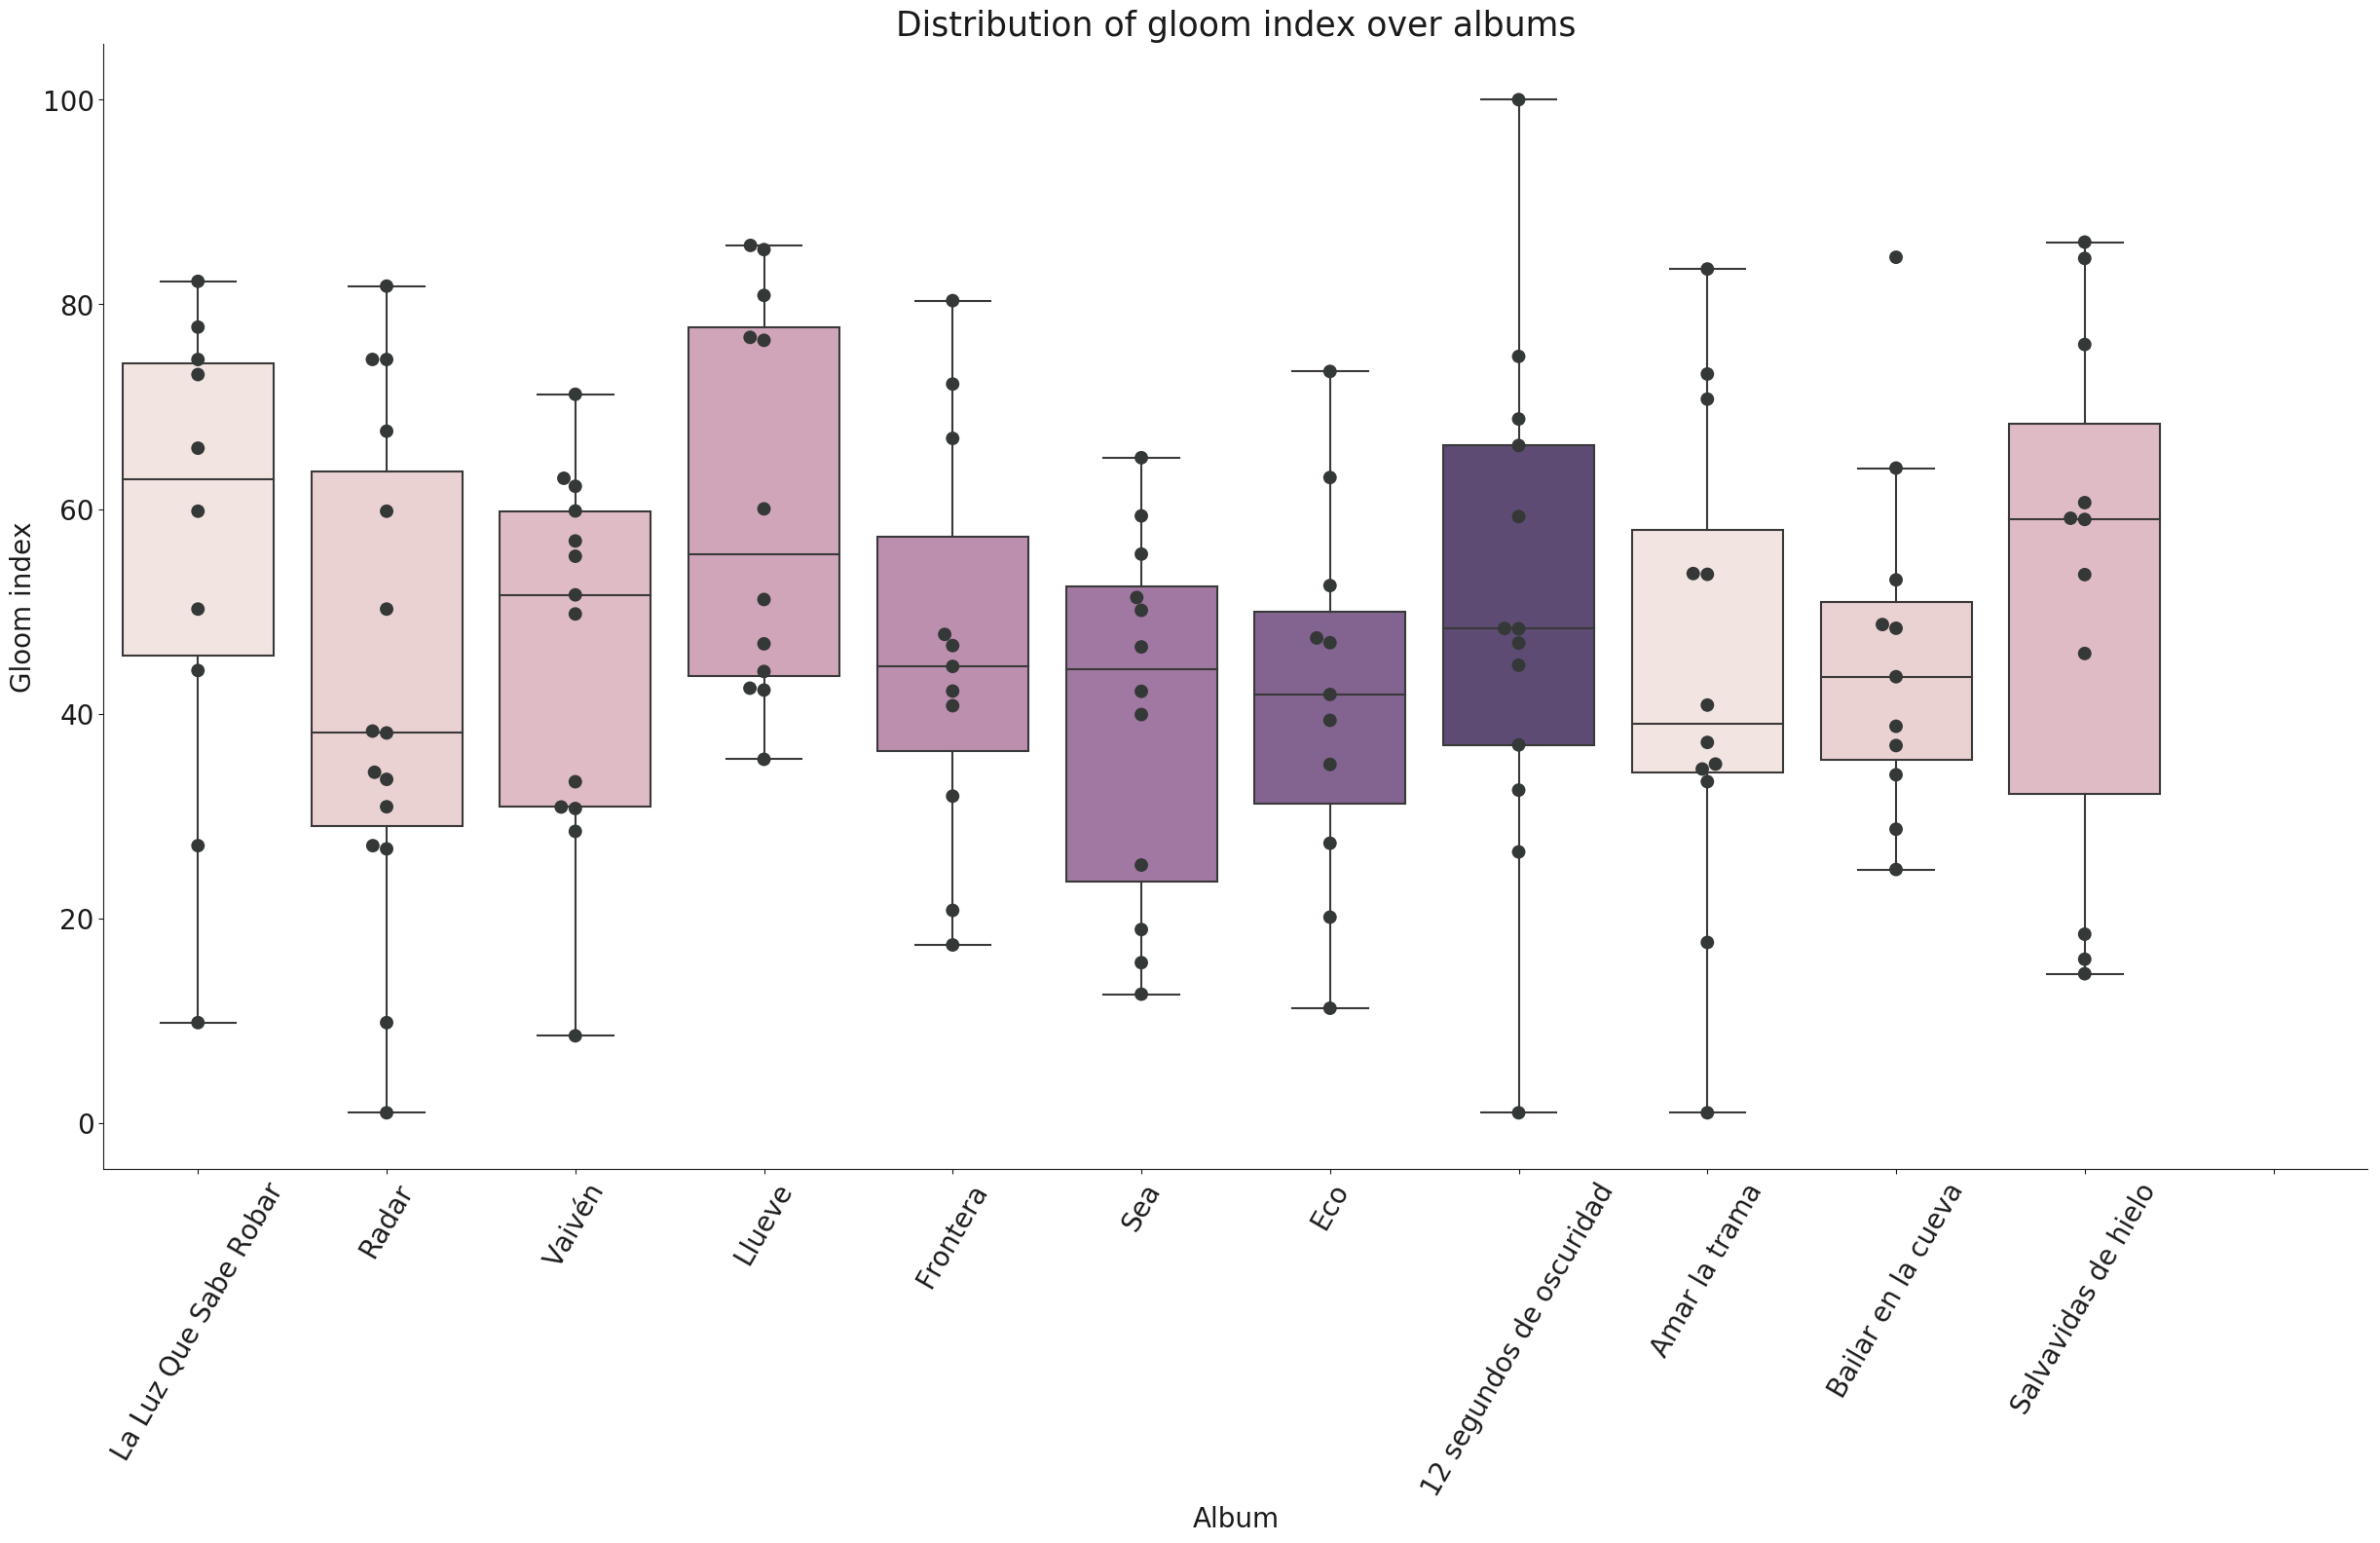

In [84]:
albums_ordered_by_year = [
    'La Luz Que Sabe Robar', 'Radar', 'Vaivén', 
    'Llueve', 'Frontera', 'Sea', 
    'Eco', '12 segundos de oscuridad','Amar la trama',
    'Bailar en la cueva', 'Salvavidas de hielo', ""
]

fig, ax = plt.subplots(figsize=(30,15))
ax = sns.boxplot(y="gloom_index", x="album", data=df, order=albums_ordered_by_year, palette=sns.cubehelix_palette(8, gamma=.6))
ax = sns.swarmplot(y="gloom_index", x="album", data=df, size=10, color="xkcd:charcoal", order=albums_ordered_by_year)
plt.xlabel('Album', fontsize=20)
plt.ylabel('Gloom index', fontsize=20)
plt.title('Distribution of gloom index over albums', fontsize=25)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
    tick.label.set_rotation(60) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
sns.despine();
plt.plot();

Against all odds, apparently the most depressing album is **Llueve**!

In [85]:
df.groupby('album')['gloom_index'].mean().sort_values(ascending=False)

album
Llueve                      60.644496
La Luz Que Sabe Robar       56.487516
Salvavidas de hielo         52.171982
12 segundos de oscuridad    50.340911
Frontera                    46.510978
Vaivén                      46.297294
Bailar en la cueva          45.957787
Amar la trama               44.535219
Radar                       43.235138
Eco                         41.667041
Sea                         40.200486
Name: gloom_index, dtype: float64

Here you have them, ranked. **The happiest are indeed Eco and Sea.**

References. Thanks! 


http://sigdelta.com/blog/text-analysis-in-pandas/

http://www.everydayanalytics.ca/2013/06/radiohead-lyrics-data-visualization-and-content-analysis.html

https://www.promptcloud.com/blog/data-visualization-text-mining-taylor-swift-song-lyrics

https://www.rcharlie.com/post/fitter-happier/
